# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 300
encord_size = int(max_size / 2)

MAKE_DATASET = False
TRAIN_AUTO_ENCODER = False

cnn_path = './model/cnn_' + str(max_size) + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


### 各ウエハにラベル付け

In [5]:
# trials = 2
# label_list = []
# for i in range(new_x.shape[0]):
#     label_dict = {'wafer_id':str(i).zfill(6), 'true_label':y[i][0], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials}
#     label_list.append(label_dict)

In [6]:
# print(label_list[1])

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

- 保存/読み込み

In [7]:
# MAKE_DATASET = False
# ver = 'shawon' if shawon else 'propose'
# if MAKE_DATASET:
#     pickle_dump(new_x, './data/new_x_' + ver + '.pickle')
#     pickle_dump(new_y, './data/new_y_' + ver + '.pickle')
#     pickle_dump(label_list, './data/label_list_' + ver + '.pickle')
    
# if not MAKE_DATASET:
#     new_x = pickle_load('./data/new_x_' + ver + '.pickle')
#     new_y = pickle_load('./data/new_y_' + ver + '.pickle')
#     label_list = pickle_load('./data/label_list_' + ver + '.pickle')

In [8]:
# for i, l in enumerate(faulty_case):
#     new_y[new_y==l] = i

In [9]:
# for i in range(len(label_list)):
#     label_list[i]['true_label'] = new_y[i][0]

### データの読み出し

In [10]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

indices = np.array(range(len(TRAINS)))
x_train, x_validation, y_train, y_validation, indices_train, indices_validation = train_test_split(
    TRAINS, new_y, indices, test_size=0.01, random_state=2020)

In [11]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

In [12]:
# # testsize = 2000
# # randlist = rand_ints_nodup(0, new_x.shape[0]-1, testsize)

# # valx = new_x.copy()[randlist, :, :, :]
# # valy = y.copy()[randlist, :]

# test_size = 705 #705
# new_x_size = new_x.shape[0]
# testlist = rand_ints_nodup(0, new_x_size-1, test_size)
# trainlist = [i for i in range(new_x_size) if i != testlist]
# new_X=new_x[trainlist]
# new_Y=new_y[trainlist]
# test_x=new_x[testlist]
# test_y=new_y[testlist]

# label_train = copy.deepcopy([label_list[i] for i in trainlist])
# label_test = copy.deepcopy([label_list[i] for i in testlist])

# test_x.shape

In [13]:
# new_X=new_x
# new_Y=new_y

- 学習データとテストデータに分割する．

In [14]:
# indices = np.array(range(new_X.shape[0]))

# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(new_X, new_Y, indices,
#                                                                 test_size=0.33,
#                                                                 random_state=2020)

In [15]:
# label_vali = copy.deepcopy([label_train[i] for i in indices_test.tolist()])
# label_train = copy.deepcopy([label_train[i] for i in indices_train.tolist()])

In [16]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

Train x : 299014, y : (299014, 9)
Validation x: 3021, y : (3021, 9)


In [17]:
print("loading X_validation...")
with Pool() as p:
    arr = p.map(load_array, x_validation)

x_validation = np.array(arr).reshape(len(x_validation), max_size, max_size, 3)

loading X_validation...


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [18]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_1)

        flat = layers.Flatten()(conv_2)

        dense_1 = layers.Dense(64, activation='relu')(flat)
        output_tensor = layers.Dense(9, activation='softmax')(dense_1)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [19]:
# model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# # results = cross_val_score(model, x_train, y_train, cv=kfold)
# # # Check 3-fold model's mean accuracy
# # print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [20]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


In [21]:
epoch=5
batch_size=128
random.seed(1)

In [22]:
model = create_model()
epoch_train_loss = []
epoch_train_acc = []
epoch_validation_loss = []
epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
0 / 5
doing 0 / 2337
elapsed time 4.524112939834595
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/re

elapsed time 190.07331609725952
4/4 [==============================] - 0s 12ms/step - accuracy: 0.1953 - loss: 2.1914
batch loss: 2.191444158554077
batch accuracy: 0.1953125
doing 35 / 2337
elapsed time 195.46000409126282
4/4 [==============================] - 0s 12ms/step - accuracy: 0.0781 - loss: 2.2527
batch loss: 2.2527084350585938
batch accuracy: 0.078125
doing 36 / 2337
elapsed time 201.13897037506104
4/4 [==============================] - 0s 12ms/step - accuracy: 0.1953 - loss: 2.1964
batch loss: 2.196352481842041
batch accuracy: 0.1953125
doing 37 / 2337
elapsed time 206.45543503761292
4/4 [==============================] - 0s 12ms/step - accuracy: 0.1406 - loss: 2.1818
batch loss: 2.1817851066589355
batch accuracy: 0.140625
doing 38 / 2337
elapsed time 211.85476899147034
4/4 [==============================] - 0s 12ms/step - accuracy: 0.2031 - loss: 2.1678
batch loss: 2.167752265930176
batch accuracy: 0.203125
doing 39 / 2337
elapsed time 217.73278164863586
4/4 [==============

4/4 [==============================] - 0s 11ms/step - accuracy: 0.3516 - loss: 1.7675
batch loss: 1.7674705982208252
batch accuracy: 0.3515625
doing 78 / 2337
elapsed time 428.5050494670868
4/4 [==============================] - 0s 12ms/step - accuracy: 0.3281 - loss: 1.8264
batch loss: 1.8264422416687012
batch accuracy: 0.328125
doing 79 / 2337
elapsed time 434.1051461696625
4/4 [==============================] - 0s 12ms/step - accuracy: 0.3438 - loss: 1.8801
batch loss: 1.8801435232162476
batch accuracy: 0.34375
doing 80 / 2337
elapsed time 439.9758656024933
4/4 [==============================] - 0s 12ms/step - accuracy: 0.2734 - loss: 1.8701
batch loss: 1.8700687885284424
batch accuracy: 0.2734375
doing 81 / 2337
elapsed time 445.9552528858185
4/4 [==============================] - 0s 12ms/step - accuracy: 0.3594 - loss: 1.8852
batch loss: 1.8851828575134277
batch accuracy: 0.359375
doing 82 / 2337
elapsed time 450.5599274635315
4/4 [==============================] - 0s 12ms/step - 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.4062 - loss: 1.5629
batch loss: 1.5628972053527832
batch accuracy: 0.40625
doing 121 / 2337
elapsed time 657.5981676578522
4/4 [==============================] - 0s 12ms/step - accuracy: 0.4531 - loss: 1.5216
batch loss: 1.5215950012207031
batch accuracy: 0.453125
doing 122 / 2337
elapsed time 663.8652317523956
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5078 - loss: 1.5455
batch loss: 1.5455408096313477
batch accuracy: 0.5078125
doing 123 / 2337
elapsed time 669.8536398410797
4/4 [==============================] - 0s 12ms/step - accuracy: 0.4609 - loss: 1.5635
batch loss: 1.563499927520752
batch accuracy: 0.4609375
doing 124 / 2337
elapsed time 675.5159978866577
4/4 [==============================] - 0s 11ms/step - accuracy: 0.4688 - loss: 1.4736
batch loss: 1.473587989807129
batch accuracy: 0.46875
doing 125 / 2337
elapsed time 681.1184208393097
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 11ms/step - accuracy: 0.5312 - loss: 1.4281
batch loss: 1.428122878074646
batch accuracy: 0.53125
doing 164 / 2337
elapsed time 888.4107241630554
4/4 [==============================] - 0s 11ms/step - accuracy: 0.4922 - loss: 1.4255
batch loss: 1.425492763519287
batch accuracy: 0.4921875
doing 165 / 2337
elapsed time 893.1014902591705
4/4 [==============================] - 0s 12ms/step - accuracy: 0.4844 - loss: 1.4700
batch loss: 1.470025897026062
batch accuracy: 0.484375
doing 166 / 2337
elapsed time 898.8472447395325
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5625 - loss: 1.2979
batch loss: 1.2979223728179932
batch accuracy: 0.5625
doing 167 / 2337
elapsed time 904.582347869873
4/4 [==============================] - 0s 13ms/step - accuracy: 0.5469 - loss: 1.3421
batch loss: 1.342124342918396
batch accuracy: 0.546875
doing 168 / 2337
elapsed time 910.0383126735687
4/4 [==============================] - 0s 11ms/step - acc

4/4 [==============================] - 0s 12ms/step - accuracy: 0.5781 - loss: 1.2828
batch loss: 1.2828106880187988
batch accuracy: 0.578125
doing 207 / 2337
elapsed time 1120.0592155456543
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5938 - loss: 1.1601
batch loss: 1.160111427307129
batch accuracy: 0.59375
doing 208 / 2337
elapsed time 1125.0652906894684
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5703 - loss: 1.2563
batch loss: 1.2562750577926636
batch accuracy: 0.5703125
doing 209 / 2337
elapsed time 1129.8866229057312
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5234 - loss: 1.3442
batch loss: 1.3442065715789795
batch accuracy: 0.5234375
doing 210 / 2337
elapsed time 1134.950160741806
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5703 - loss: 1.3306
batch loss: 1.3305692672729492
batch accuracy: 0.5703125
doing 211 / 2337
elapsed time 1139.5689051151276
4/4 [==============================] - 0s 13m

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6250 - loss: 0.9979
batch loss: 0.9978631138801575
batch accuracy: 0.625
doing 250 / 2337
elapsed time 1333.7495200634003
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5703 - loss: 1.1461
batch loss: 1.146106243133545
batch accuracy: 0.5703125
doing 251 / 2337
elapsed time 1338.750249862671
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6641 - loss: 1.0073
batch loss: 1.0072804689407349
batch accuracy: 0.6640625
doing 252 / 2337
elapsed time 1343.2381031513214
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6484 - loss: 1.0433
batch loss: 1.0433019399642944
batch accuracy: 0.6484375
doing 253 / 2337
elapsed time 1348.342776298523
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6016 - loss: 1.0737
batch loss: 1.0737073421478271
batch accuracy: 0.6015625
doing 254 / 2337
elapsed time 1353.6039431095123
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 12ms/step - accuracy: 0.5703 - loss: 1.2266
batch loss: 1.2265664339065552
batch accuracy: 0.5703125
doing 293 / 2337
elapsed time 1552.8489327430725
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6172 - loss: 1.1073
batch loss: 1.1072633266448975
batch accuracy: 0.6171875
doing 294 / 2337
elapsed time 1558.4635787010193
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6094 - loss: 1.0950
batch loss: 1.0949897766113281
batch accuracy: 0.609375
doing 295 / 2337
elapsed time 1564.0196480751038
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6016 - loss: 1.0002
batch loss: 1.0001511573791504
batch accuracy: 0.6015625
doing 296 / 2337
elapsed time 1569.4977912902832
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6953 - loss: 0.9681
batch loss: 0.9681006669998169
batch accuracy: 0.6953125
doing 297 / 2337
elapsed time 1574.267511844635
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6484 - loss: 0.8464
batch loss: 0.8464316725730896
batch accuracy: 0.6484375
doing 336 / 2337
elapsed time 1773.4699308872223
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7109 - loss: 0.8881
batch loss: 0.8881383538246155
batch accuracy: 0.7109375
doing 337 / 2337
elapsed time 1778.5903298854828
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6484 - loss: 1.0606
batch loss: 1.0606229305267334
batch accuracy: 0.6484375
doing 338 / 2337
elapsed time 1784.121693611145
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5938 - loss: 1.1072
batch loss: 1.1072003841400146
batch accuracy: 0.59375
doing 339 / 2337
elapsed time 1789.3261632919312
4/4 [==============================] - 0s 12ms/step - accuracy: 0.5781 - loss: 1.0764
batch loss: 1.0763893127441406
batch accuracy: 0.578125
doing 340 / 2337
elapsed time 1794.4512453079224
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.9709
batch loss: 0.9709053039550781
batch accuracy: 0.671875
doing 379 / 2337
elapsed time 1992.2482516765594
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.8579
batch loss: 0.8579208850860596
batch accuracy: 0.671875
doing 380 / 2337
elapsed time 1998.7459342479706
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7578 - loss: 0.8071
batch loss: 0.807144045829773
batch accuracy: 0.7578125
doing 381 / 2337
elapsed time 2003.450429201126
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.9511
batch loss: 0.9511367082595825
batch accuracy: 0.671875
doing 382 / 2337
elapsed time 2008.1581819057465
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6328 - loss: 1.0362
batch loss: 1.036211371421814
batch accuracy: 0.6328125
doing 383 / 2337
elapsed time 2013.8038187026978
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6797 - loss: 0.9288
batch loss: 0.9288445711135864
batch accuracy: 0.6796875
doing 422 / 2337
elapsed time 2226.150544166565
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7109 - loss: 0.8345
batch loss: 0.8344632387161255
batch accuracy: 0.7109375
doing 423 / 2337
elapsed time 2231.3379366397858
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6797 - loss: 0.8671
batch loss: 0.8670536875724792
batch accuracy: 0.6796875
doing 424 / 2337
elapsed time 2237.9212052822113
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6484 - loss: 1.0158
batch loss: 1.0158427953720093
batch accuracy: 0.6484375
doing 425 / 2337
elapsed time 2244.2834134101868
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6797 - loss: 0.9324
batch loss: 0.9324119091033936
batch accuracy: 0.6796875
doing 426 / 2337
elapsed time 2250.359056711197
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.8761
batch loss: 0.8760969638824463
batch accuracy: 0.671875
doing 465 / 2337
elapsed time 2481.756559610367
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7656 - loss: 0.8146
batch loss: 0.814558207988739
batch accuracy: 0.765625
doing 466 / 2337
elapsed time 2487.591627597809
4/4 [==============================] - 0s 11ms/step - accuracy: 0.6484 - loss: 0.9799
batch loss: 0.9798827171325684
batch accuracy: 0.6484375
doing 467 / 2337
elapsed time 2493.546667575836
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.8425
batch loss: 0.8425472974777222
batch accuracy: 0.671875
doing 468 / 2337
elapsed time 2499.079908847809
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7344 - loss: 0.7459
batch loss: 0.7459349036216736
batch accuracy: 0.734375
doing 469 / 2337
elapsed time 2504.7049975395203
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7812 - loss: 0.6620
batch loss: 0.6620134115219116
batch accuracy: 0.78125
doing 508 / 2337
elapsed time 2721.52250790596
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7500 - loss: 0.7929
batch loss: 0.7929142713546753
batch accuracy: 0.75
doing 509 / 2337
elapsed time 2726.732015609741
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6562 - loss: 0.9243
batch loss: 0.9242528080940247
batch accuracy: 0.65625
doing 510 / 2337
elapsed time 2732.553038597107
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7266 - loss: 0.8553
batch loss: 0.8553339242935181
batch accuracy: 0.7265625
doing 511 / 2337
elapsed time 2738.580957889557
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6797 - loss: 0.8194
batch loss: 0.8194159269332886
batch accuracy: 0.6796875
doing 512 / 2337
elapsed time 2744.40744304657
4/4 [==============================] - 0s 11ms/step - ac

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7422 - loss: 0.7623
batch loss: 0.7622777223587036
batch accuracy: 0.7421875
doing 551 / 2337
elapsed time 2958.1855828762054
4/4 [==============================] - 0s 11ms/step - accuracy: 0.6953 - loss: 0.8742
batch loss: 0.8741714358329773
batch accuracy: 0.6953125
doing 552 / 2337
elapsed time 2963.5732979774475
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7188 - loss: 0.8121
batch loss: 0.8120536804199219
batch accuracy: 0.71875
doing 553 / 2337
elapsed time 2969.863389492035
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7031 - loss: 0.8859
batch loss: 0.8859426975250244
batch accuracy: 0.703125
doing 554 / 2337
elapsed time 2975.550908088684
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7578 - loss: 0.6642
batch loss: 0.6642005443572998
batch accuracy: 0.7578125
doing 555 / 2337
elapsed time 2980.534975528717
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 11ms/step - accuracy: 0.7422 - loss: 0.6799
batch loss: 0.6799001693725586
batch accuracy: 0.7421875
doing 594 / 2337
elapsed time 3190.863273859024
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6797 - loss: 0.9615
batch loss: 0.9614756107330322
batch accuracy: 0.6796875
doing 595 / 2337
elapsed time 3195.922991037369
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7578 - loss: 0.7433
batch loss: 0.743276834487915
batch accuracy: 0.7578125
doing 596 / 2337
elapsed time 3202.1756479740143
4/4 [==============================] - 0s 13ms/step - accuracy: 0.7500 - loss: 0.6303
batch loss: 0.6303098797798157
batch accuracy: 0.75
doing 597 / 2337
elapsed time 3206.995779275894
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7109 - loss: 0.7524
batch loss: 0.7524147033691406
batch accuracy: 0.7109375
doing 598 / 2337
elapsed time 3212.456568002701
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 12ms/step - accuracy: 0.6719 - loss: 0.8878
batch loss: 0.8877672553062439
batch accuracy: 0.671875
doing 637 / 2337
elapsed time 3414.7002153396606
4/4 [==============================] - 0s 12ms/step - accuracy: 0.6641 - loss: 0.9161
batch loss: 0.9161316752433777
batch accuracy: 0.6640625
doing 638 / 2337
elapsed time 3419.7166407108307
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7500 - loss: 0.7192
batch loss: 0.7192422151565552
batch accuracy: 0.75
doing 639 / 2337
elapsed time 3424.4478328227997
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7656 - loss: 0.6746
batch loss: 0.6746244430541992
batch accuracy: 0.765625
doing 640 / 2337
elapsed time 3429.5113813877106
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7344 - loss: 0.6288
batch loss: 0.6288318634033203
batch accuracy: 0.734375
doing 641 / 2337
elapsed time 3434.446167945862
4/4 [==============================] - 0s 11ms/st

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7656 - loss: 0.6430
batch loss: 0.64296555519104
batch accuracy: 0.765625
doing 680 / 2337
elapsed time 3637.1635835170746
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7031 - loss: 0.7434
batch loss: 0.7433559894561768
batch accuracy: 0.703125
doing 681 / 2337
elapsed time 3642.9958696365356
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7578 - loss: 0.6071
batch loss: 0.6070978045463562
batch accuracy: 0.7578125
doing 682 / 2337
elapsed time 3648.4084765911102
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7578 - loss: 0.6473
batch loss: 0.6472987532615662
batch accuracy: 0.7578125
doing 683 / 2337
elapsed time 3653.0205206871033
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7188 - loss: 0.7594
batch loss: 0.7593509554862976
batch accuracy: 0.71875
doing 684 / 2337
elapsed time 3658.774413585663
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 11ms/step - accuracy: 0.7344 - loss: 0.7334
batch loss: 0.7333818674087524
batch accuracy: 0.734375
doing 723 / 2337
elapsed time 3859.587939977646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.6421
batch loss: 0.6421198844909668
batch accuracy: 0.7890625
doing 724 / 2337
elapsed time 3864.57834815979
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8203 - loss: 0.5283
batch loss: 0.52833092212677
batch accuracy: 0.8203125
doing 725 / 2337
elapsed time 3869.5570368766785
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7344 - loss: 0.7303
batch loss: 0.7303109169006348
batch accuracy: 0.734375
doing 726 / 2337
elapsed time 3874.5413060188293
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7891 - loss: 0.6727
batch loss: 0.672744870185852
batch accuracy: 0.7890625
doing 727 / 2337
elapsed time 3880.3250563144684
4/4 [==============================] - 0s 12ms/s

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.6220
batch loss: 0.6219995021820068
batch accuracy: 0.7890625
doing 766 / 2337
elapsed time 4081.5856370925903
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8438 - loss: 0.4997
batch loss: 0.49967047572135925
batch accuracy: 0.84375
doing 767 / 2337
elapsed time 4086.732945919037
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7891 - loss: 0.6685
batch loss: 0.6684950590133667
batch accuracy: 0.7890625
doing 768 / 2337
elapsed time 4091.3670592308044
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.5538
batch loss: 0.5537808537483215
batch accuracy: 0.7890625
doing 769 / 2337
elapsed time 4096.87975525856
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7969 - loss: 0.5915
batch loss: 0.5914962291717529
batch accuracy: 0.796875
doing 770 / 2337
elapsed time 4101.220570087433
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 13ms/step - accuracy: 0.7734 - loss: 0.6438
batch loss: 0.6438172459602356
batch accuracy: 0.7734375
doing 809 / 2337
elapsed time 4300.884611368179
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8594 - loss: 0.4504
batch loss: 0.4504127502441406
batch accuracy: 0.859375
doing 810 / 2337
elapsed time 4306.195821046829
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7734 - loss: 0.6529
batch loss: 0.6529210209846497
batch accuracy: 0.7734375
doing 811 / 2337
elapsed time 4311.011489391327
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7422 - loss: 0.6507
batch loss: 0.6506573557853699
batch accuracy: 0.7421875
doing 812 / 2337
elapsed time 4316.331521272659
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7734 - loss: 0.6561
batch loss: 0.6561428308486938
batch accuracy: 0.7734375
doing 813 / 2337
elapsed time 4321.468252658844
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.6378
batch loss: 0.6377784013748169
batch accuracy: 0.8125
doing 852 / 2337
elapsed time 4519.932246685028
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8359 - loss: 0.5360
batch loss: 0.5360122323036194
batch accuracy: 0.8359375
doing 853 / 2337
elapsed time 4525.425820827484
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7500 - loss: 0.6289
batch loss: 0.6289376020431519
batch accuracy: 0.75
doing 854 / 2337
elapsed time 4530.297251701355
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.4962
batch loss: 0.4962337017059326
batch accuracy: 0.8125
doing 855 / 2337
elapsed time 4535.6807076931
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.5661
batch loss: 0.5661451816558838
batch accuracy: 0.7890625
doing 856 / 2337
elapsed time 4541.086164712906
4/4 [==============================] - 0s 11ms/step - accu

4/4 [==============================] - 0s 12ms/step - accuracy: 0.8359 - loss: 0.4745
batch loss: 0.4744621515274048
batch accuracy: 0.8359375
doing 895 / 2337
elapsed time 4743.148100137711
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.5612
batch loss: 0.561159610748291
batch accuracy: 0.7890625
doing 896 / 2337
elapsed time 4748.048167467117
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.4683
batch loss: 0.46829715371131897
batch accuracy: 0.8125
doing 897 / 2337
elapsed time 4753.415594339371
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8203 - loss: 0.5264
batch loss: 0.5263663530349731
batch accuracy: 0.8203125
doing 898 / 2337
elapsed time 4759.277794599533
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7734 - loss: 0.6546
batch loss: 0.654564380645752
batch accuracy: 0.7734375
doing 899 / 2337
elapsed time 4764.437867879868
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7969 - loss: 0.5814
batch loss: 0.5814155340194702
batch accuracy: 0.796875
doing 938 / 2337
elapsed time 4976.67582154274
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7656 - loss: 0.6524
batch loss: 0.6523518562316895
batch accuracy: 0.765625
doing 939 / 2337
elapsed time 4981.789847135544
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.4929
batch loss: 0.4928867220878601
batch accuracy: 0.8125
doing 940 / 2337
elapsed time 4987.606719255447
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7969 - loss: 0.5345
batch loss: 0.5345107316970825
batch accuracy: 0.796875
doing 941 / 2337
elapsed time 4992.928411960602
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8359 - loss: 0.5618
batch loss: 0.561840295791626
batch accuracy: 0.8359375
doing 942 / 2337
elapsed time 4998.546463727951
4/4 [==============================] - 0s 13ms/step -

4/4 [==============================] - 0s 12ms/step - accuracy: 0.8203 - loss: 0.4570
batch loss: 0.45699232816696167
batch accuracy: 0.8203125
doing 981 / 2337
elapsed time 5207.200832605362
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8203 - loss: 0.4423
batch loss: 0.44225242733955383
batch accuracy: 0.8203125
doing 982 / 2337
elapsed time 5212.326117515564
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.4628
batch loss: 0.4627622365951538
batch accuracy: 0.8515625
doing 983 / 2337
elapsed time 5218.132662296295
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7812 - loss: 0.5506
batch loss: 0.5506141781806946
batch accuracy: 0.78125
doing 984 / 2337
elapsed time 5223.528572320938
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8281 - loss: 0.4918
batch loss: 0.49184367060661316
batch accuracy: 0.828125
doing 985 / 2337
elapsed time 5228.543465852737
4/4 [==============================] - 0s 12m

4/4 [==============================] - 0s 12ms/step - accuracy: 0.7734 - loss: 0.6334
batch loss: 0.633442759513855
batch accuracy: 0.7734375
doing 1024 / 2337
elapsed time 5427.222297906876
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8359 - loss: 0.4559
batch loss: 0.45586949586868286
batch accuracy: 0.8359375
doing 1025 / 2337
elapsed time 5432.21809720993
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.5856
batch loss: 0.5855672955513
batch accuracy: 0.8515625
doing 1026 / 2337
elapsed time 5436.954688310623
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.4456
batch loss: 0.4456382691860199
batch accuracy: 0.828125
doing 1027 / 2337
elapsed time 5441.930763959885
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.4897
batch loss: 0.4896965026855469
batch accuracy: 0.8828125
doing 1028 / 2337
elapsed time 5447.10943031311
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.4832
batch loss: 0.4831690192222595
batch accuracy: 0.8671875
doing 1067 / 2337
elapsed time 5637.873584508896
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8359 - loss: 0.4600
batch loss: 0.46003156900405884
batch accuracy: 0.8359375
doing 1068 / 2337
elapsed time 5643.194641828537
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7891 - loss: 0.5146
batch loss: 0.5145858526229858
batch accuracy: 0.7890625
doing 1069 / 2337
elapsed time 5647.894285440445
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.4877
batch loss: 0.4877115488052368
batch accuracy: 0.828125
doing 1070 / 2337
elapsed time 5653.427810192108
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7578 - loss: 0.5562
batch loss: 0.5561648607254028
batch accuracy: 0.7578125
doing 1071 / 2337
elapsed time 5658.16116309166
4/4 [==============================] - 0s

elapsed time 5847.951404809952
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7812 - loss: 0.5310
batch loss: 0.530974805355072
batch accuracy: 0.78125
doing 1110 / 2337
elapsed time 5852.555100440979
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.4176
batch loss: 0.4175930321216583
batch accuracy: 0.8671875
doing 1111 / 2337
elapsed time 5857.955380678177
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8281 - loss: 0.5639
batch loss: 0.563939094543457
batch accuracy: 0.828125
doing 1112 / 2337
elapsed time 5862.685514688492
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9062 - loss: 0.3953
batch loss: 0.39534837007522583
batch accuracy: 0.90625
doing 1113 / 2337
elapsed time 5867.995530128479
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.5423
batch loss: 0.5422905087471008
batch accuracy: 0.8125
doing 1114 / 2337
elapsed time 5873.029582977295
4/4 [=============

elapsed time 6064.745104789734
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7969 - loss: 0.5603
batch loss: 0.5603395700454712
batch accuracy: 0.796875
doing 1153 / 2337
elapsed time 6069.654713630676
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4173
batch loss: 0.41733866930007935
batch accuracy: 0.84375
doing 1154 / 2337
elapsed time 6074.743080615997
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8438 - loss: 0.5013
batch loss: 0.5012508630752563
batch accuracy: 0.84375
doing 1155 / 2337
elapsed time 6080.099076747894
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.4556
batch loss: 0.45563727617263794
batch accuracy: 0.8515625
doing 1156 / 2337
elapsed time 6085.335006713867
4/4 [==============================] - 0s 11ms/step - accuracy: 0.7969 - loss: 0.5294
batch loss: 0.5293609499931335
batch accuracy: 0.796875
doing 1157 / 2337
elapsed time 6090.8425052165985
4/4 [=======

elapsed time 6285.439160823822
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8828 - loss: 0.3242
batch loss: 0.3242324888706207
batch accuracy: 0.8828125
doing 1196 / 2337
elapsed time 6290.197448253632
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4273
batch loss: 0.4273000657558441
batch accuracy: 0.84375
doing 1197 / 2337
elapsed time 6295.384826898575
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8594 - loss: 0.4201
batch loss: 0.42005160450935364
batch accuracy: 0.859375
doing 1198 / 2337
elapsed time 6299.94371676445
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.4346
batch loss: 0.4346080720424652
batch accuracy: 0.828125
doing 1199 / 2337
elapsed time 6305.556355953217
4/4 [==============================] - 0s 13ms/step - accuracy: 0.8516 - loss: 0.4399
batch loss: 0.43994301557540894
batch accuracy: 0.8515625
doing 1200 / 2337
elapsed time 6309.831472158432
4/4 [=======

elapsed time 6504.602354049683
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8359 - loss: 0.4545
batch loss: 0.4544799029827118
batch accuracy: 0.8359375
doing 1239 / 2337
elapsed time 6510.110110998154
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.3597
batch loss: 0.3596500754356384
batch accuracy: 0.8671875
doing 1240 / 2337
elapsed time 6515.415114402771
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4766
batch loss: 0.47661730647087097
batch accuracy: 0.84375
doing 1241 / 2337
elapsed time 6520.3193900585175
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8125 - loss: 0.4575
batch loss: 0.45745182037353516
batch accuracy: 0.8125
doing 1242 / 2337
elapsed time 6525.839333295822
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3350
batch loss: 0.3350375294685364
batch accuracy: 0.875
doing 1243 / 2337
elapsed time 6530.593738079071
4/4 [==========

elapsed time 6725.202938556671
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8984 - loss: 0.3706
batch loss: 0.3706005811691284
batch accuracy: 0.8984375
doing 1282 / 2337
elapsed time 6730.278658866882
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8594 - loss: 0.3780
batch loss: 0.37802237272262573
batch accuracy: 0.859375
doing 1283 / 2337
elapsed time 6735.888745307922
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8594 - loss: 0.4046
batch loss: 0.40461671352386475
batch accuracy: 0.859375
doing 1284 / 2337
elapsed time 6741.092465639114
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.4367
batch loss: 0.4367031157016754
batch accuracy: 0.8515625
doing 1285 / 2337
elapsed time 6745.689940929413
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.4232
batch loss: 0.4231991767883301
batch accuracy: 0.8828125
doing 1286 / 2337
elapsed time 6750.496206998825
4/4 [====

elapsed time 6941.59449839592
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.3658
batch loss: 0.36583662033081055
batch accuracy: 0.84375
doing 1325 / 2337
elapsed time 6947.131021499634
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.3989
batch loss: 0.398861825466156
batch accuracy: 0.8671875
doing 1326 / 2337
elapsed time 6952.075387716293
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.3854
batch loss: 0.3854384422302246
batch accuracy: 0.8515625
doing 1327 / 2337
elapsed time 6957.0498259067535
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8438 - loss: 0.3897
batch loss: 0.38966095447540283
batch accuracy: 0.84375
doing 1328 / 2337
elapsed time 6962.264590263367
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8594 - loss: 0.3572
batch loss: 0.35724949836730957
batch accuracy: 0.859375
doing 1329 / 2337
elapsed time 6967.805314540863
4/4 [=======

elapsed time 7162.730087280273
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.3798
batch loss: 0.37984713912010193
batch accuracy: 0.8671875
doing 1368 / 2337
elapsed time 7168.179152965546
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4885
batch loss: 0.48853883147239685
batch accuracy: 0.84375
doing 1369 / 2337
elapsed time 7173.424364566803
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.3667
batch loss: 0.36674219369888306
batch accuracy: 0.8828125
doing 1370 / 2337
elapsed time 7178.279185295105
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.3977
batch loss: 0.3976658582687378
batch accuracy: 0.828125
doing 1371 / 2337
elapsed time 7183.651232004166
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8438 - loss: 0.3813
batch loss: 0.3813164532184601
batch accuracy: 0.84375
doing 1372 / 2337
elapsed time 7188.455496549606
4/4 [======

elapsed time 7384.709532737732
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3374
batch loss: 0.3374050259590149
batch accuracy: 0.890625
doing 1411 / 2337
elapsed time 7389.778445243835
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.3008
batch loss: 0.3008100390434265
batch accuracy: 0.90625
doing 1412 / 2337
elapsed time 7394.860055923462
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8438 - loss: 0.4056
batch loss: 0.405550479888916
batch accuracy: 0.84375
doing 1413 / 2337
elapsed time 7399.854779958725
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3206
batch loss: 0.32057738304138184
batch accuracy: 0.890625
doing 1414 / 2337
elapsed time 7405.1332886219025
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8359 - loss: 0.3398
batch loss: 0.33978861570358276
batch accuracy: 0.8359375
doing 1415 / 2337
elapsed time 7409.7572820186615
4/4 [=======

elapsed time 7604.504964351654
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.4638
batch loss: 0.463842511177063
batch accuracy: 0.8671875
doing 1454 / 2337
elapsed time 7609.925112962723
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8594 - loss: 0.3921
batch loss: 0.3920682668685913
batch accuracy: 0.859375
doing 1455 / 2337
elapsed time 7615.01367020607
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7969 - loss: 0.4823
batch loss: 0.48233312368392944
batch accuracy: 0.796875
doing 1456 / 2337
elapsed time 7619.605201482773
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.3146
batch loss: 0.31459447741508484
batch accuracy: 0.8828125
doing 1457 / 2337
elapsed time 7624.793714523315
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.4294
batch loss: 0.4293506145477295
batch accuracy: 0.8671875
doing 1458 / 2337
elapsed time 7629.679037809372
4/4 [======

elapsed time 7822.661270141602
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8750 - loss: 0.3689
batch loss: 0.36892756819725037
batch accuracy: 0.875
doing 1497 / 2337
elapsed time 7827.834530591965
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3562
batch loss: 0.35619470477104187
batch accuracy: 0.890625
doing 1498 / 2337
elapsed time 7833.14749288559
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.3547
batch loss: 0.35474133491516113
batch accuracy: 0.8671875
doing 1499 / 2337
elapsed time 7838.54270029068
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2833
batch loss: 0.2833259403705597
batch accuracy: 0.90625
doing 1500 / 2337
elapsed time 7843.832466840744
4/4 [==============================] - 0s 12ms/step - accuracy: 0.7891 - loss: 0.5287
batch loss: 0.5287026166915894
batch accuracy: 0.7890625
doing 1501 / 2337
elapsed time 7848.967314004898
4/4 [==========

elapsed time 8050.002256393433
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.4618
batch loss: 0.4617883861064911
batch accuracy: 0.828125
doing 1540 / 2337
elapsed time 8055.32010269165
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.3863
batch loss: 0.38632842898368835
batch accuracy: 0.8671875
doing 1541 / 2337
elapsed time 8061.036910533905
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3610
batch loss: 0.360950231552124
batch accuracy: 0.875
doing 1542 / 2337
elapsed time 8066.1609518527985
4/4 [==============================] - 0s 13ms/step - accuracy: 0.8516 - loss: 0.4545
batch loss: 0.4545460343360901
batch accuracy: 0.8515625
doing 1543 / 2337
elapsed time 8071.847537279129
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2990
batch loss: 0.299013614654541
batch accuracy: 0.9296875
doing 1544 / 2337
elapsed time 8077.094317436218
4/4 [==========

elapsed time 8278.778758049011
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8828 - loss: 0.3213
batch loss: 0.3212740123271942
batch accuracy: 0.8828125
doing 1583 / 2337
elapsed time 8284.798310995102
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2400
batch loss: 0.23998555541038513
batch accuracy: 0.9296875
doing 1584 / 2337
elapsed time 8289.610419988632
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8516 - loss: 0.4265
batch loss: 0.42654547095298767
batch accuracy: 0.8515625
doing 1585 / 2337
elapsed time 8294.626846075058
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.3822
batch loss: 0.3822364807128906
batch accuracy: 0.828125
doing 1586 / 2337
elapsed time 8299.557872772217
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.3733
batch loss: 0.3732520639896393
batch accuracy: 0.8671875
doing 1587 / 2337
elapsed time 8304.875334978104
4/4 [===

elapsed time 8504.966765642166
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.2889
batch loss: 0.288911372423172
batch accuracy: 0.875
doing 1626 / 2337
elapsed time 8510.056324005127
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.3096
batch loss: 0.3096344769001007
batch accuracy: 0.90625
doing 1627 / 2337
elapsed time 8515.40174984932
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2347
batch loss: 0.23470209538936615
batch accuracy: 0.9296875
doing 1628 / 2337
elapsed time 8520.551762104034
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.2802
batch loss: 0.2801515460014343
batch accuracy: 0.8828125
doing 1629 / 2337
elapsed time 8526.119661569595
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9062 - loss: 0.3016
batch loss: 0.30159497261047363
batch accuracy: 0.90625
doing 1630 / 2337
elapsed time 8531.203161001205
4/4 [============

elapsed time 8736.37778711319
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9453 - loss: 0.2187
batch loss: 0.21868771314620972
batch accuracy: 0.9453125
doing 1669 / 2337
elapsed time 8741.325288772583
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.3865
batch loss: 0.3864797353744507
batch accuracy: 0.8671875
doing 1670 / 2337
elapsed time 8747.225550174713
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8281 - loss: 0.4570
batch loss: 0.456959992647171
batch accuracy: 0.828125
doing 1671 / 2337
elapsed time 8752.537519216537
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3224
batch loss: 0.3224204182624817
batch accuracy: 0.875
doing 1672 / 2337
elapsed time 8757.389353513718
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9141 - loss: 0.2182
batch loss: 0.2182491421699524
batch accuracy: 0.9140625
doing 1673 / 2337
elapsed time 8762.328305006027
4/4 [==========

elapsed time 8968.474524021149
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4994
batch loss: 0.49937158823013306
batch accuracy: 0.84375
doing 1712 / 2337
elapsed time 8973.042557477951
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8672 - loss: 0.3776
batch loss: 0.37755852937698364
batch accuracy: 0.8671875
doing 1713 / 2337
elapsed time 8977.758426427841
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8984 - loss: 0.3011
batch loss: 0.30108869075775146
batch accuracy: 0.8984375
doing 1714 / 2337
elapsed time 8982.973601341248
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.3929
batch loss: 0.39286673069000244
batch accuracy: 0.84375
doing 1715 / 2337
elapsed time 8987.704864740372
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.3719
batch loss: 0.3718898296356201
batch accuracy: 0.90625
doing 1716 / 2337
elapsed time 8993.168973684311
4/4 [======

elapsed time 9185.632179737091
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.2627
batch loss: 0.2627367377281189
batch accuracy: 0.890625
doing 1755 / 2337
elapsed time 9191.467760324478
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.3374
batch loss: 0.33740273118019104
batch accuracy: 0.9140625
doing 1756 / 2337
elapsed time 9196.155160427094
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8594 - loss: 0.3644
batch loss: 0.36436665058135986
batch accuracy: 0.859375
doing 1757 / 2337
elapsed time 9200.34767794609
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.2661
batch loss: 0.2660906910896301
batch accuracy: 0.890625
doing 1758 / 2337
elapsed time 9205.342203617096
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3603
batch loss: 0.360272616147995
batch accuracy: 0.890625
doing 1759 / 2337
elapsed time 9209.837498664856
4/4 [========

elapsed time 9404.519495725632
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3343
batch loss: 0.3342749774456024
batch accuracy: 0.875
doing 1798 / 2337
elapsed time 9409.395099878311
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8438 - loss: 0.4345
batch loss: 0.43446996808052063
batch accuracy: 0.84375
doing 1799 / 2337
elapsed time 9413.971572637558
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2340
batch loss: 0.23400536179542542
batch accuracy: 0.9375
doing 1800 / 2337
elapsed time 9418.768627882004
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.3379
batch loss: 0.3379427194595337
batch accuracy: 0.8984375
doing 1801 / 2337
elapsed time 9423.883564949036
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2582
batch loss: 0.25816288590431213
batch accuracy: 0.921875
doing 1802 / 2337
elapsed time 9428.915703296661
4/4 [===========

elapsed time 9620.845794439316
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9141 - loss: 0.2547
batch loss: 0.2547120153903961
batch accuracy: 0.9140625
doing 1841 / 2337
elapsed time 9625.778301477432
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2130
batch loss: 0.21300554275512695
batch accuracy: 0.921875
doing 1842 / 2337
elapsed time 9631.220544576645
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3011
batch loss: 0.3010731637477875
batch accuracy: 0.875
doing 1843 / 2337
elapsed time 9635.862855196
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8672 - loss: 0.3103
batch loss: 0.3103189766407013
batch accuracy: 0.8671875
doing 1844 / 2337
elapsed time 9640.843096971512
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2356
batch loss: 0.23557297885417938
batch accuracy: 0.9296875
doing 1845 / 2337
elapsed time 9646.106458902359
4/4 [==========

elapsed time 9843.986785888672
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.2823
batch loss: 0.28228136897087097
batch accuracy: 0.8984375
doing 1884 / 2337
elapsed time 9849.1626162529
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.2730
batch loss: 0.2730313539505005
batch accuracy: 0.8828125
doing 1885 / 2337
elapsed time 9853.534888505936
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8750 - loss: 0.3413
batch loss: 0.34125226736068726
batch accuracy: 0.875
doing 1886 / 2337
elapsed time 9858.195662736893
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3092
batch loss: 0.30916866660118103
batch accuracy: 0.890625
doing 1887 / 2337
elapsed time 9863.098586797714
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2974
batch loss: 0.2974044680595398
batch accuracy: 0.90625
doing 1888 / 2337
elapsed time 9868.63805770874
4/4 [===========

elapsed time 10056.627616643906
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.3137
batch loss: 0.3137337863445282
batch accuracy: 0.8984375
doing 1927 / 2337
elapsed time 10061.911393880844
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.2297
batch loss: 0.22965671122074127
batch accuracy: 0.921875
doing 1928 / 2337
elapsed time 10066.304569244385
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.2557
batch loss: 0.2556760907173157
batch accuracy: 0.921875
doing 1929 / 2337
elapsed time 10071.089715480804
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2052
batch loss: 0.20524606108665466
batch accuracy: 0.9375
doing 1930 / 2337
elapsed time 10075.935168027878
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.1935
batch loss: 0.1935085952281952
batch accuracy: 0.90625
doing 1931 / 2337
elapsed time 10080.623692512512
4/4 [===

4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.2995
batch loss: 0.29947397112846375
batch accuracy: 0.890625
doing 1969 / 2337
elapsed time 10270.380581617355
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9297 - loss: 0.2317
batch loss: 0.23174244165420532
batch accuracy: 0.9296875
doing 1970 / 2337
elapsed time 10275.04216003418
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3119
batch loss: 0.3118671178817749
batch accuracy: 0.890625
doing 1971 / 2337
elapsed time 10280.010371923447
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1733
batch loss: 0.1733330339193344
batch accuracy: 0.9609375
doing 1972 / 2337
elapsed time 10284.812183141708
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1797
batch loss: 0.17965912818908691
batch accuracy: 0.9453125
doing 1973 / 2337
elapsed time 10289.38719034195
4/4 [==============================]

elapsed time 10482.652473449707
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8594 - loss: 0.4079
batch loss: 0.4079185724258423
batch accuracy: 0.859375
doing 2012 / 2337
elapsed time 10488.102635145187
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8828 - loss: 0.3248
batch loss: 0.32481151819229126
batch accuracy: 0.8828125
doing 2013 / 2337
elapsed time 10493.347813129425
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2315
batch loss: 0.2314634621143341
batch accuracy: 0.9296875
doing 2014 / 2337
elapsed time 10497.925442695618
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2750
batch loss: 0.2749738097190857
batch accuracy: 0.90625
doing 2015 / 2337
elapsed time 10503.254242181778
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8906 - loss: 0.3080
batch loss: 0.3080097436904907
batch accuracy: 0.890625
doing 2016 / 2337
elapsed time 10508.102073192596
4/4 [=

elapsed time 10699.993180513382
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2440
batch loss: 0.24399136006832123
batch accuracy: 0.9296875
doing 2055 / 2337
elapsed time 10705.519461870193
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.3711
batch loss: 0.37113672494888306
batch accuracy: 0.8984375
doing 2056 / 2337
elapsed time 10711.077605247498
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2416
batch loss: 0.24162507057189941
batch accuracy: 0.9296875
doing 2057 / 2337
elapsed time 10716.509916305542
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2904
batch loss: 0.2904124855995178
batch accuracy: 0.9296875
doing 2058 / 2337
elapsed time 10721.759451627731
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.2784
batch loss: 0.2783552408218384
batch accuracy: 0.9453125
doing 2059 / 2337
elapsed time 10726.47609615326
4

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2111
batch loss: 0.21105211973190308
batch accuracy: 0.9296875
doing 2097 / 2337
elapsed time 10918.359743595123
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.2432
batch loss: 0.24315515160560608
batch accuracy: 0.9375
doing 2098 / 2337
elapsed time 10923.444373846054
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2419
batch loss: 0.2418777048587799
batch accuracy: 0.9140625
doing 2099 / 2337
elapsed time 10928.355588436127
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.2294
batch loss: 0.2294418066740036
batch accuracy: 0.9453125
doing 2100 / 2337
elapsed time 10933.221079349518
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8203 - loss: 0.3857
batch loss: 0.38572007417678833
batch accuracy: 0.8203125
doing 2101 / 2337
elapsed time 10938.028824329376
4/4 [==============================

elapsed time 11133.227084159851
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2440
batch loss: 0.24403473734855652
batch accuracy: 0.921875
doing 2140 / 2337
elapsed time 11139.227165699005
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2379
batch loss: 0.23788362741470337
batch accuracy: 0.921875
doing 2141 / 2337
elapsed time 11144.47724032402
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1817
batch loss: 0.18168453872203827
batch accuracy: 0.9453125
doing 2142 / 2337
elapsed time 11149.910153388977
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8984 - loss: 0.2984
batch loss: 0.29835671186447144
batch accuracy: 0.8984375
doing 2143 / 2337
elapsed time 11154.500487327576
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2099
batch loss: 0.20989534258842468
batch accuracy: 0.9140625
doing 2144 / 2337
elapsed time 11160.16431236267
4/

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2444
batch loss: 0.24442584812641144
batch accuracy: 0.921875
doing 2182 / 2337
elapsed time 11358.33246088028
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8516 - loss: 0.4514
batch loss: 0.45136919617652893
batch accuracy: 0.8515625
doing 2183 / 2337
elapsed time 11362.455590963364
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.2592
batch loss: 0.2591973543167114
batch accuracy: 0.8984375
doing 2184 / 2337
elapsed time 11367.579075813293
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.2607
batch loss: 0.2607063353061676
batch accuracy: 0.921875
doing 2185 / 2337
elapsed time 11372.202052593231
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2252
batch loss: 0.2252420336008072
batch accuracy: 0.9375
doing 2186 / 2337
elapsed time 11378.250643968582
4/4 [==============================] - 

elapsed time 11573.332786560059
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1749
batch loss: 0.17489606142044067
batch accuracy: 0.9453125
doing 2225 / 2337
elapsed time 11578.235370397568
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2371
batch loss: 0.23713883757591248
batch accuracy: 0.921875
doing 2226 / 2337
elapsed time 11582.860050439835
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2997
batch loss: 0.29974693059921265
batch accuracy: 0.90625
doing 2227 / 2337
elapsed time 11588.755484104156
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1813
batch loss: 0.1812569499015808
batch accuracy: 0.9453125
doing 2228 / 2337
elapsed time 11593.77843594551
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2621
batch loss: 0.2620773911476135
batch accuracy: 0.921875
doing 2229 / 2337
elapsed time 11598.70288848877
4/4 [=

batch loss: 0.279448002576828
batch accuracy: 0.8984375
doing 2267 / 2337
elapsed time 11790.239590644836
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.2290
batch loss: 0.22902046144008636
batch accuracy: 0.8984375
doing 2268 / 2337
elapsed time 11794.704550266266
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9062 - loss: 0.2369
batch loss: 0.23689451813697815
batch accuracy: 0.90625
doing 2269 / 2337
elapsed time 11799.76136803627
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.1856
batch loss: 0.18564505875110626
batch accuracy: 0.9375
doing 2270 / 2337
elapsed time 11805.333990812302
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2344
batch loss: 0.23441410064697266
batch accuracy: 0.9140625
doing 2271 / 2337
elapsed time 11810.167866945267
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1365
batch loss: 0.13652509450912476
batch 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2451
batch loss: 0.24511127173900604
batch accuracy: 0.9140625
doing 2310 / 2337
elapsed time 12011.266634941101
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9297 - loss: 0.1663
batch loss: 0.16625553369522095
batch accuracy: 0.9296875
doing 2311 / 2337
elapsed time 12016.502624034882
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.1549
batch loss: 0.15489280223846436
batch accuracy: 0.9765625
doing 2312 / 2337
elapsed time 12022.015557289124
4/4 [==============================] - 0s 11ms/step - accuracy: 0.8984 - loss: 0.2572
batch loss: 0.2571522891521454
batch accuracy: 0.8984375
doing 2313 / 2337
elapsed time 12026.41655254364
4/4 [==============================] - 0s 12ms/step - accuracy: 0.8984 - loss: 0.2908
batch loss: 0.2908158600330353
batch accuracy: 0.8984375
doing 2314 / 2337
elapsed time 12031.257082223892
4/4 [============================

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2076
batch loss: 0.20763659477233887
batch accuracy: 0.9296875
doing 14 / 2337
elapsed time 85.34689164161682
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2494
batch loss: 0.24938450753688812
batch accuracy: 0.9140625
doing 15 / 2337
elapsed time 91.25252866744995
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2734
batch loss: 0.2733995318412781
batch accuracy: 0.921875
doing 16 / 2337
elapsed time 96.68513536453247
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1340
batch loss: 0.1339632272720337
batch accuracy: 0.9765625
doing 17 / 2337
elapsed time 102.39435052871704
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1970
batch loss: 0.1969832330942154
batch accuracy: 0.9375
doing 18 / 2337
elapsed time 108.69390106201172
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9141 - loss: 0.2301
batch loss: 0.23006245493888855
batch accuracy: 0.9140625
doing 57 / 2337
elapsed time 326.0704598426819
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1771
batch loss: 0.1770641803741455
batch accuracy: 0.9375
doing 58 / 2337
elapsed time 331.78598976135254
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1578
batch loss: 0.1578289270401001
batch accuracy: 0.953125
doing 59 / 2337
elapsed time 337.81765604019165
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.2133
batch loss: 0.2132996767759323
batch accuracy: 0.9375
doing 60 / 2337
elapsed time 343.4464693069458
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.1684
batch loss: 0.16835762560367584
batch accuracy: 0.9296875
doing 61 / 2337
elapsed time 348.56462359428406
4/4 [==============================] - 0s 11ms/step 

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0914
batch loss: 0.09142939746379852
batch accuracy: 0.984375
doing 100 / 2337
elapsed time 564.7005784511566
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1333
batch loss: 0.13331639766693115
batch accuracy: 0.953125
doing 101 / 2337
elapsed time 569.7654767036438
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9141 - loss: 0.2339
batch loss: 0.23385632038116455
batch accuracy: 0.9140625
doing 102 / 2337
elapsed time 575.7785770893097
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1168
batch loss: 0.11679389327764511
batch accuracy: 0.9765625
doing 103 / 2337
elapsed time 581.0057601928711
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.1923
batch loss: 0.19231343269348145
batch accuracy: 0.921875
doing 104 / 2337
elapsed time 587.0050585269928
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1640
batch loss: 0.16399556398391724
batch accuracy: 0.9453125
doing 143 / 2337
elapsed time 801.1234600543976
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1945
batch loss: 0.1944626271724701
batch accuracy: 0.9609375
doing 144 / 2337
elapsed time 807.4020013809204
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9531 - loss: 0.1881
batch loss: 0.1880665421485901
batch accuracy: 0.953125
doing 145 / 2337
elapsed time 812.4783008098602
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1178
batch loss: 0.11777326464653015
batch accuracy: 0.9609375
doing 146 / 2337
elapsed time 818.0589663982391
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.2310
batch loss: 0.23095864057540894
batch accuracy: 0.921875
doing 147 / 2337
elapsed time 823.1304664611816
4/4 [==============================] - 0s 12

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1716
batch loss: 0.17157873511314392
batch accuracy: 0.9453125
doing 186 / 2337
elapsed time 1025.333369255066
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.2012
batch loss: 0.20122429728507996
batch accuracy: 0.921875
doing 187 / 2337
elapsed time 1031.0993254184723
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1516
batch loss: 0.15155528485774994
batch accuracy: 0.9609375
doing 188 / 2337
elapsed time 1036.4198112487793
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1506
batch loss: 0.15062403678894043
batch accuracy: 0.9453125
doing 189 / 2337
elapsed time 1041.3609387874603
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1552
batch loss: 0.15517735481262207
batch accuracy: 0.9453125
doing 190 / 2337
elapsed time 1047.8502955436707
4/4 [==============================] 

elapsed time 1276.9828612804413
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1481
batch loss: 0.14807049930095673
batch accuracy: 0.953125
doing 229 / 2337
elapsed time 1283.2836153507233
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1074
batch loss: 0.10737523436546326
batch accuracy: 0.9765625
doing 230 / 2337
elapsed time 1288.8963265419006
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1263
batch loss: 0.1262841820716858
batch accuracy: 0.96875
doing 231 / 2337
elapsed time 1295.7287781238556
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1325
batch loss: 0.13246023654937744
batch accuracy: 0.953125
doing 232 / 2337
elapsed time 1302.5240247249603
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2635
batch loss: 0.2634604871273041
batch accuracy: 0.90625
doing 233 / 2337
elapsed time 1308.2266244888306
4/4 [======

elapsed time 1532.1618113517761
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1128
batch loss: 0.11277416348457336
batch accuracy: 0.9765625
doing 272 / 2337
elapsed time 1538.1420958042145
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1360
batch loss: 0.13601689040660858
batch accuracy: 0.9453125
doing 273 / 2337
elapsed time 1544.2536172866821
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1420
batch loss: 0.14204621315002441
batch accuracy: 0.953125
doing 274 / 2337
elapsed time 1549.9062860012054
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.1718
batch loss: 0.17177288234233856
batch accuracy: 0.921875
doing 275 / 2337
elapsed time 1555.465274810791
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1769
batch loss: 0.17692428827285767
batch accuracy: 0.9453125
doing 276 / 2337
elapsed time 1561.662513256073
4/4 [==

elapsed time 1784.4846277236938
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1102
batch loss: 0.11016345769166946
batch accuracy: 0.9609375
doing 315 / 2337
elapsed time 1790.8409094810486
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1054
batch loss: 0.10539780557155609
batch accuracy: 0.96875
doing 316 / 2337
elapsed time 1797.214021205902
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1323
batch loss: 0.1322975754737854
batch accuracy: 0.9609375
doing 317 / 2337
elapsed time 1803.1420760154724
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1039
batch loss: 0.10392937064170837
batch accuracy: 0.96875
doing 318 / 2337
elapsed time 1809.3848295211792
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1076
batch loss: 0.10762254148721695
batch accuracy: 0.9609375
doing 319 / 2337
elapsed time 1815.3428175449371
4/4 [====

elapsed time 2042.8542630672455
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.1820
batch loss: 0.1820250004529953
batch accuracy: 0.9296875
doing 358 / 2337
elapsed time 2048.413744688034
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1726
batch loss: 0.17263925075531006
batch accuracy: 0.9453125
doing 359 / 2337
elapsed time 2055.048257827759
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1244
batch loss: 0.12444142997264862
batch accuracy: 0.9609375
doing 360 / 2337
elapsed time 2061.0443012714386
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1399
batch loss: 0.13991326093673706
batch accuracy: 0.9609375
doing 361 / 2337
elapsed time 2066.989516019821
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1613
batch loss: 0.16127753257751465
batch accuracy: 0.9453125
doing 362 / 2337
elapsed time 2072.031012058258
4/4 [===

elapsed time 2305.729546070099
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9297 - loss: 0.2387
batch loss: 0.23871967196464539
batch accuracy: 0.9296875
doing 401 / 2337
elapsed time 2311.903119325638
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2843
batch loss: 0.28432759642601013
batch accuracy: 0.90625
doing 402 / 2337
elapsed time 2317.779678106308
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1244
batch loss: 0.12441959977149963
batch accuracy: 0.9609375
doing 403 / 2337
elapsed time 2323.66494846344
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1249
batch loss: 0.12488535791635513
batch accuracy: 0.953125
doing 404 / 2337
elapsed time 2329.18727517128
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1450
batch loss: 0.14500612020492554
batch accuracy: 0.9453125
doing 405 / 2337
elapsed time 2334.690761566162
4/4 [=========

elapsed time 2553.0085480213165
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1641
batch loss: 0.16413065791130066
batch accuracy: 0.9375
doing 444 / 2337
elapsed time 2558.3706583976746
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.1965
batch loss: 0.19650578498840332
batch accuracy: 0.9296875
doing 445 / 2337
elapsed time 2563.708512544632
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1140
batch loss: 0.11396124958992004
batch accuracy: 0.96875
doing 446 / 2337
elapsed time 2569.7405161857605
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1419
batch loss: 0.14190372824668884
batch accuracy: 0.96875
doing 447 / 2337
elapsed time 2575.8078100681305
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0788
batch loss: 0.0787939727306366
batch accuracy: 0.9921875
doing 448 / 2337
elapsed time 2581.4611916542053
4/4 [=======

elapsed time 2802.7590730190277
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.1805
batch loss: 0.18049287796020508
batch accuracy: 0.9375
doing 487 / 2337
elapsed time 2807.9580318927765
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1429
batch loss: 0.14292028546333313
batch accuracy: 0.9609375
doing 488 / 2337
elapsed time 2813.4764807224274
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9141 - loss: 0.2081
batch loss: 0.2080848217010498
batch accuracy: 0.9140625
doing 489 / 2337
elapsed time 2819.666603565216
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1501
batch loss: 0.15005746483802795
batch accuracy: 0.9375
doing 490 / 2337
elapsed time 2824.7842922210693
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1534
batch loss: 0.15344727039337158
batch accuracy: 0.9375
doing 491 / 2337
elapsed time 2830.9188084602356
4/4 [=========

elapsed time 3053.511068344116
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.2091
batch loss: 0.2090638279914856
batch accuracy: 0.953125
doing 530 / 2337
elapsed time 3059.397664785385
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1300
batch loss: 0.13003237545490265
batch accuracy: 0.9453125
doing 531 / 2337
elapsed time 3064.8064794540405
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1370
batch loss: 0.13698306679725647
batch accuracy: 0.953125
doing 532 / 2337
elapsed time 3070.697454929352
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.2702
batch loss: 0.2702396512031555
batch accuracy: 0.9453125
doing 533 / 2337
elapsed time 3076.3432066440582
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1853
batch loss: 0.18528197705745697
batch accuracy: 0.9453125
doing 534 / 2337
elapsed time 3082.132001399994
4/4 [======

elapsed time 3299.2038021087646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1827
batch loss: 0.1826707124710083
batch accuracy: 0.9453125
doing 573 / 2337
elapsed time 3304.703515291214
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.1725
batch loss: 0.1724548637866974
batch accuracy: 0.9375
doing 574 / 2337
elapsed time 3310.669666528702
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1368
batch loss: 0.13683569431304932
batch accuracy: 0.953125
doing 575 / 2337
elapsed time 3316.3494522571564
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9297 - loss: 0.1796
batch loss: 0.17959892749786377
batch accuracy: 0.9296875
doing 576 / 2337
elapsed time 3322.042988061905
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9062 - loss: 0.2470
batch loss: 0.24701762199401855
batch accuracy: 0.90625
doing 577 / 2337
elapsed time 3327.915614128113
4/4 [==========

elapsed time 3547.6889872550964
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9297 - loss: 0.2141
batch loss: 0.2140548825263977
batch accuracy: 0.9296875
doing 616 / 2337
elapsed time 3553.3061106204987
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0998
batch loss: 0.09979675710201263
batch accuracy: 0.96875
doing 617 / 2337
elapsed time 3558.5832929611206
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1313
batch loss: 0.13127659261226654
batch accuracy: 0.9609375
doing 618 / 2337
elapsed time 3564.517680168152
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2904
batch loss: 0.2903589904308319
batch accuracy: 0.9375
doing 619 / 2337
elapsed time 3569.851706981659
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1007
batch loss: 0.10072958469390869
batch accuracy: 0.984375
doing 620 / 2337
elapsed time 3575.4862434864044
4/4 [========

elapsed time 3794.1396276950836
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9453 - loss: 0.1399
batch loss: 0.13991665840148926
batch accuracy: 0.9453125
doing 659 / 2337
elapsed time 3800.23251080513
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1517
batch loss: 0.1516529619693756
batch accuracy: 0.953125
doing 660 / 2337
elapsed time 3805.5172781944275
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1340
batch loss: 0.13402511179447174
batch accuracy: 0.9609375
doing 661 / 2337
elapsed time 3810.7874097824097
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1368
batch loss: 0.13680492341518402
batch accuracy: 0.9609375
doing 662 / 2337
elapsed time 3816.5353553295135
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.1894
batch loss: 0.18940360844135284
batch accuracy: 0.921875
doing 663 / 2337
elapsed time 3822.134227991104
4/4 [====

elapsed time 4047.2394824028015
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0992
batch loss: 0.09918761998414993
batch accuracy: 0.96875
doing 702 / 2337
elapsed time 4053.682388305664
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1193
batch loss: 0.1193360835313797
batch accuracy: 0.96875
doing 703 / 2337
elapsed time 4059.4315502643585
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1310
batch loss: 0.1309536099433899
batch accuracy: 0.953125
doing 704 / 2337
elapsed time 4064.976392030716
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0950
batch loss: 0.09497717767953873
batch accuracy: 0.96875
doing 705 / 2337
elapsed time 4071.051688194275
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1364
batch loss: 0.13638029992580414
batch accuracy: 0.9609375
doing 706 / 2337
elapsed time 4076.7608680725098
4/4 [==========

elapsed time 4300.662449598312
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1449
batch loss: 0.14494669437408447
batch accuracy: 0.953125
doing 745 / 2337
elapsed time 4306.389329910278
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1996
batch loss: 0.1996058076620102
batch accuracy: 0.9453125
doing 746 / 2337
elapsed time 4312.810877561569
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9609 - loss: 0.1485
batch loss: 0.14850568771362305
batch accuracy: 0.9609375
doing 747 / 2337
elapsed time 4318.649321556091
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1613
batch loss: 0.16125424206256866
batch accuracy: 0.9609375
doing 748 / 2337
elapsed time 4325.209276437759
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1801
batch loss: 0.18012550473213196
batch accuracy: 0.953125
doing 749 / 2337
elapsed time 4330.954320669174
4/4 [=======

elapsed time 4552.072566986084
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1358
batch loss: 0.13575154542922974
batch accuracy: 0.953125
doing 788 / 2337
elapsed time 4557.964803218842
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.2093
batch loss: 0.20926545560359955
batch accuracy: 0.9296875
doing 789 / 2337
elapsed time 4563.792819023132
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.2591
batch loss: 0.25906747579574585
batch accuracy: 0.953125
doing 790 / 2337
elapsed time 4569.51292347908
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9297 - loss: 0.1836
batch loss: 0.18358075618743896
batch accuracy: 0.9296875
doing 791 / 2337
elapsed time 4575.1314198970795
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1317
batch loss: 0.13168853521347046
batch accuracy: 0.953125
doing 792 / 2337
elapsed time 4581.046376466751
4/4 [=======

elapsed time 4805.135628938675
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1242
batch loss: 0.12418581545352936
batch accuracy: 0.953125
doing 831 / 2337
elapsed time 4811.197291612625
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1318
batch loss: 0.13178198039531708
batch accuracy: 0.953125
doing 832 / 2337
elapsed time 4816.967839956284
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1430
batch loss: 0.1429898738861084
batch accuracy: 0.9453125
doing 833 / 2337
elapsed time 4823.222872257233
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1327
batch loss: 0.13269641995429993
batch accuracy: 0.9609375
doing 834 / 2337
elapsed time 4829.102080106735
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9297 - loss: 0.1648
batch loss: 0.16478513181209564
batch accuracy: 0.9296875
doing 835 / 2337
elapsed time 4834.689445257187
4/4 [=======

elapsed time 5057.941005945206
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1180
batch loss: 0.11803729087114334
batch accuracy: 0.9609375
doing 874 / 2337
elapsed time 5063.95840716362
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9531 - loss: 0.0976
batch loss: 0.09756282716989517
batch accuracy: 0.953125
doing 875 / 2337
elapsed time 5069.724990606308
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1556
batch loss: 0.15563181042671204
batch accuracy: 0.9765625
doing 876 / 2337
elapsed time 5074.773597240448
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1519
batch loss: 0.15194156765937805
batch accuracy: 0.953125
doing 877 / 2337
elapsed time 5081.922394275665
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1139
batch loss: 0.113941490650177
batch accuracy: 0.96875
doing 878 / 2337
elapsed time 5087.997883558273
4/4 [===========

elapsed time 5312.147292613983
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1178
batch loss: 0.11783897876739502
batch accuracy: 0.953125
doing 917 / 2337
elapsed time 5318.16680598259
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2488
batch loss: 0.2488492876291275
batch accuracy: 0.9375
doing 918 / 2337
elapsed time 5323.8431260585785
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1145
batch loss: 0.11449556052684784
batch accuracy: 0.9609375
doing 919 / 2337
elapsed time 5330.072229862213
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.1888
batch loss: 0.18880075216293335
batch accuracy: 0.9375
doing 920 / 2337
elapsed time 5335.507980108261
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.1379
batch loss: 0.1379345804452896
batch accuracy: 0.96875
doing 921 / 2337
elapsed time 5341.408698320389
4/4 [===============

elapsed time 5561.861884832382
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1313
batch loss: 0.13129401206970215
batch accuracy: 0.9765625
doing 960 / 2337
elapsed time 5568.022312641144
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0670
batch loss: 0.06698204576969147
batch accuracy: 1.0
doing 961 / 2337
elapsed time 5573.907564878464
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.1994
batch loss: 0.1994403600692749
batch accuracy: 0.9140625
doing 962 / 2337
elapsed time 5580.784394264221
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1129
batch loss: 0.1128566637635231
batch accuracy: 0.96875
doing 963 / 2337
elapsed time 5586.547216892242
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1344
batch loss: 0.13435585796833038
batch accuracy: 0.9453125
doing 964 / 2337
elapsed time 5592.254232406616
4/4 [==============

elapsed time 5812.600903272629
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9375 - loss: 0.2130
batch loss: 0.21296870708465576
batch accuracy: 0.9375
doing 1003 / 2337
elapsed time 5818.672233819962
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1480
batch loss: 0.1480327546596527
batch accuracy: 0.96875
doing 1004 / 2337
elapsed time 5824.148250341415
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0802
batch loss: 0.08019216358661652
batch accuracy: 0.9765625
doing 1005 / 2337
elapsed time 5830.095927000046
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1471
batch loss: 0.14714142680168152
batch accuracy: 0.9765625
doing 1006 / 2337
elapsed time 5835.653436899185
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0707
batch loss: 0.07068885862827301
batch accuracy: 0.984375
doing 1007 / 2337
elapsed time 5841.300537109375
4/4 [======

elapsed time 6063.067586183548
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0915
batch loss: 0.09150040149688721
batch accuracy: 0.9765625
doing 1046 / 2337
elapsed time 6069.188556909561
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1660
batch loss: 0.1659558266401291
batch accuracy: 0.953125
doing 1047 / 2337
elapsed time 6075.805849075317
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1016
batch loss: 0.10164927691221237
batch accuracy: 0.9765625
doing 1048 / 2337
elapsed time 6081.822576999664
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1871
batch loss: 0.18707780539989471
batch accuracy: 0.953125
doing 1049 / 2337
elapsed time 6087.438547372818
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0728
batch loss: 0.07283274829387665
batch accuracy: 0.9765625
doing 1050 / 2337
elapsed time 6092.950958967209
4/4 [==

elapsed time 6313.058566331863
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0943
batch loss: 0.09432641416788101
batch accuracy: 0.9765625
doing 1089 / 2337
elapsed time 6319.920731306076
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.1087
batch loss: 0.10865330696105957
batch accuracy: 0.96875
doing 1090 / 2337
elapsed time 6325.6128096580505
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1553
batch loss: 0.15530189871788025
batch accuracy: 0.953125
doing 1091 / 2337
elapsed time 6331.781540632248
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1431
batch loss: 0.14308059215545654
batch accuracy: 0.9453125
doing 1092 / 2337
elapsed time 6337.141986131668
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1011
batch loss: 0.10108804702758789
batch accuracy: 0.9609375
doing 1093 / 2337
elapsed time 6343.3415768146515
4/4 [

elapsed time 6568.586186408997
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0623
batch loss: 0.06230096518993378
batch accuracy: 0.9921875
doing 1132 / 2337
elapsed time 6575.111052036285
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0588
batch loss: 0.058780692517757416
batch accuracy: 1.0
doing 1133 / 2337
elapsed time 6580.669733285904
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9766 - loss: 0.0705
batch loss: 0.07052282243967056
batch accuracy: 0.9765625
doing 1134 / 2337
elapsed time 6586.226677417755
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9141 - loss: 0.2318
batch loss: 0.2317575216293335
batch accuracy: 0.9140625
doing 1135 / 2337
elapsed time 6591.791414737701
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1187
batch loss: 0.11869887262582779
batch accuracy: 0.953125
doing 1136 / 2337
elapsed time 6598.040838479996
4/4 [======

elapsed time 6821.849569559097
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.1393
batch loss: 0.1393209546804428
batch accuracy: 0.96875
doing 1175 / 2337
elapsed time 6827.563529491425
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1311
batch loss: 0.13113269209861755
batch accuracy: 0.9609375
doing 1176 / 2337
elapsed time 6834.375602006912
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1489
batch loss: 0.148853600025177
batch accuracy: 0.9453125
doing 1177 / 2337
elapsed time 6840.3981947898865
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0649
batch loss: 0.06493641436100006
batch accuracy: 0.984375
doing 1178 / 2337
elapsed time 6845.519949674606
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1381
batch loss: 0.13810963928699493
batch accuracy: 0.953125
doing 1179 / 2337
elapsed time 6850.936265468597
4/4 [=====

elapsed time 7067.269591331482
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0806
batch loss: 0.08057089149951935
batch accuracy: 0.96875
doing 1218 / 2337
elapsed time 7073.779657363892
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1008
batch loss: 0.10078345239162445
batch accuracy: 0.96875
doing 1219 / 2337
elapsed time 7079.55247592926
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0741
batch loss: 0.07407156378030777
batch accuracy: 0.9765625
doing 1220 / 2337
elapsed time 7085.431876897812
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1499
batch loss: 0.1498846560716629
batch accuracy: 0.9453125
doing 1221 / 2337
elapsed time 7091.198756694794
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.1329
batch loss: 0.13289189338684082
batch accuracy: 0.9375
doing 1222 / 2337
elapsed time 7096.697590827942
4/4 [========

elapsed time 7319.630405664444
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1136
batch loss: 0.11361710727214813
batch accuracy: 0.9609375
doing 1261 / 2337
elapsed time 7325.47526717186
4/4 [==============================] - 0s 14ms/step - accuracy: 0.9453 - loss: 0.1333
batch loss: 0.13328036665916443
batch accuracy: 0.9453125
doing 1262 / 2337
elapsed time 7331.540131568909
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1385
batch loss: 0.13847091794013977
batch accuracy: 0.9609375
doing 1263 / 2337
elapsed time 7337.032150030136
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0952
batch loss: 0.09519460797309875
batch accuracy: 0.9765625
doing 1264 / 2337
elapsed time 7342.627517223358
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1829
batch loss: 0.18292687833309174
batch accuracy: 0.9609375
doing 1265 / 2337
elapsed time 7348.08863568306
4/4 [=

elapsed time 7570.470479726791
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0895
batch loss: 0.0895140990614891
batch accuracy: 0.9765625
doing 1304 / 2337
elapsed time 7576.02302980423
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0825
batch loss: 0.08251187205314636
batch accuracy: 0.984375
doing 1305 / 2337
elapsed time 7582.459573030472
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0928
batch loss: 0.09276863932609558
batch accuracy: 0.96875
doing 1306 / 2337
elapsed time 7588.08394742012
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0770
batch loss: 0.07701710611581802
batch accuracy: 0.9765625
doing 1307 / 2337
elapsed time 7593.70103597641
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.1067
batch loss: 0.1067158505320549
batch accuracy: 0.9765625
doing 1308 / 2337
elapsed time 7599.767046451569
4/4 [=======

elapsed time 7822.792434453964
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0666
batch loss: 0.0665896087884903
batch accuracy: 0.9921875
doing 1347 / 2337
elapsed time 7828.054967403412
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0418
batch loss: 0.041809555143117905
batch accuracy: 0.9921875
doing 1348 / 2337
elapsed time 7834.1505291461945
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1343
batch loss: 0.13425403833389282
batch accuracy: 0.9609375
doing 1349 / 2337
elapsed time 7840.772934913635
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1462
batch loss: 0.1462274193763733
batch accuracy: 0.9609375
doing 1350 / 2337
elapsed time 7846.95144033432
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0867
batch loss: 0.08667250722646713
batch accuracy: 0.96875
doing 1351 / 2337
elapsed time 7852.333049297333
4/4 [==

elapsed time 8071.470529794693
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1037
batch loss: 0.10365910083055496
batch accuracy: 0.9609375
doing 1390 / 2337
elapsed time 8077.017810583115
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1710
batch loss: 0.17096015810966492
batch accuracy: 0.96875
doing 1391 / 2337
elapsed time 8083.154361248016
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1612
batch loss: 0.161244198679924
batch accuracy: 0.9453125
doing 1392 / 2337
elapsed time 8088.597319841385
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0907
batch loss: 0.09070823341608047
batch accuracy: 0.9765625
doing 1393 / 2337
elapsed time 8094.422839641571
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9453 - loss: 0.1436
batch loss: 0.14357687532901764
batch accuracy: 0.9453125
doing 1394 / 2337
elapsed time 8100.206715583801
4/4 [===

elapsed time 8325.868973731995
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0710
batch loss: 0.07095560431480408
batch accuracy: 0.9609375
doing 1433 / 2337
elapsed time 8331.686342954636
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0797
batch loss: 0.07968094944953918
batch accuracy: 0.9765625
doing 1434 / 2337
elapsed time 8337.488684415817
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1593
batch loss: 0.159283846616745
batch accuracy: 0.9453125
doing 1435 / 2337
elapsed time 8343.498163700104
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1241
batch loss: 0.12408257275819778
batch accuracy: 0.953125
doing 1436 / 2337
elapsed time 8349.324360609055
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9219 - loss: 0.1986
batch loss: 0.19855991005897522
batch accuracy: 0.921875
doing 1437 / 2337
elapsed time 8355.543397903442
4/4 [===

elapsed time 8576.812965154648
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1032
batch loss: 0.10320733487606049
batch accuracy: 0.9609375
doing 1476 / 2337
elapsed time 8583.038783311844
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1163
batch loss: 0.11631476879119873
batch accuracy: 0.96875
doing 1477 / 2337
elapsed time 8588.858370542526
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1526
batch loss: 0.15258058905601501
batch accuracy: 0.9609375
doing 1478 / 2337
elapsed time 8595.573514461517
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0505
batch loss: 0.050538670271635056
batch accuracy: 0.9921875
doing 1479 / 2337
elapsed time 8601.638377428055
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1246
batch loss: 0.12456662207841873
batch accuracy: 0.96875
doing 1480 / 2337
elapsed time 8607.533198356628
4/4 [==

elapsed time 8826.853759527206
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1177
batch loss: 0.11766661703586578
batch accuracy: 0.984375
doing 1519 / 2337
elapsed time 8833.526237010956
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1346
batch loss: 0.1345570832490921
batch accuracy: 0.96875
doing 1520 / 2337
elapsed time 8839.589349746704
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0906
batch loss: 0.09062817692756653
batch accuracy: 0.9765625
doing 1521 / 2337
elapsed time 8845.75677371025
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0792
batch loss: 0.0792250782251358
batch accuracy: 0.9765625
doing 1522 / 2337
elapsed time 8851.23644399643
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1417
batch loss: 0.14167042076587677
batch accuracy: 0.953125
doing 1523 / 2337
elapsed time 8857.964292287827
4/4 [=======

elapsed time 9082.21434378624
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.1024
batch loss: 0.10242895781993866
batch accuracy: 0.9921875
doing 1562 / 2337
elapsed time 9088.13396024704
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0953
batch loss: 0.09533637762069702
batch accuracy: 0.96875
doing 1563 / 2337
elapsed time 9093.855295419693
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1068
batch loss: 0.10676568746566772
batch accuracy: 0.953125
doing 1564 / 2337
elapsed time 9100.158521652222
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.0982
batch loss: 0.09823089838027954
batch accuracy: 0.9609375
doing 1565 / 2337
elapsed time 9105.674289941788
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0818
batch loss: 0.08184318989515305
batch accuracy: 0.9765625
doing 1566 / 2337
elapsed time 9111.299530029297
4/4 [====

elapsed time 9335.79938197136
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9219 - loss: 0.1803
batch loss: 0.18029119074344635
batch accuracy: 0.921875
doing 1605 / 2337
elapsed time 9342.098739624023
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0954
batch loss: 0.0953727439045906
batch accuracy: 0.9765625
doing 1606 / 2337
elapsed time 9347.868923187256
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1312
batch loss: 0.13124170899391174
batch accuracy: 0.96875
doing 1607 / 2337
elapsed time 9353.864145755768
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1423
batch loss: 0.14233675599098206
batch accuracy: 0.953125
doing 1608 / 2337
elapsed time 9359.852947235107
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0787
batch loss: 0.0787421315908432
batch accuracy: 0.9765625
doing 1609 / 2337
elapsed time 9365.468219518661
4/4 [======

elapsed time 9586.769926786423
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.1457
batch loss: 0.14573219418525696
batch accuracy: 0.9453125
doing 1648 / 2337
elapsed time 9592.557627439499
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0605
batch loss: 0.06048175320029259
batch accuracy: 0.984375
doing 1649 / 2337
elapsed time 9598.955778837204
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0765
batch loss: 0.07653157413005829
batch accuracy: 0.9765625
doing 1650 / 2337
elapsed time 9604.723885536194
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.1157
batch loss: 0.11566003412008286
batch accuracy: 0.9765625
doing 1651 / 2337
elapsed time 9610.58493733406
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.1030
batch loss: 0.10302259027957916
batch accuracy: 0.9921875
doing 1652 / 2337
elapsed time 9616.891031503677
4/4 [=

elapsed time 9839.979202508926
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0367
batch loss: 0.03667471557855606
batch accuracy: 1.0
doing 1691 / 2337
elapsed time 9846.241960048676
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0885
batch loss: 0.08854123950004578
batch accuracy: 0.96875
doing 1692 / 2337
elapsed time 9851.978432416916
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1067
batch loss: 0.10667669028043747
batch accuracy: 0.953125
doing 1693 / 2337
elapsed time 9857.90423989296
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0663
batch loss: 0.06630926579236984
batch accuracy: 0.984375
doing 1694 / 2337
elapsed time 9863.883886575699
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0855
batch loss: 0.08554679155349731
batch accuracy: 0.9765625
doing 1695 / 2337
elapsed time 9869.722362995148
4/4 [==========

elapsed time 10090.925904989243
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1289
batch loss: 0.12890835106372833
batch accuracy: 0.9453125
doing 1734 / 2337
elapsed time 10096.839295625687
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0920
batch loss: 0.09195350110530853
batch accuracy: 0.9765625
doing 1735 / 2337
elapsed time 10102.774128437042
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0839
batch loss: 0.08386795967817307
batch accuracy: 0.96875
doing 1736 / 2337
elapsed time 10108.637218952179
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0914
batch loss: 0.09139679372310638
batch accuracy: 0.9609375
doing 1737 / 2337
elapsed time 10114.068932533264
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1005
batch loss: 0.10054660588502884
batch accuracy: 0.9609375
doing 1738 / 2337
elapsed time 10120.079482793808


4/4 [==============================] - 0s 11ms/step - accuracy: 0.9531 - loss: 0.1733
batch loss: 0.17329710721969604
batch accuracy: 0.953125
doing 1776 / 2337
elapsed time 10340.537108659744
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1063
batch loss: 0.10630840063095093
batch accuracy: 0.96875
doing 1777 / 2337
elapsed time 10346.620786905289
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0699
batch loss: 0.06987769901752472
batch accuracy: 0.984375
doing 1778 / 2337
elapsed time 10351.898916006088
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1376
batch loss: 0.13756310939788818
batch accuracy: 0.9765625
doing 1779 / 2337
elapsed time 10357.708515882492
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0465
batch loss: 0.04653867706656456
batch accuracy: 1.0
doing 1780 / 2337
elapsed time 10363.42447590828
4/4 [==============================] - 0s

elapsed time 10586.296359300613
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1211
batch loss: 0.12112323939800262
batch accuracy: 0.9609375
doing 1819 / 2337
elapsed time 10592.147532463074
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0868
batch loss: 0.08678632229566574
batch accuracy: 0.9765625
doing 1820 / 2337
elapsed time 10597.80370926857
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0812
batch loss: 0.0812300592660904
batch accuracy: 0.984375
doing 1821 / 2337
elapsed time 10604.214839696884
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0931
batch loss: 0.093120276927948
batch accuracy: 0.984375
doing 1822 / 2337
elapsed time 10610.159114837646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1091
batch loss: 0.10912347584962845
batch accuracy: 0.9609375
doing 1823 / 2337
elapsed time 10615.831334590912
4/4 

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1075
batch loss: 0.10753720998764038
batch accuracy: 0.9609375
doing 1861 / 2337
elapsed time 10841.356932878494
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9453 - loss: 0.2257
batch loss: 0.22573378682136536
batch accuracy: 0.9453125
doing 1862 / 2337
elapsed time 10846.6941344738
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1286
batch loss: 0.12858746945858002
batch accuracy: 0.96875
doing 1863 / 2337
elapsed time 10851.940113067627
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0944
batch loss: 0.09442749619483948
batch accuracy: 0.9921875
doing 1864 / 2337
elapsed time 10857.288357019424
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0759
batch loss: 0.07591153681278229
batch accuracy: 0.9921875
doing 1865 / 2337
elapsed time 10862.618307828903
4/4 [=============================

elapsed time 11086.087054491043
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1658
batch loss: 0.16576318442821503
batch accuracy: 0.96875
doing 1904 / 2337
elapsed time 11091.823068141937
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.0900
batch loss: 0.09000559151172638
batch accuracy: 0.9453125
doing 1905 / 2337
elapsed time 11097.998131036758
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0987
batch loss: 0.09867638349533081
batch accuracy: 0.9609375
doing 1906 / 2337
elapsed time 11103.881181716919
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1451
batch loss: 0.1451306790113449
batch accuracy: 0.953125
doing 1907 / 2337
elapsed time 11109.565558433533
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0682
batch loss: 0.06824064999818802
batch accuracy: 0.984375
doing 1908 / 2337
elapsed time 11115.956911087036
4/4

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.1877
batch loss: 0.1876557171344757
batch accuracy: 0.953125
doing 1946 / 2337
elapsed time 11336.388303518295
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9766 - loss: 0.0706
batch loss: 0.07058176398277283
batch accuracy: 0.9765625
doing 1947 / 2337
elapsed time 11341.753131866455
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1099
batch loss: 0.10991910099983215
batch accuracy: 0.9765625
doing 1948 / 2337
elapsed time 11348.305537223816
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1667
batch loss: 0.16666331887245178
batch accuracy: 0.9609375
doing 1949 / 2337
elapsed time 11354.302565097809
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.1336
batch loss: 0.1335897296667099
batch accuracy: 0.9609375
doing 1950 / 2337
elapsed time 11360.393368959427
4/4 [============================

elapsed time 11585.676359415054
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0618
batch loss: 0.06177031993865967
batch accuracy: 0.9921875
doing 1989 / 2337
elapsed time 11591.184320926666
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.4125
batch loss: 0.4124758839607239
batch accuracy: 0.9375
doing 1990 / 2337
elapsed time 11596.924111366272
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1152
batch loss: 0.11517791450023651
batch accuracy: 0.9609375
doing 1991 / 2337
elapsed time 11603.16020655632
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0860
batch loss: 0.08598688244819641
batch accuracy: 0.96875
doing 1992 / 2337
elapsed time 11608.706282138824
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0646
batch loss: 0.06456219404935837
batch accuracy: 0.9921875
doing 1993 / 2337
elapsed time 11614.064867734909
4/4 [

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0856
batch loss: 0.08557257056236267
batch accuracy: 0.9765625
doing 2031 / 2337
elapsed time 11835.044726610184
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0896
batch loss: 0.08964687585830688
batch accuracy: 0.9765625
doing 2032 / 2337
elapsed time 11841.078806638718
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0657
batch loss: 0.06565243005752563
batch accuracy: 0.984375
doing 2033 / 2337
elapsed time 11848.201144218445
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1273
batch loss: 0.12734374403953552
batch accuracy: 0.96875
doing 2034 / 2337
elapsed time 11853.760710954666
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0579
batch loss: 0.05794088914990425
batch accuracy: 0.9921875
doing 2035 / 2337
elapsed time 11859.489009857178
4/4 [============================

elapsed time 12079.111138343811
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0400
batch loss: 0.04004216939210892
batch accuracy: 0.9921875
doing 2074 / 2337
elapsed time 12084.17221570015
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0886
batch loss: 0.08861461281776428
batch accuracy: 0.9765625
doing 2075 / 2337
elapsed time 12090.2202835083
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0643
batch loss: 0.06429290026426315
batch accuracy: 0.984375
doing 2076 / 2337
elapsed time 12096.093574047089
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.1048
batch loss: 0.10478012263774872
batch accuracy: 0.9609375
doing 2077 / 2337
elapsed time 12102.00905919075
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0816
batch loss: 0.0816061720252037
batch accuracy: 0.984375
doing 2078 / 2337
elapsed time 12108.197035312653
4/4 [

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1662
batch loss: 0.16615378856658936
batch accuracy: 0.9453125
doing 2116 / 2337
elapsed time 12332.513626337051
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0825
batch loss: 0.08246994763612747
batch accuracy: 0.984375
doing 2117 / 2337
elapsed time 12338.979949951172
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9375 - loss: 0.1917
batch loss: 0.19167067110538483
batch accuracy: 0.9375
doing 2118 / 2337
elapsed time 12344.829425811768
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1415
batch loss: 0.14145269989967346
batch accuracy: 0.96875
doing 2119 / 2337
elapsed time 12350.821604251862
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0634
batch loss: 0.0634337067604065
batch accuracy: 0.984375
doing 2120 / 2337
elapsed time 12356.455252885818
4/4 [==============================] -

elapsed time 12580.867799282074
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0933
batch loss: 0.0933145061135292
batch accuracy: 0.9609375
doing 2159 / 2337
elapsed time 12587.292508840561
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0799
batch loss: 0.0799114853143692
batch accuracy: 0.9765625
doing 2160 / 2337
elapsed time 12593.091834306717
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0460
batch loss: 0.045987069606781006
batch accuracy: 0.9921875
doing 2161 / 2337
elapsed time 12598.883657455444
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0821
batch loss: 0.08212725073099136
batch accuracy: 0.96875
doing 2162 / 2337
elapsed time 12604.397862195969
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0808
batch loss: 0.0808284655213356
batch accuracy: 0.984375
doing 2163 / 2337
elapsed time 12610.633447408676
4/4

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0883
batch loss: 0.08833178132772446
batch accuracy: 0.9765625
doing 2201 / 2337
elapsed time 12833.007580041885
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0688
batch loss: 0.06881409138441086
batch accuracy: 0.984375
doing 2202 / 2337
elapsed time 12838.572254896164
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9453 - loss: 0.1199
batch loss: 0.11985170096158981
batch accuracy: 0.9453125
doing 2203 / 2337
elapsed time 12844.139870166779
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0733
batch loss: 0.07327648997306824
batch accuracy: 0.984375
doing 2204 / 2337
elapsed time 12850.200526237488
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1486
batch loss: 0.14864452183246613
batch accuracy: 0.96875
doing 2205 / 2337
elapsed time 12855.582319498062
4/4 [=============================

elapsed time 13080.951551437378
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0887
batch loss: 0.08873036503791809
batch accuracy: 0.9765625
doing 2244 / 2337
elapsed time 13086.279646396637
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0871
batch loss: 0.0870862677693367
batch accuracy: 0.9765625
doing 2245 / 2337
elapsed time 13092.426208496094
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0857
batch loss: 0.0857217088341713
batch accuracy: 0.9765625
doing 2246 / 2337
elapsed time 13098.85758304596
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0708
batch loss: 0.07078752666711807
batch accuracy: 0.984375
doing 2247 / 2337
elapsed time 13104.480481147766
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1302
batch loss: 0.1301621049642563
batch accuracy: 0.96875
doing 2248 / 2337
elapsed time 13110.336263418198
4/4 [

batch loss: 0.026402678340673447
batch accuracy: 1.0
doing 2286 / 2337
elapsed time 13339.708931922913
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0916
batch loss: 0.09162423014640808
batch accuracy: 0.96875
doing 2287 / 2337
elapsed time 13345.592119932175
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9453 - loss: 0.1611
batch loss: 0.16108497977256775
batch accuracy: 0.9453125
doing 2288 / 2337
elapsed time 13352.491044282913
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0583
batch loss: 0.05827626585960388
batch accuracy: 0.9921875
doing 2289 / 2337
elapsed time 13359.613673210144
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0829
batch loss: 0.08291111141443253
batch accuracy: 0.96875
doing 2290 / 2337
elapsed time 13365.625678539276
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0442
batch loss: 0.044187236577272415
batch 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0737
batch loss: 0.07371120154857635
batch accuracy: 0.9609375
doing 2329 / 2337
elapsed time 13633.312078475952
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1217
batch loss: 0.12170445919036865
batch accuracy: 0.96875
doing 2330 / 2337
elapsed time 13640.579622268677
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0430
batch loss: 0.043034277856349945
batch accuracy: 0.9921875
doing 2331 / 2337
elapsed time 13646.642355918884
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0503
batch loss: 0.050280191004276276
batch accuracy: 1.0
doing 2332 / 2337
elapsed time 13652.695481061935
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0832
batch loss: 0.08318880945444107
batch accuracy: 0.984375
doing 2333 / 2337
elapsed time 13659.653250694275
4/4 [==============================] 

elapsed time 212.89123940467834
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0485
batch loss: 0.048494018614292145
batch accuracy: 0.984375
doing 34 / 2337
elapsed time 220.17961502075195
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0372
batch loss: 0.03722059354186058
batch accuracy: 0.9921875
doing 35 / 2337
elapsed time 226.4670033454895
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0646
batch loss: 0.0645868256688118
batch accuracy: 0.96875
doing 36 / 2337
elapsed time 233.42362880706787
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0931
batch loss: 0.09307415783405304
batch accuracy: 0.9765625
doing 37 / 2337
elapsed time 239.88179326057434
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0309
batch loss: 0.0308734979480505
batch accuracy: 0.9921875
doing 38 / 2337
elapsed time 245.57484889030457
4/4 [========

elapsed time 490.45612359046936
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0366
batch loss: 0.03664848953485489
batch accuracy: 1.0
doing 77 / 2337
elapsed time 497.48757910728455
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0431
batch loss: 0.043111272156238556
batch accuracy: 1.0
doing 78 / 2337
elapsed time 503.01411604881287
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0804
batch loss: 0.08042730391025543
batch accuracy: 0.9765625
doing 79 / 2337
elapsed time 509.2523832321167
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0587
batch loss: 0.05867132544517517
batch accuracy: 0.9921875
doing 80 / 2337
elapsed time 515.5621674060822
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0411
batch loss: 0.041070714592933655
batch accuracy: 0.9921875
doing 81 / 2337
elapsed time 522.0667452812195
4/4 [================

4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0766
batch loss: 0.07662384957075119
batch accuracy: 0.984375
doing 120 / 2337
elapsed time 769.6742041110992
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0548
batch loss: 0.05478113889694214
batch accuracy: 0.984375
doing 121 / 2337
elapsed time 775.139377117157
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1074
batch loss: 0.10737833380699158
batch accuracy: 0.984375
doing 122 / 2337
elapsed time 781.8371176719666
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0337
batch loss: 0.0337236262857914
batch accuracy: 0.9921875
doing 123 / 2337
elapsed time 787.7216062545776
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0591
batch loss: 0.05909280106425285
batch accuracy: 0.984375
doing 124 / 2337
elapsed time 793.4392833709717
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0253
batch loss: 0.02526477724313736
batch accuracy: 1.0
doing 163 / 2337
elapsed time 1024.620687007904
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0535
batch loss: 0.05353671312332153
batch accuracy: 0.984375
doing 164 / 2337
elapsed time 1030.4575681686401
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0732
batch loss: 0.07316581159830093
batch accuracy: 0.96875
doing 165 / 2337
elapsed time 1035.9982409477234
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0468
batch loss: 0.04680778831243515
batch accuracy: 0.9921875
doing 166 / 2337
elapsed time 1042.5700197219849
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0198
batch loss: 0.01975095272064209
batch accuracy: 1.0
doing 167 / 2337
elapsed time 1048.0967841148376
4/4 [==============================] - 0s 12ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0469
batch loss: 0.046946410089731216
batch accuracy: 0.984375
doing 206 / 2337
elapsed time 1273.9838483333588
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0532
batch loss: 0.053186967968940735
batch accuracy: 0.9921875
doing 207 / 2337
elapsed time 1279.4893670082092
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0332
batch loss: 0.03324022516608238
batch accuracy: 1.0
doing 208 / 2337
elapsed time 1285.3832042217255
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0501
batch loss: 0.05008368194103241
batch accuracy: 0.984375
doing 209 / 2337
elapsed time 1290.9946389198303
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0584
batch loss: 0.058381419628858566
batch accuracy: 0.984375
doing 210 / 2337
elapsed time 1297.1367797851562
4/4 [==============================] - 0s

elapsed time 1518.0453329086304
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0340
batch loss: 0.03402237594127655
batch accuracy: 1.0
doing 249 / 2337
elapsed time 1524.2405498027802
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0560
batch loss: 0.05597145855426788
batch accuracy: 0.9765625
doing 250 / 2337
elapsed time 1529.9633190631866
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0556
batch loss: 0.05563389137387276
batch accuracy: 0.9921875
doing 251 / 2337
elapsed time 1535.1455693244934
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0458
batch loss: 0.0458042286336422
batch accuracy: 0.984375
doing 252 / 2337
elapsed time 1541.0392293930054
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0245
batch loss: 0.024526556953787804
batch accuracy: 1.0
doing 253 / 2337
elapsed time 1547.7304558753967
4/4 [===========

elapsed time 1771.2745587825775
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0582
batch loss: 0.058226436376571655
batch accuracy: 0.9765625
doing 292 / 2337
elapsed time 1777.1572551727295
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0231
batch loss: 0.02311502769589424
batch accuracy: 1.0
doing 293 / 2337
elapsed time 1782.6615703105927
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0815
batch loss: 0.08152235299348831
batch accuracy: 0.9765625
doing 294 / 2337
elapsed time 1788.6166994571686
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0469
batch loss: 0.04687267169356346
batch accuracy: 0.9921875
doing 295 / 2337
elapsed time 1794.6181240081787
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0542
batch loss: 0.054237693548202515
batch accuracy: 0.984375
doing 296 / 2337
elapsed time 1799.8735873699188
4/4 [===

elapsed time 2017.4989326000214
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0293
batch loss: 0.029306020587682724
batch accuracy: 0.9921875
doing 335 / 2337
elapsed time 2023.8560121059418
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0313
batch loss: 0.03132842481136322
batch accuracy: 0.9921875
doing 336 / 2337
elapsed time 2029.6953656673431
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0325
batch loss: 0.032451193779706955
batch accuracy: 0.9921875
doing 337 / 2337
elapsed time 2035.8491022586823
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0819
batch loss: 0.08186332136392593
batch accuracy: 0.9765625
doing 338 / 2337
elapsed time 2041.6881444454193
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0356
batch loss: 0.035633817315101624
batch accuracy: 1.0
doing 339 / 2337
elapsed time 2047.6540787220001
4/4 [=

elapsed time 2274.855010509491
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0448
batch loss: 0.04479533061385155
batch accuracy: 0.9921875
doing 378 / 2337
elapsed time 2280.7531151771545
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0290
batch loss: 0.029018912464380264
batch accuracy: 0.9921875
doing 379 / 2337
elapsed time 2286.372099876404
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0605
batch loss: 0.06046932935714722
batch accuracy: 0.984375
doing 380 / 2337
elapsed time 2291.753599882126
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0335
batch loss: 0.03350493684411049
batch accuracy: 1.0
doing 381 / 2337
elapsed time 2297.938917160034
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0316
batch loss: 0.03159131109714508
batch accuracy: 0.9921875
doing 382 / 2337
elapsed time 2303.9289457798004
4/4 [========

elapsed time 2532.420773744583
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0509
batch loss: 0.05091533064842224
batch accuracy: 0.96875
doing 421 / 2337
elapsed time 2538.300453186035
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0531
batch loss: 0.05310717970132828
batch accuracy: 0.9765625
doing 422 / 2337
elapsed time 2544.083705663681
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1624
batch loss: 0.16244378685951233
batch accuracy: 0.9765625
doing 423 / 2337
elapsed time 2550.252459049225
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0285
batch loss: 0.028532173484563828
batch accuracy: 1.0
doing 424 / 2337
elapsed time 2555.6417059898376
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0162
batch loss: 0.016199737787246704
batch accuracy: 1.0
doing 425 / 2337
elapsed time 2561.871653318405
4/4 [===============

elapsed time 2796.2501294612885
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0346
batch loss: 0.03460635617375374
batch accuracy: 0.984375
doing 464 / 2337
elapsed time 2802.2054436206818
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0443
batch loss: 0.04433919116854668
batch accuracy: 0.9921875
doing 465 / 2337
elapsed time 2807.9647583961487
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0452
batch loss: 0.04524495452642441
batch accuracy: 0.984375
doing 466 / 2337
elapsed time 2815.010744571686
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0399
batch loss: 0.03987672179937363
batch accuracy: 0.9921875
doing 467 / 2337
elapsed time 2821.1325521469116
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0608
batch loss: 0.06084676831960678
batch accuracy: 0.984375
doing 468 / 2337
elapsed time 2826.9934792518616
4/4 [==

elapsed time 3056.434059381485
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0585
batch loss: 0.058466263115406036
batch accuracy: 0.9921875
doing 507 / 2337
elapsed time 3062.5545451641083
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0532
batch loss: 0.05319670960307121
batch accuracy: 0.984375
doing 508 / 2337
elapsed time 3068.653371810913
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0360
batch loss: 0.03604372963309288
batch accuracy: 1.0
doing 509 / 2337
elapsed time 3075.478106737137
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0823
batch loss: 0.08232522010803223
batch accuracy: 0.984375
doing 510 / 2337
elapsed time 3081.8778557777405
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0358
batch loss: 0.0358174592256546
batch accuracy: 1.0
doing 511 / 2337
elapsed time 3088.5901079177856
4/4 [===============

elapsed time 3329.6674115657806
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0299
batch loss: 0.0298926904797554
batch accuracy: 0.9921875
doing 550 / 2337
elapsed time 3336.22412109375
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0259
batch loss: 0.025895878672599792
batch accuracy: 0.9921875
doing 551 / 2337
elapsed time 3342.0915656089783
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0396
batch loss: 0.03963785246014595
batch accuracy: 0.984375
doing 552 / 2337
elapsed time 3348.3917253017426
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0374
batch loss: 0.037426259368658066
batch accuracy: 0.9921875
doing 553 / 2337
elapsed time 3354.074350118637
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0174
batch loss: 0.017367791384458542
batch accuracy: 1.0
doing 554 / 2337
elapsed time 3360.455353975296
4/4 [=======

elapsed time 3597.233424425125
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0488
batch loss: 0.04878167808055878
batch accuracy: 0.984375
doing 593 / 2337
elapsed time 3603.9967863559723
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0174
batch loss: 0.017378069460392
batch accuracy: 0.9921875
doing 594 / 2337
elapsed time 3610.797142267227
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0272
batch loss: 0.027238819748163223
batch accuracy: 0.9921875
doing 595 / 2337
elapsed time 3617.3445143699646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0472
batch loss: 0.04717961698770523
batch accuracy: 0.984375
doing 596 / 2337
elapsed time 3623.9788200855255
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9609 - loss: 0.0895
batch loss: 0.0895354151725769
batch accuracy: 0.9609375
doing 597 / 2337
elapsed time 3629.838032722473
4/4 [=====

elapsed time 3858.9936542510986
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0398
batch loss: 0.03978285938501358
batch accuracy: 0.984375
doing 636 / 2337
elapsed time 3865.512223005295
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0371
batch loss: 0.037078965455293655
batch accuracy: 0.9921875
doing 637 / 2337
elapsed time 3871.423124551773
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0366
batch loss: 0.0366143062710762
batch accuracy: 0.9921875
doing 638 / 2337
elapsed time 3877.9610481262207
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0645
batch loss: 0.06450533866882324
batch accuracy: 0.984375
doing 639 / 2337
elapsed time 3884.071590900421
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0248
batch loss: 0.024755917489528656
batch accuracy: 1.0
doing 640 / 2337
elapsed time 3890.5960121154785
4/4 [========

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0492
batch loss: 0.04923778027296066
batch accuracy: 0.984375
doing 679 / 2337
elapsed time 4122.220530986786
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1019
batch loss: 0.101857990026474
batch accuracy: 0.984375
doing 680 / 2337
elapsed time 4128.125514984131
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0528
batch loss: 0.0527736134827137
batch accuracy: 0.9921875
doing 681 / 2337
elapsed time 4133.90743803978
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1180
batch loss: 0.11795992404222488
batch accuracy: 0.984375
doing 682 / 2337
elapsed time 4139.702268600464
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0253
batch loss: 0.025320712476968765
batch accuracy: 1.0
doing 683 / 2337
elapsed time 4146.214795589447
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.013488993979990482
batch accuracy: 1.0
doing 722 / 2337
elapsed time 4385.057493686676
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0327
batch loss: 0.032683975994586945
batch accuracy: 1.0
doing 723 / 2337
elapsed time 4390.516782045364
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0223
batch loss: 0.022268125787377357
batch accuracy: 1.0
doing 724 / 2337
elapsed time 4396.06144452095
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0286
batch loss: 0.02863035351037979
batch accuracy: 1.0
doing 725 / 2337
elapsed time 4402.248475313187
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0161
batch loss: 0.01606951467692852
batch accuracy: 1.0
doing 726 / 2337
elapsed time 4408.215695381165
4/4 [==============================] - 0s 11ms/step - accuracy: 0.99

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0503
batch loss: 0.05034847557544708
batch accuracy: 0.984375
doing 765 / 2337
elapsed time 4641.93324303627
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0327
batch loss: 0.03269338980317116
batch accuracy: 0.9921875
doing 766 / 2337
elapsed time 4647.580716371536
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0320
batch loss: 0.03197435289621353
batch accuracy: 0.9921875
doing 767 / 2337
elapsed time 4653.400892496109
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0114
batch loss: 0.011441700160503387
batch accuracy: 1.0
doing 768 / 2337
elapsed time 4659.030514240265
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0621
batch loss: 0.06208797171711922
batch accuracy: 0.984375
doing 769 / 2337
elapsed time 4665.1201202869415
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0416
batch loss: 0.04155180603265762
batch accuracy: 0.984375
doing 808 / 2337
elapsed time 4895.476974248886
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0795
batch loss: 0.07953261584043503
batch accuracy: 0.9765625
doing 809 / 2337
elapsed time 4902.930790901184
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0374
batch loss: 0.03742466866970062
batch accuracy: 0.9921875
doing 810 / 2337
elapsed time 4908.841533660889
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0345
batch loss: 0.034488093107938766
batch accuracy: 0.9921875
doing 811 / 2337
elapsed time 4914.741081237793
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0366
batch loss: 0.03660505264997482
batch accuracy: 0.984375
doing 812 / 2337
elapsed time 4920.455590724945
4/4 [==============================] - 0s

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0506
batch loss: 0.05063358321785927
batch accuracy: 0.984375
doing 851 / 2337
elapsed time 5154.271926403046
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0416
batch loss: 0.041562363505363464
batch accuracy: 0.984375
doing 852 / 2337
elapsed time 5160.557978153229
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0485
batch loss: 0.04851830005645752
batch accuracy: 0.984375
doing 853 / 2337
elapsed time 5166.5344088077545
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0616
batch loss: 0.0616430789232254
batch accuracy: 0.9765625
doing 854 / 2337
elapsed time 5172.482655763626
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9688 - loss: 0.0608
batch loss: 0.06080501526594162
batch accuracy: 0.96875
doing 855 / 2337
elapsed time 5178.162523031235
4/4 [==============================] - 0s 12

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.2065
batch loss: 0.2065199911594391
batch accuracy: 0.984375
doing 894 / 2337
elapsed time 5410.384641647339
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0553
batch loss: 0.05534239485859871
batch accuracy: 0.9921875
doing 895 / 2337
elapsed time 5416.004749536514
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0576
batch loss: 0.05758264288306236
batch accuracy: 0.9765625
doing 896 / 2337
elapsed time 5422.022504091263
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0518
batch loss: 0.051766566932201385
batch accuracy: 0.984375
doing 897 / 2337
elapsed time 5428.128812551498
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0439
batch loss: 0.04391154646873474
batch accuracy: 0.9921875
doing 898 / 2337
elapsed time 5434.144763946533
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0372
batch loss: 0.037157006561756134
batch accuracy: 0.9921875
doing 937 / 2337
elapsed time 5666.526807308197
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0366
batch loss: 0.03664056584239006
batch accuracy: 1.0
doing 938 / 2337
elapsed time 5672.810755729675
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0811
batch loss: 0.08113230764865875
batch accuracy: 0.984375
doing 939 / 2337
elapsed time 5678.7116522789
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.1056
batch loss: 0.10562609136104584
batch accuracy: 0.9921875
doing 940 / 2337
elapsed time 5684.70011806488
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0344
batch loss: 0.03436490148305893
batch accuracy: 1.0
doing 941 / 2337
elapsed time 5690.525763750076
4/4 [==============================] - 0s 11ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0320
batch loss: 0.03199346736073494
batch accuracy: 0.9921875
doing 980 / 2337
elapsed time 5921.223754167557
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0400
batch loss: 0.040012381970882416
batch accuracy: 0.9921875
doing 981 / 2337
elapsed time 5926.587467432022
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1355
batch loss: 0.13548071682453156
batch accuracy: 0.984375
doing 982 / 2337
elapsed time 5932.389159679413
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0390
batch loss: 0.038955893367528915
batch accuracy: 0.9921875
doing 983 / 2337
elapsed time 5938.362698793411
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0611
batch loss: 0.061098381876945496
batch accuracy: 0.984375
doing 984 / 2337
elapsed time 5944.03023481369
4/4 [==============================] - 0

elapsed time 6170.798488616943
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0542
batch loss: 0.05418209731578827
batch accuracy: 0.9921875
doing 1023 / 2337
elapsed time 6176.341527223587
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0333
batch loss: 0.033267684280872345
batch accuracy: 0.984375
doing 1024 / 2337
elapsed time 6181.707138299942
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1337
batch loss: 0.13365092873573303
batch accuracy: 0.9765625
doing 1025 / 2337
elapsed time 6187.038379430771
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0534
batch loss: 0.05341095104813576
batch accuracy: 0.984375
doing 1026 / 2337
elapsed time 6193.454706907272
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1342
batch loss: 0.13418985903263092
batch accuracy: 0.9765625
doing 1027 / 2337
elapsed time 6198.706667900085
4/4 [

batch loss: 0.03451649472117424
batch accuracy: 1.0
doing 1065 / 2337
elapsed time 6416.774972200394
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0518
batch loss: 0.0518389493227005
batch accuracy: 0.984375
doing 1066 / 2337
elapsed time 6422.505504131317
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0280
batch loss: 0.02803434059023857
batch accuracy: 0.9921875
doing 1067 / 2337
elapsed time 6428.305630683899
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0384
batch loss: 0.03838168829679489
batch accuracy: 0.9921875
doing 1068 / 2337
elapsed time 6434.299521446228
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0536
batch loss: 0.0535699725151062
batch accuracy: 0.984375
doing 1069 / 2337
elapsed time 6440.031238794327
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0633
batch loss: 0.06327882409095764
batch accurac

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0582
batch loss: 0.05820108577609062
batch accuracy: 0.984375
doing 1108 / 2337
elapsed time 6659.288236141205
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0114
batch loss: 0.011399050243198872
batch accuracy: 1.0
doing 1109 / 2337
elapsed time 6664.478481531143
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0893
batch loss: 0.08927439153194427
batch accuracy: 0.96875
doing 1110 / 2337
elapsed time 6669.754309892654
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0207
batch loss: 0.02066381648182869
batch accuracy: 1.0
doing 1111 / 2337
elapsed time 6675.545536518097
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0360
batch loss: 0.03604566678404808
batch accuracy: 0.9765625
doing 1112 / 2337
elapsed time 6681.612528324127
4/4 [==============================] - 0s 11ms/st

elapsed time 6905.865932226181
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0335
batch loss: 0.0335233211517334
batch accuracy: 0.984375
doing 1151 / 2337
elapsed time 6911.322102546692
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0256
batch loss: 0.02559799700975418
batch accuracy: 0.9921875
doing 1152 / 2337
elapsed time 6917.203311920166
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0566
batch loss: 0.05660370737314224
batch accuracy: 0.984375
doing 1153 / 2337
elapsed time 6923.061280250549
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0319
batch loss: 0.031853217631578445
batch accuracy: 0.9921875
doing 1154 / 2337
elapsed time 6928.73718380928
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0259
batch loss: 0.025885965675115585
batch accuracy: 0.984375
doing 1155 / 2337
elapsed time 6934.671640634537
4/4 [==

elapsed time 7148.350311040878
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9609 - loss: 0.0980
batch loss: 0.0980134904384613
batch accuracy: 0.9609375
doing 1194 / 2337
elapsed time 7153.935168504715
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0508
batch loss: 0.05076860263943672
batch accuracy: 0.984375
doing 1195 / 2337
elapsed time 7159.934803247452
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0723
batch loss: 0.0723341703414917
batch accuracy: 0.984375
doing 1196 / 2337
elapsed time 7165.716934204102
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0423
batch loss: 0.042275570333004
batch accuracy: 0.9921875
doing 1197 / 2337
elapsed time 7171.616029500961
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0849
batch loss: 0.08491507172584534
batch accuracy: 0.96875
doing 1198 / 2337
elapsed time 7178.204216480255
4/4 [=======

elapsed time 7394.66997051239
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0255
batch loss: 0.0255291648209095
batch accuracy: 1.0
doing 1237 / 2337
elapsed time 7400.30911564827
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0520
batch loss: 0.05197899043560028
batch accuracy: 0.984375
doing 1238 / 2337
elapsed time 7406.0830755233765
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0190
batch loss: 0.01897335611283779
batch accuracy: 1.0
doing 1239 / 2337
elapsed time 7411.153000116348
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0788
batch loss: 0.0787925124168396
batch accuracy: 0.984375
doing 1240 / 2337
elapsed time 7416.842064380646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0406
batch loss: 0.04055744409561157
batch accuracy: 0.9765625
doing 1241 / 2337
elapsed time 7422.743092536926
4/4 [================

elapsed time 7639.857546567917
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0355
batch loss: 0.03553945571184158
batch accuracy: 0.984375
doing 1280 / 2337
elapsed time 7646.582588672638
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.1080
batch loss: 0.10802812874317169
batch accuracy: 0.984375
doing 1281 / 2337
elapsed time 7652.306801319122
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0399
batch loss: 0.03990868106484413
batch accuracy: 0.9921875
doing 1282 / 2337
elapsed time 7658.9440796375275
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0998
batch loss: 0.09977895021438599
batch accuracy: 0.9921875
doing 1283 / 2337
elapsed time 7665.177795410156
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0198
batch loss: 0.01975090056657791
batch accuracy: 1.0
doing 1284 / 2337
elapsed time 7671.742717504501
4/4 [======

elapsed time 7904.181802272797
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0315
batch loss: 0.03145872801542282
batch accuracy: 0.984375
doing 1323 / 2337
elapsed time 7909.9881863594055
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0518
batch loss: 0.05180499702692032
batch accuracy: 0.984375
doing 1324 / 2337
elapsed time 7916.217220783234
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0213
batch loss: 0.02130763977766037
batch accuracy: 1.0
doing 1325 / 2337
elapsed time 7922.02622127533
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0291
batch loss: 0.029106471687555313
batch accuracy: 0.9921875
doing 1326 / 2337
elapsed time 7927.941083192825
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0322
batch loss: 0.03217651695013046
batch accuracy: 0.984375
doing 1327 / 2337
elapsed time 7934.494416236877
4/4 [=======

elapsed time 8154.266793012619
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1527
batch loss: 0.15272679924964905
batch accuracy: 0.96875
doing 1366 / 2337
elapsed time 8159.555801868439
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0567
batch loss: 0.05673512816429138
batch accuracy: 0.984375
doing 1367 / 2337
elapsed time 8165.773654699326
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0421
batch loss: 0.04205486923456192
batch accuracy: 0.9921875
doing 1368 / 2337
elapsed time 8171.801240682602
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0375
batch loss: 0.037450242787599564
batch accuracy: 0.9921875
doing 1369 / 2337
elapsed time 8177.576124191284
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0667
batch loss: 0.06667321920394897
batch accuracy: 0.984375
doing 1370 / 2337
elapsed time 8183.155596494675
4/4 [==

elapsed time 8404.786620855331
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0655
batch loss: 0.06551256030797958
batch accuracy: 0.9765625
doing 1409 / 2337
elapsed time 8410.499246835709
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0767
batch loss: 0.07668115198612213
batch accuracy: 0.9765625
doing 1410 / 2337
elapsed time 8415.851261615753
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0173
batch loss: 0.017267504706978798
batch accuracy: 1.0
doing 1411 / 2337
elapsed time 8421.291489362717
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0175
batch loss: 0.01746598817408085
batch accuracy: 1.0
doing 1412 / 2337
elapsed time 8426.971175432205
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0213
batch loss: 0.021278277039527893
batch accuracy: 1.0
doing 1413 / 2337
elapsed time 8432.835827827454
4/4 [===============

elapsed time 8653.0623524189
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.0671
batch loss: 0.06710381805896759
batch accuracy: 0.96875
doing 1452 / 2337
elapsed time 8659.082723855972
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0490
batch loss: 0.04898061975836754
batch accuracy: 0.984375
doing 1453 / 2337
elapsed time 8665.416393756866
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9688 - loss: 0.0921
batch loss: 0.0921473503112793
batch accuracy: 0.96875
doing 1454 / 2337
elapsed time 8670.887232780457
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0163
batch loss: 0.016279645264148712
batch accuracy: 1.0
doing 1455 / 2337
elapsed time 8676.745064020157
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0296
batch loss: 0.029550617560744286
batch accuracy: 0.9921875
doing 1456 / 2337
elapsed time 8682.676999092102
4/4 [===========

elapsed time 8906.71072101593
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0449
batch loss: 0.04486503452062607
batch accuracy: 0.984375
doing 1495 / 2337
elapsed time 8912.290587186813
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0278
batch loss: 0.027828415855765343
batch accuracy: 0.984375
doing 1496 / 2337
elapsed time 8918.088737487793
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0244
batch loss: 0.024371352046728134
batch accuracy: 0.9921875
doing 1497 / 2337
elapsed time 8923.875131607056
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0314
batch loss: 0.03143864870071411
batch accuracy: 0.9921875
doing 1498 / 2337
elapsed time 8929.906157255173
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0331
batch loss: 0.03314565494656563
batch accuracy: 1.0
doing 1499 / 2337
elapsed time 8935.695838928223
4/4 [======

elapsed time 9163.838191270828
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0402
batch loss: 0.040159523487091064
batch accuracy: 0.984375
doing 1538 / 2337
elapsed time 9169.82317495346
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0140
batch loss: 0.013989963568747044
batch accuracy: 1.0
doing 1539 / 2337
elapsed time 9177.028716087341
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0516
batch loss: 0.05160193145275116
batch accuracy: 0.984375
doing 1540 / 2337
elapsed time 9182.906058311462
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0124
batch loss: 0.012383479624986649
batch accuracy: 1.0
doing 1541 / 2337
elapsed time 9188.733264923096
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0675
batch loss: 0.06749966740608215
batch accuracy: 0.9921875
doing 1542 / 2337
elapsed time 9194.35923242569
4/4 [============

elapsed time 9416.916887044907
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0746
batch loss: 0.0746176689863205
batch accuracy: 0.9765625
doing 1581 / 2337
elapsed time 9422.74310708046
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0435
batch loss: 0.043466486036777496
batch accuracy: 1.0
doing 1582 / 2337
elapsed time 9428.411617994308
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1123
batch loss: 0.11232039332389832
batch accuracy: 0.984375
doing 1583 / 2337
elapsed time 9434.450411081314
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0299
batch loss: 0.029903478920459747
batch accuracy: 1.0
doing 1584 / 2337
elapsed time 9440.281631469727
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0301
batch loss: 0.030128853395581245
batch accuracy: 1.0
doing 1585 / 2337
elapsed time 9446.05500125885
4/4 [==================

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0516
batch loss: 0.05156801640987396
batch accuracy: 0.9765625
doing 1624 / 2337
elapsed time 9674.945995807648
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0306
batch loss: 0.030556488782167435
batch accuracy: 0.984375
doing 1625 / 2337
elapsed time 9680.902923345566
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0476
batch loss: 0.047594472765922546
batch accuracy: 0.9921875
doing 1626 / 2337
elapsed time 9686.715798854828
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0471
batch loss: 0.04711594432592392
batch accuracy: 0.9765625
doing 1627 / 2337
elapsed time 9692.414214849472
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0446
batch loss: 0.044559016823768616
batch accuracy: 0.9921875
doing 1628 / 2337
elapsed time 9698.01764178276
4/4 [=============================

elapsed time 9924.601266622543
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0428
batch loss: 0.04278172552585602
batch accuracy: 0.9921875
doing 1667 / 2337
elapsed time 9930.044804811478
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0217
batch loss: 0.021737419068813324
batch accuracy: 1.0
doing 1668 / 2337
elapsed time 9936.014613389969
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0624
batch loss: 0.06241332367062569
batch accuracy: 0.9765625
doing 1669 / 2337
elapsed time 9941.85087299347
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0667
batch loss: 0.06671632826328278
batch accuracy: 0.9765625
doing 1670 / 2337
elapsed time 9947.898421525955
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0263
batch loss: 0.02632589265704155
batch accuracy: 0.9921875
doing 1671 / 2337
elapsed time 9953.471728086472
4/4 [=====

elapsed time 10179.382331132889
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0267
batch loss: 0.026721656322479248
batch accuracy: 0.9921875
doing 1710 / 2337
elapsed time 10185.597522735596
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0927
batch loss: 0.09266213327646255
batch accuracy: 0.9921875
doing 1711 / 2337
elapsed time 10191.614775419235
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0505
batch loss: 0.05052277818322182
batch accuracy: 0.9765625
doing 1712 / 2337
elapsed time 10197.00870847702
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0103
batch loss: 0.01032816618680954
batch accuracy: 1.0
doing 1713 / 2337
elapsed time 10202.742903232574
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0233
batch loss: 0.023296590894460678
batch accuracy: 1.0
doing 1714 / 2337
elapsed time 10208.8792552948
4/4 [======

batch loss: 0.030523573979735374
batch accuracy: 0.9921875
doing 1752 / 2337
elapsed time 10435.027898550034
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0726
batch loss: 0.07261168211698532
batch accuracy: 0.9765625
doing 1753 / 2337
elapsed time 10440.799882650375
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0499
batch loss: 0.04987742379307747
batch accuracy: 0.9765625
doing 1754 / 2337
elapsed time 10447.29205274582
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0243
batch loss: 0.02430858463048935
batch accuracy: 0.9921875
doing 1755 / 2337
elapsed time 10453.283197641373
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0471
batch loss: 0.04714101552963257
batch accuracy: 0.984375
doing 1756 / 2337
elapsed time 10459.676494836807
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0245
batch loss: 0.02449082769453525

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0615
batch loss: 0.06146429479122162
batch accuracy: 0.9765625
doing 1795 / 2337
elapsed time 10692.10540008545
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0945
batch loss: 0.09445565938949585
batch accuracy: 0.96875
doing 1796 / 2337
elapsed time 10698.032493114471
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0229
batch loss: 0.022928863763809204
batch accuracy: 1.0
doing 1797 / 2337
elapsed time 10703.134626626968
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0530
batch loss: 0.0530068576335907
batch accuracy: 0.984375
doing 1798 / 2337
elapsed time 10709.409580230713
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0536
batch loss: 0.053621578961610794
batch accuracy: 0.96875
doing 1799 / 2337
elapsed time 10714.879516124725
4/4 [==============================] - 0s

elapsed time 10932.938954353333
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0183
batch loss: 0.018298782408237457
batch accuracy: 1.0
doing 1838 / 2337
elapsed time 10938.31225824356
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0156
batch loss: 0.0155784972012043
batch accuracy: 0.9921875
doing 1839 / 2337
elapsed time 10944.731413125992
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0580
batch loss: 0.05797883868217468
batch accuracy: 0.984375
doing 1840 / 2337
elapsed time 10950.491050243378
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0257
batch loss: 0.025665896013379097
batch accuracy: 0.9921875
doing 1841 / 2337
elapsed time 10956.48722410202
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0221
batch loss: 0.022076554596424103
batch accuracy: 1.0
doing 1842 / 2337
elapsed time 10962.126081705093
4/4 [======

batch loss: 0.09971185773611069
batch accuracy: 0.9765625
doing 1880 / 2337
elapsed time 11182.69945025444
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0556
batch loss: 0.055634692311286926
batch accuracy: 0.9765625
doing 1881 / 2337
elapsed time 11188.69182753563
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0131
batch loss: 0.013146815821528435
batch accuracy: 1.0
doing 1882 / 2337
elapsed time 11194.61291050911
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0760
batch loss: 0.07602805644273758
batch accuracy: 0.984375
doing 1883 / 2337
elapsed time 11200.615451097488
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0432
batch loss: 0.04317764565348625
batch accuracy: 0.984375
doing 1884 / 2337
elapsed time 11206.104005813599
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0202
batch loss: 0.02018207497894764
batch a

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0139
batch loss: 0.01385173574090004
batch accuracy: 1.0
doing 1923 / 2337
elapsed time 11429.012201070786
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0273
batch loss: 0.027260521426796913
batch accuracy: 1.0
doing 1924 / 2337
elapsed time 11434.47498202324
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0696
batch loss: 0.06955214589834213
batch accuracy: 0.984375
doing 1925 / 2337
elapsed time 11439.458827018738
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0224
batch loss: 0.022423820570111275
batch accuracy: 1.0
doing 1926 / 2337
elapsed time 11444.649544000626
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0151
batch loss: 0.015051359310746193
batch accuracy: 1.0
doing 1927 / 2337
elapsed time 11450.168914556503
4/4 [==============================] - 0s 12ms/step -

elapsed time 11670.655339956284
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0725
batch loss: 0.07245194911956787
batch accuracy: 0.984375
doing 1966 / 2337
elapsed time 11675.673261642456
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9531 - loss: 0.0916
batch loss: 0.09162047505378723
batch accuracy: 0.953125
doing 1967 / 2337
elapsed time 11681.5095205307
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0275
batch loss: 0.02746751718223095
batch accuracy: 0.9921875
doing 1968 / 2337
elapsed time 11686.87519979477
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0331
batch loss: 0.033060234040021896
batch accuracy: 1.0
doing 1969 / 2337
elapsed time 11692.237129926682
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0211
batch loss: 0.021078769117593765
batch accuracy: 1.0
doing 1970 / 2337
elapsed time 11698.366468667984
4/4 [========

elapsed time 11916.734891176224
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0307
batch loss: 0.030742917209863663
batch accuracy: 0.984375
doing 2009 / 2337
elapsed time 11921.946586370468
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0400
batch loss: 0.03996175527572632
batch accuracy: 0.9921875
doing 2010 / 2337
elapsed time 11927.662160396576
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0610
batch loss: 0.06101240962743759
batch accuracy: 0.9921875
doing 2011 / 2337
elapsed time 11933.32064318657
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0523
batch loss: 0.05227641761302948
batch accuracy: 0.984375
doing 2012 / 2337
elapsed time 11939.328035354614
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0352
batch loss: 0.035232119262218475
batch accuracy: 0.9921875
doing 2013 / 2337
elapsed time 11945.440942049026

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0499
batch loss: 0.04986291751265526
batch accuracy: 0.984375
doing 2051 / 2337
elapsed time 12177.126853942871
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0250
batch loss: 0.02500925213098526
batch accuracy: 1.0
doing 2052 / 2337
elapsed time 12184.104271173477
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0967
batch loss: 0.0966855138540268
batch accuracy: 0.9765625
doing 2053 / 2337
elapsed time 12191.219101428986
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0776
batch loss: 0.07759591937065125
batch accuracy: 0.9765625
doing 2054 / 2337
elapsed time 12197.915777683258
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0284
batch loss: 0.028418369591236115
batch accuracy: 1.0
doing 2055 / 2337
elapsed time 12204.703202962875
4/4 [==============================] - 0s 1

elapsed time 12452.464822292328
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0450
batch loss: 0.04500676319003105
batch accuracy: 0.9921875
doing 2094 / 2337
elapsed time 12458.379319667816
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0323
batch loss: 0.03230931609869003
batch accuracy: 0.9921875
doing 2095 / 2337
elapsed time 12465.021044969559
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0124
batch loss: 0.012428082525730133
batch accuracy: 1.0
doing 2096 / 2337
elapsed time 12472.031604290009
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0240
batch loss: 0.0239802747964859
batch accuracy: 0.9921875
doing 2097 / 2337
elapsed time 12477.45187163353
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0200
batch loss: 0.02001868560910225
batch accuracy: 1.0
doing 2098 / 2337
elapsed time 12484.891314029694
4/4 [======

elapsed time 12726.427808046341
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0265
batch loss: 0.026504812762141228
batch accuracy: 0.9921875
doing 2137 / 2337
elapsed time 12732.408837795258
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0356
batch loss: 0.03561623767018318
batch accuracy: 0.9921875
doing 2138 / 2337
elapsed time 12738.800714731216
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0379
batch loss: 0.037905048578977585
batch accuracy: 0.9921875
doing 2139 / 2337
elapsed time 12745.197535514832
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0802
batch loss: 0.08015541732311249
batch accuracy: 0.984375
doing 2140 / 2337
elapsed time 12751.404898643494
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0139
batch loss: 0.01385198812931776
batch accuracy: 1.0
doing 2141 / 2337
elapsed time 12757.394007921219
4/4

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0478
batch loss: 0.04776213318109512
batch accuracy: 0.9921875
doing 2179 / 2337
elapsed time 12997.168205499649
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0192
batch loss: 0.019173521548509598
batch accuracy: 1.0
doing 2180 / 2337
elapsed time 13003.274410247803
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0179
batch loss: 0.017882175743579865
batch accuracy: 1.0
doing 2181 / 2337
elapsed time 13008.958436727524
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0230
batch loss: 0.0230243057012558
batch accuracy: 1.0
doing 2182 / 2337
elapsed time 13015.049635887146
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0296
batch loss: 0.029579780995845795
batch accuracy: 0.9921875
doing 2183 / 2337
elapsed time 13020.824314117432
4/4 [==============================] - 0s 12ms

elapsed time 13255.348282814026
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0809
batch loss: 0.08090882748365402
batch accuracy: 0.9921875
doing 2222 / 2337
elapsed time 13262.322046756744
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9609 - loss: 0.0880
batch loss: 0.08801005035638809
batch accuracy: 0.9609375
doing 2223 / 2337
elapsed time 13267.935730457306
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1279
batch loss: 0.1279425024986267
batch accuracy: 0.96875
doing 2224 / 2337
elapsed time 13273.494019985199
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1072
batch loss: 0.1071745753288269
batch accuracy: 0.9765625
doing 2225 / 2337
elapsed time 13279.924171924591
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0170
batch loss: 0.01696734130382538
batch accuracy: 1.0
doing 2226 / 2337
elapsed time 13286.254841566086
4/4 [===

elapsed time 13511.699322223663
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0366
batch loss: 0.03661610186100006
batch accuracy: 0.9921875
doing 2265 / 2337
elapsed time 13517.550174474716
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0571
batch loss: 0.057080067694187164
batch accuracy: 0.984375
doing 2266 / 2337
elapsed time 13523.345851898193
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0338
batch loss: 0.03380412235856056
batch accuracy: 0.9921875
doing 2267 / 2337
elapsed time 13529.500433683395
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0522
batch loss: 0.05217299610376358
batch accuracy: 0.984375
doing 2268 / 2337
elapsed time 13534.855586767197
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0236
batch loss: 0.023608557879924774
batch accuracy: 0.9921875
doing 2269 / 2337
elapsed time 13540.77209448814

elapsed time 13767.291023492813
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0237
batch loss: 0.023718129843473434
batch accuracy: 1.0
doing 2308 / 2337
elapsed time 13772.786193609238
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0291
batch loss: 0.029075345024466515
batch accuracy: 0.9921875
doing 2309 / 2337
elapsed time 13778.661584854126
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0310
batch loss: 0.03102143108844757
batch accuracy: 0.9921875
doing 2310 / 2337
elapsed time 13784.178034543991
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0313
batch loss: 0.0313468836247921
batch accuracy: 0.9921875
doing 2311 / 2337
elapsed time 13790.146826028824
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0336
batch loss: 0.03355172276496887
batch accuracy: 0.9921875
doing 2312 / 2337
elapsed time 13795.771655082703
4/4

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0238
batch loss: 0.02382238209247589
batch accuracy: 0.9921875
doing 12 / 2337
elapsed time 73.17187738418579
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0389
batch loss: 0.038921620696783066
batch accuracy: 0.9921875
doing 13 / 2337
elapsed time 78.03933691978455
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0176
batch loss: 0.017620496451854706
batch accuracy: 1.0
doing 14 / 2337
elapsed time 83.16976547241211
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0102
batch loss: 0.010163780301809311
batch accuracy: 1.0
doing 15 / 2337
elapsed time 88.45888805389404
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0177
batch loss: 0.017650937661528587
batch accuracy: 1.0
doing 16 / 2337
elapsed time 94.04494452476501
4/4 [==============================] - 0s 12ms/step - accur

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0445
batch loss: 0.04454483836889267
batch accuracy: 0.984375
doing 55 / 2337
elapsed time 318.1104016304016
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0446
batch loss: 0.044614095240831375
batch accuracy: 0.984375
doing 56 / 2337
elapsed time 323.72015500068665
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0881
batch loss: 0.08811940252780914
batch accuracy: 0.984375
doing 57 / 2337
elapsed time 329.221031665802
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0249
batch loss: 0.024948235601186752
batch accuracy: 0.984375
doing 58 / 2337
elapsed time 335.1522536277771
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0960
batch loss: 0.09595353156328201
batch accuracy: 0.984375
doing 59 / 2337
elapsed time 340.78474044799805
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0501
batch loss: 0.050147537142038345
batch accuracy: 0.9765625
doing 98 / 2337
elapsed time 566.7832796573639
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0149
batch loss: 0.014885995537042618
batch accuracy: 1.0
doing 99 / 2337
elapsed time 572.3571224212646
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0243
batch loss: 0.024334924295544624
batch accuracy: 0.9921875
doing 100 / 2337
elapsed time 577.9472749233246
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0160
batch loss: 0.016017355024814606
batch accuracy: 1.0
doing 101 / 2337
elapsed time 583.5068116188049
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0167
batch loss: 0.01672091893851757
batch accuracy: 0.984375
doing 102 / 2337
elapsed time 589.3696489334106
4/4 [==============================] - 0s 11ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0298
batch loss: 0.029765140265226364
batch accuracy: 0.984375
doing 141 / 2337
elapsed time 812.8018746376038
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0370
batch loss: 0.03703078627586365
batch accuracy: 0.9765625
doing 142 / 2337
elapsed time 818.7884850502014
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0103
batch loss: 0.010316066443920135
batch accuracy: 1.0
doing 143 / 2337
elapsed time 824.6312563419342
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.013499343767762184
batch accuracy: 1.0
doing 144 / 2337
elapsed time 830.3976058959961
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0171
batch loss: 0.017122939229011536
batch accuracy: 1.0
doing 145 / 2337
elapsed time 836.1914973258972
4/4 [==============================] - 0s 11ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0207
batch loss: 0.0207001194357872
batch accuracy: 0.9921875
doing 184 / 2337
elapsed time 1066.0482456684113
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0091
batch loss: 0.00905061699450016
batch accuracy: 1.0
doing 185 / 2337
elapsed time 1071.3743770122528
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0445
batch loss: 0.04447625204920769
batch accuracy: 0.984375
doing 186 / 2337
elapsed time 1077.7161705493927
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0218
batch loss: 0.02179974690079689
batch accuracy: 1.0
doing 187 / 2337
elapsed time 1083.455232143402
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0105
batch loss: 0.010516894981265068
batch accuracy: 1.0
doing 188 / 2337
elapsed time 1090.1270174980164
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0315
batch loss: 0.03145508095622063
batch accuracy: 0.984375
doing 227 / 2337
elapsed time 1323.747367143631
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0257
batch loss: 0.025682516396045685
batch accuracy: 0.9921875
doing 228 / 2337
elapsed time 1329.735212802887
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0118
batch loss: 0.01176890917122364
batch accuracy: 1.0
doing 229 / 2337
elapsed time 1335.9244952201843
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0343
batch loss: 0.03428506478667259
batch accuracy: 0.9921875
doing 230 / 2337
elapsed time 1341.5501401424408
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0102
batch loss: 0.010225781239569187
batch accuracy: 1.0
doing 231 / 2337
elapsed time 1346.9289078712463
4/4 [==============================] - 0s 12ms/s

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0117
batch loss: 0.011697749607264996
batch accuracy: 0.9921875
doing 270 / 2337
elapsed time 1579.2434179782867
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0173
batch loss: 0.017313485965132713
batch accuracy: 0.9921875
doing 271 / 2337
elapsed time 1585.625592470169
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0256
batch loss: 0.025618955492973328
batch accuracy: 0.9921875
doing 272 / 2337
elapsed time 1591.0954608917236
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0461
batch loss: 0.046109773218631744
batch accuracy: 0.9921875
doing 273 / 2337
elapsed time 1596.6892573833466
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0058
batch loss: 0.00580056756734848
batch accuracy: 1.0
doing 274 / 2337
elapsed time 1602.7468979358673
4/4 [==============================] -

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0280
batch loss: 0.028012841939926147
batch accuracy: 0.984375
doing 313 / 2337
elapsed time 1833.5321552753448
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0131
batch loss: 0.013111495412886143
batch accuracy: 1.0
doing 314 / 2337
elapsed time 1839.171047925949
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0053
batch loss: 0.0053092110902071
batch accuracy: 1.0
doing 315 / 2337
elapsed time 1844.894193649292
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0344
batch loss: 0.034426141530275345
batch accuracy: 0.984375
doing 316 / 2337
elapsed time 1851.251178264618
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0221
batch loss: 0.0221390500664711
batch accuracy: 1.0
doing 317 / 2337
elapsed time 1857.46697473526
4/4 [==============================] - 0s 11ms/step - accur

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0139
batch loss: 0.013851149007678032
batch accuracy: 1.0
doing 356 / 2337
elapsed time 2087.712911128998
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0147
batch loss: 0.014687633141875267
batch accuracy: 1.0
doing 357 / 2337
elapsed time 2092.979632616043
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0200
batch loss: 0.02000056952238083
batch accuracy: 1.0
doing 358 / 2337
elapsed time 2098.6726343631744
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0252
batch loss: 0.02517068013548851
batch accuracy: 0.9921875
doing 359 / 2337
elapsed time 2105.0776019096375
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0281
batch loss: 0.02814594656229019
batch accuracy: 0.9921875
doing 360 / 2337
elapsed time 2111.538403272629
4/4 [==============================] - 0s 11ms/step - 

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0254
batch loss: 0.025363191962242126
batch accuracy: 0.9921875
doing 399 / 2337
elapsed time 2344.7104830741882
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0085
batch loss: 0.008469363674521446
batch accuracy: 1.0
doing 400 / 2337
elapsed time 2350.672299861908
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0094
batch loss: 0.009412459097802639
batch accuracy: 1.0
doing 401 / 2337
elapsed time 2356.327876806259
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0105
batch loss: 0.010473120957612991
batch accuracy: 1.0
doing 402 / 2337
elapsed time 2362.2866072654724
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0314
batch loss: 0.03141477704048157
batch accuracy: 0.984375
doing 403 / 2337
elapsed time 2368.8510177135468
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0076
batch loss: 0.007587903179228306
batch accuracy: 1.0
doing 442 / 2337
elapsed time 2597.24201464653
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0091
batch loss: 0.009124946780502796
batch accuracy: 1.0
doing 443 / 2337
elapsed time 2602.6393802165985
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0670
batch loss: 0.06702238321304321
batch accuracy: 0.984375
doing 444 / 2337
elapsed time 2608.443722963333
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0318
batch loss: 0.03177837282419205
batch accuracy: 0.9921875
doing 445 / 2337
elapsed time 2613.8478813171387
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0313
batch loss: 0.03133121132850647
batch accuracy: 0.984375
doing 446 / 2337
elapsed time 2619.951650619507
4/4 [==============================] - 0s 12ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0799
batch loss: 0.07988318055868149
batch accuracy: 0.9921875
doing 485 / 2337
elapsed time 2837.98180270195
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0078
batch loss: 0.007841834798455238
batch accuracy: 1.0
doing 486 / 2337
elapsed time 2843.6790788173676
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0160
batch loss: 0.01602509804069996
batch accuracy: 1.0
doing 487 / 2337
elapsed time 2849.5654549598694
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0173
batch loss: 0.017269501462578773
batch accuracy: 1.0
doing 488 / 2337
elapsed time 2854.9892909526825
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0208
batch loss: 0.020840033888816833
batch accuracy: 0.9921875
doing 489 / 2337
elapsed time 2861.3854055404663
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0167
batch loss: 0.016684923321008682
batch accuracy: 1.0
doing 528 / 2337
elapsed time 3083.3149738311768
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0266
batch loss: 0.026555493474006653
batch accuracy: 0.9921875
doing 529 / 2337
elapsed time 3089.09819149971
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0265
batch loss: 0.026536233723163605
batch accuracy: 0.9921875
doing 530 / 2337
elapsed time 3094.5028331279755
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0071
batch loss: 0.007059667259454727
batch accuracy: 1.0
doing 531 / 2337
elapsed time 3100.4841051101685
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0332
batch loss: 0.033157993108034134
batch accuracy: 0.984375
doing 532 / 2337
elapsed time 3106.368798017502
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0432
batch loss: 0.04316439852118492
batch accuracy: 0.9765625
doing 571 / 2337
elapsed time 3329.7927136421204
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0247
batch loss: 0.024690642952919006
batch accuracy: 1.0
doing 572 / 2337
elapsed time 3335.6211121082306
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0279
batch loss: 0.027941616252064705
batch accuracy: 0.9921875
doing 573 / 2337
elapsed time 3341.9705419540405
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9766 - loss: 0.1132
batch loss: 0.11322064697742462
batch accuracy: 0.9765625
doing 574 / 2337
elapsed time 3348.4284472465515
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0445
batch loss: 0.04454260319471359
batch accuracy: 0.984375
doing 575 / 2337
elapsed time 3353.763340473175
4/4 [==============================] - 0s

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0344
batch loss: 0.034391120076179504
batch accuracy: 0.984375
doing 614 / 2337
elapsed time 3574.230210542679
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0389
batch loss: 0.03885767608880997
batch accuracy: 0.984375
doing 615 / 2337
elapsed time 3580.229078054428
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0246
batch loss: 0.02455839514732361
batch accuracy: 0.9921875
doing 616 / 2337
elapsed time 3585.9305367469788
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0329
batch loss: 0.032933734357357025
batch accuracy: 0.9921875
doing 617 / 2337
elapsed time 3591.3227875232697
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0169
batch loss: 0.016941502690315247
batch accuracy: 0.9921875
doing 618 / 2337
elapsed time 3597.3233296871185
4/4 [==============================]

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0464
batch loss: 0.046438779681921005
batch accuracy: 0.984375
doing 657 / 2337
elapsed time 3821.86590719223
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0151
batch loss: 0.015133025124669075
batch accuracy: 1.0
doing 658 / 2337
elapsed time 3827.722996234894
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0339
batch loss: 0.03385008126497269
batch accuracy: 0.984375
doing 659 / 2337
elapsed time 3833.8889179229736
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0127
batch loss: 0.012672532349824905
batch accuracy: 1.0
doing 660 / 2337
elapsed time 3839.5586721897125
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0437
batch loss: 0.04373577982187271
batch accuracy: 0.984375
doing 661 / 2337
elapsed time 3845.2145280838013
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0285
batch loss: 0.02854408323764801
batch accuracy: 0.9921875
doing 700 / 2337
elapsed time 4071.714020729065
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0243
batch loss: 0.024298295378684998
batch accuracy: 0.9921875
doing 701 / 2337
elapsed time 4078.1130797863007
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0261
batch loss: 0.026073507964611053
batch accuracy: 0.9921875
doing 702 / 2337
elapsed time 4084.5677630901337
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0689
batch loss: 0.06891387701034546
batch accuracy: 0.984375
doing 703 / 2337
elapsed time 4091.221958875656
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0113
batch loss: 0.01125134527683258
batch accuracy: 0.9921875
doing 704 / 2337
elapsed time 4097.538781404495
4/4 [==============================] 

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0115
batch loss: 0.011451790109276772
batch accuracy: 1.0
doing 743 / 2337
elapsed time 4326.381221532822
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0121
batch loss: 0.012092025019228458
batch accuracy: 1.0
doing 744 / 2337
elapsed time 4331.922763824463
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0092
batch loss: 0.009230713360011578
batch accuracy: 1.0
doing 745 / 2337
elapsed time 4338.109575271606
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0344
batch loss: 0.03439248725771904
batch accuracy: 0.9921875
doing 746 / 2337
elapsed time 4344.312038898468
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0258
batch loss: 0.02576231211423874
batch accuracy: 0.984375
doing 747 / 2337
elapsed time 4350.2176966667175
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0676
batch loss: 0.06755218654870987
batch accuracy: 0.9921875
doing 786 / 2337
elapsed time 4578.092826843262
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0128
batch loss: 0.01283455453813076
batch accuracy: 1.0
doing 787 / 2337
elapsed time 4583.763550043106
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0490
batch loss: 0.04896768927574158
batch accuracy: 0.984375
doing 788 / 2337
elapsed time 4589.456418037415
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0165
batch loss: 0.01651753857731819
batch accuracy: 0.9921875
doing 789 / 2337
elapsed time 4595.561463594437
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0320
batch loss: 0.03201432153582573
batch accuracy: 0.9921875
doing 790 / 2337
elapsed time 4601.246293783188
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0165
batch loss: 0.016517136245965958
batch accuracy: 1.0
doing 829 / 2337
elapsed time 4825.522979736328
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0112
batch loss: 0.011211464181542397
batch accuracy: 1.0
doing 830 / 2337
elapsed time 4831.3049285411835
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0177
batch loss: 0.017738159745931625
batch accuracy: 1.0
doing 831 / 2337
elapsed time 4837.751290559769
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0578
batch loss: 0.05778321623802185
batch accuracy: 0.9765625
doing 832 / 2337
elapsed time 4843.413112878799
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0768
batch loss: 0.07682430744171143
batch accuracy: 0.984375
doing 833 / 2337
elapsed time 4849.577970743179
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0122
batch loss: 0.0122176269069314
batch accuracy: 1.0
doing 872 / 2337
elapsed time 5073.223036766052
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0188
batch loss: 0.018836941570043564
batch accuracy: 1.0
doing 873 / 2337
elapsed time 5079.163573980331
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0180
batch loss: 0.018030662089586258
batch accuracy: 1.0
doing 874 / 2337
elapsed time 5084.585734844208
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0227
batch loss: 0.02269192412495613
batch accuracy: 0.984375
doing 875 / 2337
elapsed time 5089.933624982834
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0159
batch loss: 0.015885332599282265
batch accuracy: 0.9921875
doing 876 / 2337
elapsed time 5095.439126491547
4/4 [==============================] - 0s 12ms/step - acc

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0155
batch loss: 0.015504608862102032
batch accuracy: 1.0
doing 915 / 2337
elapsed time 5310.134731769562
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0510
batch loss: 0.05095233395695686
batch accuracy: 0.984375
doing 916 / 2337
elapsed time 5315.534739494324
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0491
batch loss: 0.04911234229803085
batch accuracy: 0.9765625
doing 917 / 2337
elapsed time 5321.004191160202
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0270
batch loss: 0.027043066918849945
batch accuracy: 0.9921875
doing 918 / 2337
elapsed time 5326.41302895546
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0065
batch loss: 0.006482603959739208
batch accuracy: 1.0
doing 919 / 2337
elapsed time 5332.440412759781
4/4 [==============================] - 0s 12ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0236
batch loss: 0.023566458374261856
batch accuracy: 0.9921875
doing 958 / 2337
elapsed time 5550.339771032333
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0458
batch loss: 0.04578329622745514
batch accuracy: 0.984375
doing 959 / 2337
elapsed time 5555.283524274826
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0150
batch loss: 0.014964275062084198
batch accuracy: 1.0
doing 960 / 2337
elapsed time 5560.818940877914
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0126
batch loss: 0.012552173808217049
batch accuracy: 1.0
doing 961 / 2337
elapsed time 5566.063565969467
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0330
batch loss: 0.03298981115221977
batch accuracy: 0.984375
doing 962 / 2337
elapsed time 5571.110594987869
4/4 [==============================] - 0s 12ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0203
batch loss: 0.020261092111468315
batch accuracy: 0.9921875
doing 1001 / 2337
elapsed time 5784.100524425507
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0159
batch loss: 0.015865322202444077
batch accuracy: 1.0
doing 1002 / 2337
elapsed time 5789.581714391708
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0394
batch loss: 0.03935321792960167
batch accuracy: 0.9921875
doing 1003 / 2337
elapsed time 5795.48241186142
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0237
batch loss: 0.023680174723267555
batch accuracy: 0.9921875
doing 1004 / 2337
elapsed time 5801.286484718323
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0256
batch loss: 0.02555767074227333
batch accuracy: 1.0
doing 1005 / 2337
elapsed time 5806.409069299698
4/4 [==============================] - 0s 12m

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0415
batch loss: 0.04150085523724556
batch accuracy: 0.984375
doing 1044 / 2337
elapsed time 6023.522832155228
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0111
batch loss: 0.011139536276459694
batch accuracy: 1.0
doing 1045 / 2337
elapsed time 6029.098311185837
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0364
batch loss: 0.03644772246479988
batch accuracy: 0.9765625
doing 1046 / 2337
elapsed time 6034.077218294144
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0213
batch loss: 0.021334471181035042
batch accuracy: 0.9921875
doing 1047 / 2337
elapsed time 6039.081605911255
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0087
batch loss: 0.00871849711984396
batch accuracy: 1.0
doing 1048 / 2337
elapsed time 6044.661935806274
4/4 [==============================] - 0s 12ms

elapsed time 6252.977405548096
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0275
batch loss: 0.027470983564853668
batch accuracy: 0.9921875
doing 1087 / 2337
elapsed time 6258.069281339645
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0232
batch loss: 0.023184236139059067
batch accuracy: 1.0
doing 1088 / 2337
elapsed time 6263.948366880417
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0186
batch loss: 0.018568482249975204
batch accuracy: 1.0
doing 1089 / 2337
elapsed time 6269.472631454468
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0376
batch loss: 0.037590451538562775
batch accuracy: 0.9921875
doing 1090 / 2337
elapsed time 6274.661029577255
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0311
batch loss: 0.031055204570293427
batch accuracy: 0.9921875
doing 1091 / 2337
elapsed time 6279.530734539032
4/4 [======

elapsed time 6488.750626087189
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0061
batch loss: 0.006070738658308983
batch accuracy: 1.0
doing 1130 / 2337
elapsed time 6494.531104803085
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0478
batch loss: 0.04776842147111893
batch accuracy: 0.984375
doing 1131 / 2337
elapsed time 6500.463671684265
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0149
batch loss: 0.01485141646116972
batch accuracy: 0.9921875
doing 1132 / 2337
elapsed time 6506.1916670799255
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0350
batch loss: 0.035028617829084396
batch accuracy: 0.9921875
doing 1133 / 2337
elapsed time 6511.717028617859
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0277
batch loss: 0.027734801173210144
batch accuracy: 0.9921875
doing 1134 / 2337
elapsed time 6517.666042327881
4/4 [==

elapsed time 6723.610942840576
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0156
batch loss: 0.015630509704351425
batch accuracy: 0.9921875
doing 1173 / 2337
elapsed time 6728.50096988678
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0860
batch loss: 0.0860433503985405
batch accuracy: 0.984375
doing 1174 / 2337
elapsed time 6733.727361917496
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0193
batch loss: 0.019321050494909286
batch accuracy: 1.0
doing 1175 / 2337
elapsed time 6738.707934141159
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0406
batch loss: 0.04058424010872841
batch accuracy: 0.984375
doing 1176 / 2337
elapsed time 6744.2288064956665
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0137
batch loss: 0.01369699090719223
batch accuracy: 1.0
doing 1177 / 2337
elapsed time 6749.822954654694
4/4 [============

elapsed time 6959.4697189331055
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0302
batch loss: 0.030159728601574898
batch accuracy: 0.9921875
doing 1216 / 2337
elapsed time 6964.925271511078
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0066
batch loss: 0.00663310382515192
batch accuracy: 1.0
doing 1217 / 2337
elapsed time 6969.865160226822
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0212
batch loss: 0.021153578534722328
batch accuracy: 0.9921875
doing 1218 / 2337
elapsed time 6975.778074979782
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0121
batch loss: 0.012101930566132069
batch accuracy: 1.0
doing 1219 / 2337
elapsed time 6981.483952522278
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0154
batch loss: 0.015413835644721985
batch accuracy: 0.9921875
doing 1220 / 2337
elapsed time 6986.451309919357
4/4 [======

elapsed time 7200.162061691284
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0710
batch loss: 0.07103122025728226
batch accuracy: 0.9921875
doing 1259 / 2337
elapsed time 7205.924793720245
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0239
batch loss: 0.023936452344059944
batch accuracy: 0.9921875
doing 1260 / 2337
elapsed time 7211.541759252548
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0082
batch loss: 0.008165777660906315
batch accuracy: 1.0
doing 1261 / 2337
elapsed time 7217.21247792244
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0376
batch loss: 0.037566572427749634
batch accuracy: 0.984375
doing 1262 / 2337
elapsed time 7222.460052490234
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0120
batch loss: 0.012022493407130241
batch accuracy: 1.0
doing 1263 / 2337
elapsed time 7227.823826313019
4/4 [=========

elapsed time 7438.893873929977
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0265
batch loss: 0.026497919112443924
batch accuracy: 0.9921875
doing 1302 / 2337
elapsed time 7444.596868991852
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0333
batch loss: 0.033339209854602814
batch accuracy: 0.984375
doing 1303 / 2337
elapsed time 7450.119134426117
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0314
batch loss: 0.031389690935611725
batch accuracy: 0.9921875
doing 1304 / 2337
elapsed time 7456.331220149994
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0168
batch loss: 0.01676771230995655
batch accuracy: 0.9921875
doing 1305 / 2337
elapsed time 7462.846428632736
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0224
batch loss: 0.022350242361426353
batch accuracy: 0.984375
doing 1306 / 2337
elapsed time 7468.380334854126
4/

elapsed time 7682.485261440277
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0174
batch loss: 0.017409656196832657
batch accuracy: 0.9921875
doing 1345 / 2337
elapsed time 7688.262278318405
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0187
batch loss: 0.018695611506700516
batch accuracy: 1.0
doing 1346 / 2337
elapsed time 7694.031712055206
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0761
batch loss: 0.07608214765787125
batch accuracy: 0.984375
doing 1347 / 2337
elapsed time 7699.604812860489
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0164
batch loss: 0.016406819224357605
batch accuracy: 0.9921875
doing 1348 / 2337
elapsed time 7705.579134225845
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0252
batch loss: 0.025199556723237038
batch accuracy: 0.9921875
doing 1349 / 2337
elapsed time 7711.01256275177
4/4 [===

elapsed time 7918.840402364731
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0160
batch loss: 0.01599733531475067
batch accuracy: 1.0
doing 1388 / 2337
elapsed time 7924.476414203644
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0096
batch loss: 0.009599206037819386
batch accuracy: 1.0
doing 1389 / 2337
elapsed time 7930.492921590805
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0240
batch loss: 0.024020466953516006
batch accuracy: 0.9921875
doing 1390 / 2337
elapsed time 7935.622791051865
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0110
batch loss: 0.010953722521662712
batch accuracy: 1.0
doing 1391 / 2337
elapsed time 7940.850024461746
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0108
batch loss: 0.010842325165867805
batch accuracy: 0.9921875
doing 1392 / 2337
elapsed time 7945.965649366379
4/4 [=============

elapsed time 8155.058688879013
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0152
batch loss: 0.01520922128111124
batch accuracy: 1.0
doing 1431 / 2337
elapsed time 8160.563757181168
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0128
batch loss: 0.012811323627829552
batch accuracy: 1.0
doing 1432 / 2337
elapsed time 8166.594031333923
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0283
batch loss: 0.0282567348331213
batch accuracy: 0.9921875
doing 1433 / 2337
elapsed time 8171.9916887283325
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0188
batch loss: 0.018847543746232986
batch accuracy: 0.9921875
doing 1434 / 2337
elapsed time 8177.191274881363
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0396
batch loss: 0.03958003968000412
batch accuracy: 0.984375
doing 1435 / 2337
elapsed time 8182.894066333771
4/4 [==========

elapsed time 8393.654816389084
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0263
batch loss: 0.02625935897231102
batch accuracy: 0.9921875
doing 1474 / 2337
elapsed time 8399.134519338608
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9688 - loss: 0.0550
batch loss: 0.05499285086989403
batch accuracy: 0.96875
doing 1475 / 2337
elapsed time 8404.898562908173
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0107
batch loss: 0.010679755359888077
batch accuracy: 1.0
doing 1476 / 2337
elapsed time 8410.14503288269
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0297
batch loss: 0.029735349118709564
batch accuracy: 0.9921875
doing 1477 / 2337
elapsed time 8415.628112077713
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0268
batch loss: 0.026783112436532974
batch accuracy: 0.9921875
doing 1478 / 2337
elapsed time 8420.592689275742
4/4 [=====

elapsed time 8630.911899328232
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0211
batch loss: 0.021114906296133995
batch accuracy: 1.0
doing 1517 / 2337
elapsed time 8636.253576993942
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0168
batch loss: 0.016831740736961365
batch accuracy: 0.9921875
doing 1518 / 2337
elapsed time 8641.594750404358
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0313
batch loss: 0.03125864267349243
batch accuracy: 0.9921875
doing 1519 / 2337
elapsed time 8648.183114767075
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0174
batch loss: 0.017418261617422104
batch accuracy: 1.0
doing 1520 / 2337
elapsed time 8653.953511953354
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0101
batch loss: 0.010095903649926186
batch accuracy: 1.0
doing 1521 / 2337
elapsed time 8659.47392129898
4/4 [==============

elapsed time 8867.719014883041
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0426
batch loss: 0.042577434331178665
batch accuracy: 0.9765625
doing 1560 / 2337
elapsed time 8873.442102909088
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0133
batch loss: 0.013345161452889442
batch accuracy: 1.0
doing 1561 / 2337
elapsed time 8879.40276646614
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0130
batch loss: 0.013006765395402908
batch accuracy: 1.0
doing 1562 / 2337
elapsed time 8884.99346780777
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0095
batch loss: 0.009497692808508873
batch accuracy: 1.0
doing 1563 / 2337
elapsed time 8891.594468593597
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.1304
batch loss: 0.13041286170482635
batch accuracy: 0.9765625
doing 1564 / 2337
elapsed time 8897.032515525818
4/4 [===============

elapsed time 9112.33737874031
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0364
batch loss: 0.03640148043632507
batch accuracy: 0.984375
doing 1603 / 2337
elapsed time 9117.406924724579
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0350
batch loss: 0.03499167785048485
batch accuracy: 0.9921875
doing 1604 / 2337
elapsed time 9122.608407974243
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0185
batch loss: 0.018456019461154938
batch accuracy: 1.0
doing 1605 / 2337
elapsed time 9128.33717417717
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0275
batch loss: 0.027500266209244728
batch accuracy: 1.0
doing 1606 / 2337
elapsed time 9134.432087898254
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.1127
batch loss: 0.11270158737897873
batch accuracy: 0.9765625
doing 1607 / 2337
elapsed time 9139.765932321548
4/4 [============

elapsed time 9354.733268260956
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0510
batch loss: 0.05097348988056183
batch accuracy: 0.984375
doing 1646 / 2337
elapsed time 9360.324891090393
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0394
batch loss: 0.03939279168844223
batch accuracy: 0.9765625
doing 1647 / 2337
elapsed time 9366.25489449501
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0295
batch loss: 0.029531721025705338
batch accuracy: 0.9921875
doing 1648 / 2337
elapsed time 9371.606678009033
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0287
batch loss: 0.02872387133538723
batch accuracy: 0.9921875
doing 1649 / 2337
elapsed time 9377.00126361847
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0143
batch loss: 0.014294752851128578
batch accuracy: 1.0
doing 1650 / 2337
elapsed time 9382.935324668884
4/4 [======

elapsed time 9587.116273403168
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0183
batch loss: 0.018290439620614052
batch accuracy: 1.0
doing 1689 / 2337
elapsed time 9592.478939533234
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0208
batch loss: 0.02080397866666317
batch accuracy: 1.0
doing 1690 / 2337
elapsed time 9597.801791667938
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0280
batch loss: 0.027989916503429413
batch accuracy: 0.9921875
doing 1691 / 2337
elapsed time 9602.944219827652
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0103
batch loss: 0.010269884951412678
batch accuracy: 1.0
doing 1692 / 2337
elapsed time 9608.56205368042
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0196
batch loss: 0.019569575786590576
batch accuracy: 0.9921875
doing 1693 / 2337
elapsed time 9614.143184423447
4/4 [==============

elapsed time 9825.72689151764
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0144
batch loss: 0.01442279014736414
batch accuracy: 1.0
doing 1732 / 2337
elapsed time 9831.499192237854
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0096
batch loss: 0.009642579592764378
batch accuracy: 1.0
doing 1733 / 2337
elapsed time 9836.883573055267
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0070
batch loss: 0.006979473866522312
batch accuracy: 1.0
doing 1734 / 2337
elapsed time 9842.575246334076
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0467
batch loss: 0.04674571380019188
batch accuracy: 0.9921875
doing 1735 / 2337
elapsed time 9848.339433670044
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0054
batch loss: 0.005358358379453421
batch accuracy: 1.0
doing 1736 / 2337
elapsed time 9854.030923128128
4/4 [=====================

elapsed time 10063.999755620956
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0235
batch loss: 0.023518316447734833
batch accuracy: 0.9921875
doing 1775 / 2337
elapsed time 10069.059974193573
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0306
batch loss: 0.030573079362511635
batch accuracy: 0.9921875
doing 1776 / 2337
elapsed time 10074.880289077759
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0208
batch loss: 0.02079128846526146
batch accuracy: 0.9921875
doing 1777 / 2337
elapsed time 10080.418670654297
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0106
batch loss: 0.010637760162353516
batch accuracy: 1.0
doing 1778 / 2337
elapsed time 10086.072890520096
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0096
batch loss: 0.0095745250582695
batch accuracy: 1.0
doing 1779 / 2337
elapsed time 10091.930686712265
4/4 [===

elapsed time 10304.350310564041
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0112
batch loss: 0.011245122179389
batch accuracy: 1.0
doing 1818 / 2337
elapsed time 10309.780692100525
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0520
batch loss: 0.05199316889047623
batch accuracy: 0.984375
doing 1819 / 2337
elapsed time 10315.218636274338
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0436
batch loss: 0.04363064467906952
batch accuracy: 0.9921875
doing 1820 / 2337
elapsed time 10321.072396993637
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0375
batch loss: 0.037453971803188324
batch accuracy: 0.9921875
doing 1821 / 2337
elapsed time 10326.401297330856
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0168
batch loss: 0.016847122460603714
batch accuracy: 0.9921875
doing 1822 / 2337
elapsed time 10331.91975235939
4/4 [=

elapsed time 10539.941512584686
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0139
batch loss: 0.013903241604566574
batch accuracy: 1.0
doing 1861 / 2337
elapsed time 10545.129168748856
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0413
batch loss: 0.04125777259469032
batch accuracy: 0.984375
doing 1862 / 2337
elapsed time 10550.725649118423
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0230
batch loss: 0.022986821830272675
batch accuracy: 0.9921875
doing 1863 / 2337
elapsed time 10555.624366283417
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0311
batch loss: 0.03110414370894432
batch accuracy: 0.9921875
doing 1864 / 2337
elapsed time 10561.309691905975
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0461
batch loss: 0.04614869877696037
batch accuracy: 0.984375
doing 1865 / 2337
elapsed time 10567.423704862595
4/4 

elapsed time 10776.435183525085
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0180
batch loss: 0.017992326989769936
batch accuracy: 1.0
doing 1904 / 2337
elapsed time 10781.493427753448
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0123
batch loss: 0.012258162721991539
batch accuracy: 1.0
doing 1905 / 2337
elapsed time 10787.39609503746
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0182
batch loss: 0.018213490024209023
batch accuracy: 1.0
doing 1906 / 2337
elapsed time 10792.702748537064
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0201
batch loss: 0.020062532275915146
batch accuracy: 1.0
doing 1907 / 2337
elapsed time 10798.008204936981
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0079
batch loss: 0.007892045192420483
batch accuracy: 1.0
doing 1908 / 2337
elapsed time 10803.645328521729
4/4 [===================

elapsed time 11012.765087127686
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0207
batch loss: 0.02067330852150917
batch accuracy: 0.9921875
doing 1947 / 2337
elapsed time 11018.418231248856
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0370
batch loss: 0.03702264279127121
batch accuracy: 0.984375
doing 1948 / 2337
elapsed time 11023.93041729927
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0269
batch loss: 0.026875382289290428
batch accuracy: 0.9921875
doing 1949 / 2337
elapsed time 11029.408890485764
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0173
batch loss: 0.017294153571128845
batch accuracy: 1.0
doing 1950 / 2337
elapsed time 11034.715217351913
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0259
batch loss: 0.02593049593269825
batch accuracy: 0.9921875
doing 1951 / 2337
elapsed time 11040.63050031662
4/4 [

elapsed time 11248.584766626358
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0098
batch loss: 0.00979023240506649
batch accuracy: 1.0
doing 1990 / 2337
elapsed time 11253.88852930069
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0287
batch loss: 0.0286562442779541
batch accuracy: 0.9921875
doing 1991 / 2337
elapsed time 11259.474343299866
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0138
batch loss: 0.013765598647296429
batch accuracy: 1.0
doing 1992 / 2337
elapsed time 11265.145424127579
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0413
batch loss: 0.04125843197107315
batch accuracy: 0.984375
doing 1993 / 2337
elapsed time 11270.546324014664
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0251
batch loss: 0.025093114003539085
batch accuracy: 0.9921875
doing 1994 / 2337
elapsed time 11276.446895360947
4/4 [======

4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0191
batch loss: 0.019105084240436554
batch accuracy: 1.0
doing 2032 / 2337
elapsed time 11485.419330358505
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0373
batch loss: 0.037261318415403366
batch accuracy: 0.9765625
doing 2033 / 2337
elapsed time 11490.703812122345
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0852
batch loss: 0.08521195501089096
batch accuracy: 0.9921875
doing 2034 / 2337
elapsed time 11496.252416610718
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0335
batch loss: 0.03353634104132652
batch accuracy: 0.9921875
doing 2035 / 2337
elapsed time 11502.026267766953
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0232
batch loss: 0.023186784237623215
batch accuracy: 1.0
doing 2036 / 2337
elapsed time 11507.536700725555
4/4 [==============================] - 

elapsed time 11715.149666309357
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0066
batch loss: 0.006553064566105604
batch accuracy: 1.0
doing 2075 / 2337
elapsed time 11720.474414110184
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0588
batch loss: 0.05879952013492584
batch accuracy: 0.984375
doing 2076 / 2337
elapsed time 11725.993636131287
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0232
batch loss: 0.02321946993470192
batch accuracy: 0.9921875
doing 2077 / 2337
elapsed time 11731.427285194397
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0194
batch loss: 0.01942821964621544
batch accuracy: 1.0
doing 2078 / 2337
elapsed time 11737.44841337204
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0148
batch loss: 0.014789730310440063
batch accuracy: 1.0
doing 2079 / 2337
elapsed time 11742.69170331955
4/4 [============

elapsed time 11946.70612502098
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0405
batch loss: 0.040507517755031586
batch accuracy: 0.984375
doing 2118 / 2337
elapsed time 11952.719621419907
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0091
batch loss: 0.009084396995604038
batch accuracy: 1.0
doing 2119 / 2337
elapsed time 11957.933612585068
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0230
batch loss: 0.02297336608171463
batch accuracy: 0.9921875
doing 2120 / 2337
elapsed time 11963.533903837204
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0453
batch loss: 0.04534219950437546
batch accuracy: 0.9921875
doing 2121 / 2337
elapsed time 11968.721653699875
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0071
batch loss: 0.007127019576728344
batch accuracy: 1.0
doing 2122 / 2337
elapsed time 11974.021021842957
4/4 [====

elapsed time 12182.732300043106
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0390
batch loss: 0.03902364522218704
batch accuracy: 0.984375
doing 2161 / 2337
elapsed time 12187.942709445953
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0286
batch loss: 0.02855723723769188
batch accuracy: 0.9921875
doing 2162 / 2337
elapsed time 12193.580795526505
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0530
batch loss: 0.05295482277870178
batch accuracy: 0.984375
doing 2163 / 2337
elapsed time 12199.184254646301
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0207
batch loss: 0.02071823924779892
batch accuracy: 0.9921875
doing 2164 / 2337
elapsed time 12204.36165523529
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0372
batch loss: 0.037223782390356064
batch accuracy: 0.9921875
doing 2165 / 2337
elapsed time 12209.366482496262


4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0150
batch loss: 0.014964236877858639
batch accuracy: 1.0
doing 2203 / 2337
elapsed time 12418.932223796844
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0238
batch loss: 0.02376515045762062
batch accuracy: 0.9921875
doing 2204 / 2337
elapsed time 12424.173820018768
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0215
batch loss: 0.021487120538949966
batch accuracy: 0.9921875
doing 2205 / 2337
elapsed time 12429.71556186676
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0252
batch loss: 0.025229888036847115
batch accuracy: 1.0
doing 2206 / 2337
elapsed time 12435.250425100327
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0090
batch loss: 0.008999528363347054
batch accuracy: 1.0
doing 2207 / 2337
elapsed time 12441.263306617737
4/4 [==============================] - 0s 12m

elapsed time 12650.09622001648
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0571
batch loss: 0.05709723383188248
batch accuracy: 0.984375
doing 2246 / 2337
elapsed time 12655.714186906815
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0138
batch loss: 0.013845167122781277
batch accuracy: 1.0
doing 2247 / 2337
elapsed time 12661.148250818253
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0563
batch loss: 0.056272607296705246
batch accuracy: 0.984375
doing 2248 / 2337
elapsed time 12666.448091745377
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0080
batch loss: 0.008020422421395779
batch accuracy: 1.0
doing 2249 / 2337
elapsed time 12671.900887966156
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0186
batch loss: 0.01864091120660305
batch accuracy: 1.0
doing 2250 / 2337
elapsed time 12677.77281832695
4/4 [============

elapsed time 12891.430847406387
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0081
batch loss: 0.00805450789630413
batch accuracy: 1.0
doing 2289 / 2337
elapsed time 12897.242753267288
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0244
batch loss: 0.024368861690163612
batch accuracy: 0.9921875
doing 2290 / 2337
elapsed time 12902.752583265305
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0961
batch loss: 0.0961102545261383
batch accuracy: 0.9765625
doing 2291 / 2337
elapsed time 12908.35912680626
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0544
batch loss: 0.05437655746936798
batch accuracy: 1.0
doing 2292 / 2337
elapsed time 12913.624472856522
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0172
batch loss: 0.017227817326784134
batch accuracy: 0.9921875
doing 2293 / 2337
elapsed time 12919.098264217377
4/4 [=====

elapsed time 13134.146762371063
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0626
batch loss: 0.06258665770292282
batch accuracy: 0.9765625
doing 2332 / 2337
elapsed time 13139.579503297806
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0392
batch loss: 0.03915858268737793
batch accuracy: 0.984375
doing 2333 / 2337
elapsed time 13145.030058860779
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0314
batch loss: 0.03136743977665901
batch accuracy: 0.984375
doing 2334 / 2337
elapsed time 13150.481286287308
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0647
batch loss: 0.06468217074871063
batch accuracy: 0.9765625
doing 2335 / 2337
elapsed time 13156.654356241226
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0128
batch loss: 0.012802562676370144
batch accuracy: 1.0
doing 2336 / 2337
elapsed time 13158.394734621048
1/1 [

elapsed time 199.67460227012634
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0088
batch loss: 0.008823752403259277
batch accuracy: 1.0
doing 37 / 2337
elapsed time 204.7692835330963
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0056
batch loss: 0.005555220413953066
batch accuracy: 1.0
doing 38 / 2337
elapsed time 210.25697660446167
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0127
batch loss: 0.012688267976045609
batch accuracy: 1.0
doing 39 / 2337
elapsed time 215.56488823890686
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0196
batch loss: 0.01960180327296257
batch accuracy: 0.9921875
doing 40 / 2337
elapsed time 220.32030749320984
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0133
batch loss: 0.013329761102795601
batch accuracy: 1.0
doing 41 / 2337
elapsed time 225.6236870288849
4/4 [=========================

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0108
batch loss: 0.010792013257741928
batch accuracy: 1.0
doing 80 / 2337
elapsed time 433.6585359573364
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.013474009931087494
batch accuracy: 1.0
doing 81 / 2337
elapsed time 439.4603123664856
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0177
batch loss: 0.017674237489700317
batch accuracy: 0.9921875
doing 82 / 2337
elapsed time 444.2590162754059
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0116
batch loss: 0.011635310016572475
batch accuracy: 1.0
doing 83 / 2337
elapsed time 448.9451355934143
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0600
batch loss: 0.06004384532570839
batch accuracy: 0.9921875
doing 84 / 2337
elapsed time 454.03546500205994
4/4 [==============================] - 0s 11ms/step - accu

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0081
batch loss: 0.00805704016238451
batch accuracy: 1.0
doing 123 / 2337
elapsed time 661.1907646656036
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0143
batch loss: 0.014310089871287346
batch accuracy: 1.0
doing 124 / 2337
elapsed time 665.7148492336273
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0518
batch loss: 0.05180002376437187
batch accuracy: 0.984375
doing 125 / 2337
elapsed time 670.5981454849243
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0061
batch loss: 0.006085664965212345
batch accuracy: 1.0
doing 126 / 2337
elapsed time 676.2106437683105
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0319
batch loss: 0.031924642622470856
batch accuracy: 0.9921875
doing 127 / 2337
elapsed time 681.8454761505127
4/4 [==============================] - 0s 12ms/step - ac

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0202
batch loss: 0.02018929086625576
batch accuracy: 0.9921875
doing 166 / 2337
elapsed time 890.4546339511871
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0366
batch loss: 0.03656431660056114
batch accuracy: 0.984375
doing 167 / 2337
elapsed time 895.5751192569733
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0498
batch loss: 0.04983288794755936
batch accuracy: 0.9921875
doing 168 / 2337
elapsed time 900.5733950138092
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0083
batch loss: 0.008259589783847332
batch accuracy: 1.0
doing 169 / 2337
elapsed time 905.9741778373718
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0116
batch loss: 0.011618201620876789
batch accuracy: 1.0
doing 170 / 2337
elapsed time 911.1704475879669
4/4 [==============================] - 0s 12ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0188
batch loss: 0.0187832098454237
batch accuracy: 0.9921875
doing 209 / 2337
elapsed time 1114.0184433460236
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0106
batch loss: 0.010629194788634777
batch accuracy: 1.0
doing 210 / 2337
elapsed time 1118.7142753601074
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0079
batch loss: 0.007872913964092731
batch accuracy: 1.0
doing 211 / 2337
elapsed time 1123.6902594566345
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0222
batch loss: 0.022187668830156326
batch accuracy: 0.9921875
doing 212 / 2337
elapsed time 1129.7214722633362
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0112
batch loss: 0.011243852786719799
batch accuracy: 1.0
doing 213 / 2337
elapsed time 1134.8014657497406
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0051
batch loss: 0.005080154165625572
batch accuracy: 1.0
doing 252 / 2337
elapsed time 1346.3028328418732
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0032
batch loss: 0.0031880210153758526
batch accuracy: 1.0
doing 253 / 2337
elapsed time 1351.164541721344
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0098
batch loss: 0.00980551540851593
batch accuracy: 1.0
doing 254 / 2337
elapsed time 1356.5454859733582
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0113
batch loss: 0.011272262781858444
batch accuracy: 1.0
doing 255 / 2337
elapsed time 1361.8055906295776
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0128
batch loss: 0.012758309952914715
batch accuracy: 0.9921875
doing 256 / 2337
elapsed time 1367.2613112926483
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0122
batch loss: 0.012187616899609566
batch accuracy: 0.9921875
doing 295 / 2337
elapsed time 1580.4932744503021
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0065
batch loss: 0.006547432392835617
batch accuracy: 1.0
doing 296 / 2337
elapsed time 1585.8581910133362
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0164
batch loss: 0.01641683652997017
batch accuracy: 0.9921875
doing 297 / 2337
elapsed time 1591.1792600154877
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0169
batch loss: 0.016898024827241898
batch accuracy: 0.9921875
doing 298 / 2337
elapsed time 1597.3487825393677
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0038
batch loss: 0.003791147843003273
batch accuracy: 1.0
doing 299 / 2337
elapsed time 1602.7557723522186
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0068
batch loss: 0.0067801279947161674
batch accuracy: 1.0
doing 338 / 2337
elapsed time 1815.7632913589478
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0082
batch loss: 0.008214462548494339
batch accuracy: 1.0
doing 339 / 2337
elapsed time 1820.9670464992523
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0093
batch loss: 0.009275838732719421
batch accuracy: 1.0
doing 340 / 2337
elapsed time 1827.000338792801
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0102
batch loss: 0.01024591363966465
batch accuracy: 1.0
doing 341 / 2337
elapsed time 1832.1102640628815
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0233
batch loss: 0.02333015762269497
batch accuracy: 0.9921875
doing 342 / 2337
elapsed time 1837.188672542572
4/4 [==============================] - 0s 12ms/step - acc

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0215
batch loss: 0.021533949300646782
batch accuracy: 0.9921875
doing 381 / 2337
elapsed time 2048.66103887558
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0200
batch loss: 0.020035233348608017
batch accuracy: 0.9921875
doing 382 / 2337
elapsed time 2053.628653049469
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0076
batch loss: 0.007564214989542961
batch accuracy: 1.0
doing 383 / 2337
elapsed time 2059.306241750717
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0147
batch loss: 0.014727691188454628
batch accuracy: 0.9921875
doing 384 / 2337
elapsed time 2064.6616291999817
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0114
batch loss: 0.011357112787663937
batch accuracy: 1.0
doing 385 / 2337
elapsed time 2069.7439725399017
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0098
batch loss: 0.009793541394174099
batch accuracy: 1.0
doing 424 / 2337
elapsed time 2282.5466570854187
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0208
batch loss: 0.020844310522079468
batch accuracy: 1.0
doing 425 / 2337
elapsed time 2288.0060119628906
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.01346386969089508
batch accuracy: 1.0
doing 426 / 2337
elapsed time 2293.0383076667786
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0182
batch loss: 0.018171565607190132
batch accuracy: 0.9921875
doing 427 / 2337
elapsed time 2298.7148430347443
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0248
batch loss: 0.024809112772345543
batch accuracy: 0.9921875
doing 428 / 2337
elapsed time 2304.0458817481995
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0203
batch loss: 0.0202970951795578
batch accuracy: 1.0
doing 467 / 2337
elapsed time 2522.1195101737976
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0320
batch loss: 0.0319623202085495
batch accuracy: 0.9921875
doing 468 / 2337
elapsed time 2527.105895280838
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0111
batch loss: 0.011135225184261799
batch accuracy: 1.0
doing 469 / 2337
elapsed time 2532.6165828704834
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0304
batch loss: 0.03041038289666176
batch accuracy: 0.984375
doing 470 / 2337
elapsed time 2538.403814315796
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0293
batch loss: 0.029333695769309998
batch accuracy: 0.9921875
doing 471 / 2337
elapsed time 2544.2291810512543
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0133
batch loss: 0.013273793272674084
batch accuracy: 0.9921875
doing 510 / 2337
elapsed time 2762.8017518520355
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0057
batch loss: 0.005736388266086578
batch accuracy: 1.0
doing 511 / 2337
elapsed time 2768.2678937911987
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0212
batch loss: 0.02121962420642376
batch accuracy: 0.9921875
doing 512 / 2337
elapsed time 2773.62281870842
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0136
batch loss: 0.013604786247015
batch accuracy: 1.0
doing 513 / 2337
elapsed time 2779.4175798892975
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1140
batch loss: 0.11397701501846313
batch accuracy: 0.984375
doing 514 / 2337
elapsed time 2785.0978922843933
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0385
batch loss: 0.03846581652760506
batch accuracy: 0.984375
doing 553 / 2337
elapsed time 3002.676722764969
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0044
batch loss: 0.004360628314316273
batch accuracy: 1.0
doing 554 / 2337
elapsed time 3007.9582948684692
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0298
batch loss: 0.029840819537639618
batch accuracy: 0.984375
doing 555 / 2337
elapsed time 3013.395874977112
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0357
batch loss: 0.035701461136341095
batch accuracy: 0.9921875
doing 556 / 2337
elapsed time 3019.020812511444
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0219
batch loss: 0.021922094747424126
batch accuracy: 0.984375
doing 557 / 2337
elapsed time 3024.1579995155334
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 13ms/step - accuracy: 0.9844 - loss: 0.0339
batch loss: 0.033878032118082047
batch accuracy: 0.984375
doing 596 / 2337
elapsed time 3240.0990409851074
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0238
batch loss: 0.023786436766386032
batch accuracy: 0.9921875
doing 597 / 2337
elapsed time 3245.003073453903
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0120
batch loss: 0.012013500556349754
batch accuracy: 1.0
doing 598 / 2337
elapsed time 3250.8996658325195
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0380
batch loss: 0.03797902166843414
batch accuracy: 0.9921875
doing 599 / 2337
elapsed time 3256.578049659729
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.1003
batch loss: 0.10033018887042999
batch accuracy: 0.9765625
doing 600 / 2337
elapsed time 3261.8140592575073
4/4 [==============================] - 0s

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0058
batch loss: 0.0057748546823859215
batch accuracy: 1.0
doing 639 / 2337
elapsed time 3479.7039551734924
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0083
batch loss: 0.008294723927974701
batch accuracy: 1.0
doing 640 / 2337
elapsed time 3485.1876623630524
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0030
batch loss: 0.002997521311044693
batch accuracy: 1.0
doing 641 / 2337
elapsed time 3490.443340778351
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0078
batch loss: 0.007752921432256699
batch accuracy: 1.0
doing 642 / 2337
elapsed time 3496.215533733368
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0146
batch loss: 0.014633351936936378
batch accuracy: 1.0
doing 643 / 2337
elapsed time 3501.40083861351
4/4 [==============================] - 0s 12ms/step - accuracy:

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0132
batch loss: 0.01323081273585558
batch accuracy: 1.0
doing 682 / 2337
elapsed time 3721.1512751579285
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0107
batch loss: 0.010707948356866837
batch accuracy: 1.0
doing 683 / 2337
elapsed time 3726.7799661159515
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0030
batch loss: 0.003038609866052866
batch accuracy: 1.0
doing 684 / 2337
elapsed time 3732.687765598297
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0137
batch loss: 0.01369758602231741
batch accuracy: 0.9921875
doing 685 / 2337
elapsed time 3738.197247982025
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0081
batch loss: 0.00809404905885458
batch accuracy: 1.0
doing 686 / 2337
elapsed time 3744.6683168411255
4/4 [==============================] - 0s 12ms/step - accur

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0385
batch loss: 0.03852245211601257
batch accuracy: 0.9921875
doing 725 / 2337
elapsed time 3966.7872025966644
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0262
batch loss: 0.026161249727010727
batch accuracy: 0.984375
doing 726 / 2337
elapsed time 3972.962393283844
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0097
batch loss: 0.009722262620925903
batch accuracy: 1.0
doing 727 / 2337
elapsed time 3978.6523509025574
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0125
batch loss: 0.012491541914641857
batch accuracy: 1.0
doing 728 / 2337
elapsed time 3983.5464432239532
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0108
batch loss: 0.010789776220917702
batch accuracy: 1.0
doing 729 / 2337
elapsed time 3989.146819829941
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0416
batch loss: 0.041608188301324844
batch accuracy: 0.984375
doing 768 / 2337
elapsed time 4214.452213525772
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0092
batch loss: 0.009189680218696594
batch accuracy: 1.0
doing 769 / 2337
elapsed time 4220.269227981567
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0495
batch loss: 0.049508191645145416
batch accuracy: 0.984375
doing 770 / 2337
elapsed time 4226.076910495758
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0235
batch loss: 0.023510374128818512
batch accuracy: 0.9921875
doing 771 / 2337
elapsed time 4231.847330331802
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0155
batch loss: 0.015477890148758888
batch accuracy: 1.0
doing 772 / 2337
elapsed time 4237.041135549545
4/4 [==============================] - 0s 11ms/st

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0070
batch loss: 0.007046618033200502
batch accuracy: 1.0
doing 811 / 2337
elapsed time 4468.807675600052
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0242
batch loss: 0.024199966341257095
batch accuracy: 1.0
doing 812 / 2337
elapsed time 4475.030451536179
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0039
batch loss: 0.0039175753481686115
batch accuracy: 1.0
doing 813 / 2337
elapsed time 4480.957222223282
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0295
batch loss: 0.02950221672654152
batch accuracy: 0.9921875
doing 814 / 2337
elapsed time 4487.369823932648
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0040
batch loss: 0.004027515649795532
batch accuracy: 1.0
doing 815 / 2337
elapsed time 4493.021753549576
4/4 [==============================] - 0s 12ms/step - accur

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0057
batch loss: 0.005713962018489838
batch accuracy: 1.0
doing 854 / 2337
elapsed time 4712.973984956741
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0525
batch loss: 0.05247534066438675
batch accuracy: 0.984375
doing 855 / 2337
elapsed time 4718.765951633453
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0107
batch loss: 0.010738948360085487
batch accuracy: 0.9921875
doing 856 / 2337
elapsed time 4724.072906494141
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0781
batch loss: 0.07807976752519608
batch accuracy: 0.9765625
doing 857 / 2337
elapsed time 4730.272459745407
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0561
batch loss: 0.05605459213256836
batch accuracy: 0.9921875
doing 858 / 2337
elapsed time 4737.245736122131
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.013477940112352371
batch accuracy: 1.0
doing 897 / 2337
elapsed time 4958.772707939148
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0118
batch loss: 0.01181592047214508
batch accuracy: 1.0
doing 898 / 2337
elapsed time 4963.852958202362
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0147
batch loss: 0.014715482480823994
batch accuracy: 0.9921875
doing 899 / 2337
elapsed time 4969.261080503464
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9766 - loss: 0.0543
batch loss: 0.054332487285137177
batch accuracy: 0.9765625
doing 900 / 2337
elapsed time 4975.227454423904
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0057
batch loss: 0.005734922364354134
batch accuracy: 1.0
doing 901 / 2337
elapsed time 4981.008188962936
4/4 [==============================] - 0s 12ms/step - 

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0080
batch loss: 0.008036105893552303
batch accuracy: 1.0
doing 940 / 2337
elapsed time 5203.727747678757
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0122
batch loss: 0.012217087671160698
batch accuracy: 1.0
doing 941 / 2337
elapsed time 5209.866707801819
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0369
batch loss: 0.03686164319515228
batch accuracy: 0.9921875
doing 942 / 2337
elapsed time 5215.153713941574
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0221
batch loss: 0.022113148123025894
batch accuracy: 0.9921875
doing 943 / 2337
elapsed time 5220.6795127391815
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0231
batch loss: 0.023120881989598274
batch accuracy: 0.9921875
doing 944 / 2337
elapsed time 5226.116161108017
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0279
batch loss: 0.027911335229873657
batch accuracy: 0.9921875
doing 983 / 2337
elapsed time 5453.075859546661
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0077
batch loss: 0.00771386967971921
batch accuracy: 1.0
doing 984 / 2337
elapsed time 5458.810529708862
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0153
batch loss: 0.015261857770383358
batch accuracy: 0.9921875
doing 985 / 2337
elapsed time 5464.504648208618
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0117
batch loss: 0.011663785204291344
batch accuracy: 1.0
doing 986 / 2337
elapsed time 5470.235223054886
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0286
batch loss: 0.028612222522497177
batch accuracy: 0.9921875
doing 987 / 2337
elapsed time 5476.948003768921
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0098
batch loss: 0.009785251691937447
batch accuracy: 1.0
doing 1026 / 2337
elapsed time 5699.396310329437
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0950
batch loss: 0.09496170282363892
batch accuracy: 0.9921875
doing 1027 / 2337
elapsed time 5705.143993139267
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0039
batch loss: 0.003933573141694069
batch accuracy: 1.0
doing 1028 / 2337
elapsed time 5711.430314064026
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0146
batch loss: 0.014596259221434593
batch accuracy: 1.0
doing 1029 / 2337
elapsed time 5716.833406448364
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0077
batch loss: 0.007724030874669552
batch accuracy: 1.0
doing 1030 / 2337
elapsed time 5722.413172960281
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0046
batch loss: 0.0046316152438521385
batch accuracy: 1.0
doing 1069 / 2337
elapsed time 5938.238789558411
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0081
batch loss: 0.0080889742821455
batch accuracy: 1.0
doing 1070 / 2337
elapsed time 5943.2820155620575
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0218
batch loss: 0.021792026236653328
batch accuracy: 0.9921875
doing 1071 / 2337
elapsed time 5948.616029024124
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0221
batch loss: 0.022090597078204155
batch accuracy: 0.9921875
doing 1072 / 2337
elapsed time 5953.257818937302
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0573
batch loss: 0.05734356492757797
batch accuracy: 0.9921875
doing 1073 / 2337
elapsed time 5958.751528978348
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0340
batch loss: 0.03400900214910507
batch accuracy: 0.984375
doing 1112 / 2337
elapsed time 6166.943148612976
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0044
batch loss: 0.0043958029709756374
batch accuracy: 1.0
doing 1113 / 2337
elapsed time 6172.636988401413
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0076
batch loss: 0.007607982028275728
batch accuracy: 1.0
doing 1114 / 2337
elapsed time 6178.238162517548
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0028
batch loss: 0.002778339199721813
batch accuracy: 1.0
doing 1115 / 2337
elapsed time 6183.958813905716
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0643
batch loss: 0.0643354207277298
batch accuracy: 0.9921875
doing 1116 / 2337
elapsed time 6189.163477182388
4/4 [==============================] - 0s 11ms/step

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0085
batch loss: 0.008496738970279694
batch accuracy: 1.0
doing 1155 / 2337
elapsed time 6402.754882335663
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0061
batch loss: 0.0061114393174648285
batch accuracy: 1.0
doing 1156 / 2337
elapsed time 6408.149684906006
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0044
batch loss: 0.004372602328658104
batch accuracy: 1.0
doing 1157 / 2337
elapsed time 6413.848233938217
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0201
batch loss: 0.020075922831892967
batch accuracy: 0.9921875
doing 1158 / 2337
elapsed time 6419.158984661102
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0601
batch loss: 0.06014701724052429
batch accuracy: 0.9921875
doing 1159 / 2337
elapsed time 6424.929229974747
4/4 [==============================] - 0s 12ms/s

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0062
batch loss: 0.006219439208507538
batch accuracy: 1.0
doing 1198 / 2337
elapsed time 6637.994950056076
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0302
batch loss: 0.03017979860305786
batch accuracy: 0.984375
doing 1199 / 2337
elapsed time 6643.958256959915
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0170
batch loss: 0.016977965831756592
batch accuracy: 0.9921875
doing 1200 / 2337
elapsed time 6649.115381479263
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0117
batch loss: 0.011724022217094898
batch accuracy: 0.9921875
doing 1201 / 2337
elapsed time 6653.996784925461
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0227
batch loss: 0.02267603576183319
batch accuracy: 0.9921875
doing 1202 / 2337
elapsed time 6659.261961221695
4/4 [==============================] - 

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0084
batch loss: 0.008434193208813667
batch accuracy: 1.0
doing 1241 / 2337
elapsed time 6863.835189580917
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0137
batch loss: 0.013749634847044945
batch accuracy: 1.0
doing 1242 / 2337
elapsed time 6868.838487863541
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.01354787778109312
batch accuracy: 1.0
doing 1243 / 2337
elapsed time 6874.250022888184
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0077
batch loss: 0.007691849954426289
batch accuracy: 1.0
doing 1244 / 2337
elapsed time 6879.693472623825
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0108
batch loss: 0.010844043456017971
batch accuracy: 1.0
doing 1245 / 2337
elapsed time 6884.819859743118
4/4 [==============================] - 0s 12ms/step - accurac

4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0539
batch loss: 0.05385611206293106
batch accuracy: 0.9921875
doing 1284 / 2337
elapsed time 7099.730553388596
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0222
batch loss: 0.022164897993206978
batch accuracy: 0.9921875
doing 1285 / 2337
elapsed time 7105.494517803192
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0273
batch loss: 0.027335133403539658
batch accuracy: 0.9921875
doing 1286 / 2337
elapsed time 7111.597901582718
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0526
batch loss: 0.05260191857814789
batch accuracy: 0.984375
doing 1287 / 2337
elapsed time 7118.2735805511475
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0095
batch loss: 0.009525971487164497
batch accuracy: 1.0
doing 1288 / 2337
elapsed time 7123.961029052734
4/4 [==============================] -

4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0075
batch loss: 0.007516954559832811
batch accuracy: 1.0
doing 1327 / 2337
elapsed time 7339.544702768326
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0155
batch loss: 0.015471103601157665
batch accuracy: 1.0
doing 1328 / 2337
elapsed time 7344.593535900116
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0094
batch loss: 0.009414291009306908
batch accuracy: 1.0
doing 1329 / 2337
elapsed time 7349.669530630112
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0204
batch loss: 0.020409662276506424
batch accuracy: 0.9921875
doing 1330 / 2337
elapsed time 7354.82172036171
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0081
batch loss: 0.008079261519014835
batch accuracy: 1.0
doing 1331 / 2337
elapsed time 7360.265061855316
4/4 [==============================] - 0s 12ms/step - a

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0086
batch loss: 0.008595326915383339
batch accuracy: 1.0
doing 1370 / 2337
elapsed time 7581.213970661163
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0059
batch loss: 0.005866371560841799
batch accuracy: 1.0
doing 1371 / 2337
elapsed time 7586.747988939285
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0076
batch loss: 0.007608622312545776
batch accuracy: 1.0
doing 1372 / 2337
elapsed time 7592.15925693512
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0269
batch loss: 0.02685367688536644
batch accuracy: 0.9921875
doing 1373 / 2337
elapsed time 7597.789288282394
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0307
batch loss: 0.030703529715538025
batch accuracy: 0.9921875
doing 1374 / 2337
elapsed time 7603.305938482285
4/4 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0159
batch loss: 0.01592453196644783
batch accuracy: 0.9921875
doing 1413 / 2337
elapsed time 7823.0206208229065
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0118
batch loss: 0.01175001636147499
batch accuracy: 1.0
doing 1414 / 2337
elapsed time 7828.844300985336
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0092
batch loss: 0.009180573746562004
batch accuracy: 1.0
doing 1415 / 2337
elapsed time 7834.090808868408
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0456
batch loss: 0.04559001326560974
batch accuracy: 0.9921875
doing 1416 / 2337
elapsed time 7839.490652322769
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0226
batch loss: 0.022633470594882965
batch accuracy: 0.9921875
doing 1417 / 2337
elapsed time 7844.612509489059
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0208
batch loss: 0.020782895386219025
batch accuracy: 0.9921875
doing 1456 / 2337
elapsed time 8061.813570022583
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0314
batch loss: 0.031445492058992386
batch accuracy: 0.9921875
doing 1457 / 2337
elapsed time 8067.364811897278
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0248
batch loss: 0.024847880005836487
batch accuracy: 1.0
doing 1458 / 2337
elapsed time 8072.928372144699
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0134
batch loss: 0.013385525904595852
batch accuracy: 1.0
doing 1459 / 2337
elapsed time 8078.125602006912
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0286
batch loss: 0.028641529381275177
batch accuracy: 0.9921875
doing 1460 / 2337
elapsed time 8083.560917139053
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0239
batch loss: 0.023895375430583954
batch accuracy: 0.984375
doing 1499 / 2337
elapsed time 8296.410964250565
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0057
batch loss: 0.00571037270128727
batch accuracy: 1.0
doing 1500 / 2337
elapsed time 8302.23772907257
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0101
batch loss: 0.010130118578672409
batch accuracy: 1.0
doing 1501 / 2337
elapsed time 8307.79386973381
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0065
batch loss: 0.006509044673293829
batch accuracy: 1.0
doing 1502 / 2337
elapsed time 8313.218036174774
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0091
batch loss: 0.009052112698554993
batch accuracy: 1.0
doing 1503 / 2337
elapsed time 8318.358989715576
4/4 [==============================] - 0s 12ms/step - accu

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9688 - loss: 0.1005
batch loss: 0.10047225654125214
batch accuracy: 0.96875
doing 1542 / 2337
elapsed time 8536.89412355423
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0107
batch loss: 0.01070031151175499
batch accuracy: 1.0
doing 1543 / 2337
elapsed time 8542.171712398529
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0319
batch loss: 0.031925275921821594
batch accuracy: 0.9921875
doing 1544 / 2337
elapsed time 8548.26423573494
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0153
batch loss: 0.015294020995497704
batch accuracy: 1.0
doing 1545 / 2337
elapsed time 8554.048960924149
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0097
batch loss: 0.009720448404550552
batch accuracy: 1.0
doing 1546 / 2337
elapsed time 8558.984561443329
4/4 [==============================] - 0s 12ms/step - 

4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0070
batch loss: 0.007028237916529179
batch accuracy: 1.0
doing 1585 / 2337
elapsed time 8783.783131599426
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.1971
batch loss: 0.19708938896656036
batch accuracy: 0.984375
doing 1586 / 2337
elapsed time 8789.251328468323
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0239
batch loss: 0.023911844938993454
batch accuracy: 0.9921875
doing 1587 / 2337
elapsed time 8794.624178647995
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0112
batch loss: 0.011158759705722332
batch accuracy: 1.0
doing 1588 / 2337
elapsed time 8799.905652046204
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0219
batch loss: 0.021931516006588936
batch accuracy: 0.9921875
doing 1589 / 2337
elapsed time 8805.249234437943
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0046
batch loss: 0.004640540108084679
batch accuracy: 1.0
doing 1628 / 2337
elapsed time 9026.323006868362
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0107
batch loss: 0.0106869051232934
batch accuracy: 1.0
doing 1629 / 2337
elapsed time 9031.85447192192
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0067
batch loss: 0.006710096728056669
batch accuracy: 1.0
doing 1630 / 2337
elapsed time 9037.989933729172
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0049
batch loss: 0.004890185780823231
batch accuracy: 1.0
doing 1631 / 2337
elapsed time 9043.761936903
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0484
batch loss: 0.04843867942690849
batch accuracy: 0.984375
doing 1632 / 2337
elapsed time 9049.19049358368
4/4 [==============================] - 0s 12ms/step - accuracy:

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0341
batch loss: 0.03413957357406616
batch accuracy: 0.9765625
doing 1671 / 2337
elapsed time 9269.456373929977
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0080
batch loss: 0.007970773614943027
batch accuracy: 1.0
doing 1672 / 2337
elapsed time 9274.446885824203
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0379
batch loss: 0.03792186826467514
batch accuracy: 0.984375
doing 1673 / 2337
elapsed time 9280.052116632462
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0213
batch loss: 0.021299611777067184
batch accuracy: 0.9921875
doing 1674 / 2337
elapsed time 9285.644340753555
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0038
batch loss: 0.003840056248009205
batch accuracy: 1.0
doing 1675 / 2337
elapsed time 9291.623106002808
4/4 [==============================] - 0s 12m

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0598
batch loss: 0.05978377163410187
batch accuracy: 0.984375
doing 1714 / 2337
elapsed time 9512.063795566559
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0619
batch loss: 0.061865996569395065
batch accuracy: 0.9765625
doing 1715 / 2337
elapsed time 9517.328245162964
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0259
batch loss: 0.025874022394418716
batch accuracy: 0.9921875
doing 1716 / 2337
elapsed time 9522.68374323845
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0508
batch loss: 0.05075792968273163
batch accuracy: 0.9921875
doing 1717 / 2337
elapsed time 9528.911482095718
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0106
batch loss: 0.010579187422990799
batch accuracy: 0.9921875
doing 1718 / 2337
elapsed time 9534.470819950104
4/4 [=============================

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0264
batch loss: 0.026400266215205193
batch accuracy: 0.984375
doing 1757 / 2337
elapsed time 9761.367815494537
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0085
batch loss: 0.008545627817511559
batch accuracy: 0.9921875
doing 1758 / 2337
elapsed time 9767.201500415802
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0230
batch loss: 0.023028168827295303
batch accuracy: 0.9921875
doing 1759 / 2337
elapsed time 9773.164256095886
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0445
batch loss: 0.04453353211283684
batch accuracy: 0.9921875
doing 1760 / 2337
elapsed time 9779.198524713516
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0232
batch loss: 0.02319539710879326
batch accuracy: 0.9921875
doing 1761 / 2337
elapsed time 9785.173310756683
4/4 [============================

4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0095
batch loss: 0.009527083486318588
batch accuracy: 0.9921875
doing 1800 / 2337
elapsed time 10025.157174825668
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0031
batch loss: 0.003060558345168829
batch accuracy: 1.0
doing 1801 / 2337
elapsed time 10031.460150718689
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0186
batch loss: 0.01862085796892643
batch accuracy: 0.9921875
doing 1802 / 2337
elapsed time 10037.989723443985
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0054
batch loss: 0.005381075665354729
batch accuracy: 1.0
doing 1803 / 2337
elapsed time 10044.338770627975
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0324
batch loss: 0.03244110941886902
batch accuracy: 0.9921875
doing 1804 / 2337
elapsed time 10050.459816932678
4/4 [==============================] - 

elapsed time 10319.461594343185
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0162
batch loss: 0.01615160144865513
batch accuracy: 0.9921875
doing 1843 / 2337
elapsed time 10326.657584190369
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0432
batch loss: 0.04320276528596878
batch accuracy: 0.9921875
doing 1844 / 2337
elapsed time 10333.259625196457
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0239
batch loss: 0.023863397538661957
batch accuracy: 1.0
doing 1845 / 2337
elapsed time 10340.334680080414
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0035
batch loss: 0.0034886396024376154
batch accuracy: 1.0
doing 1846 / 2337
elapsed time 10348.706438302994
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0284
batch loss: 0.028391370549798012
batch accuracy: 1.0
doing 1847 / 2337
elapsed time 10360.419459104538
4/4 [=======

elapsed time 10666.673831224442
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0760
batch loss: 0.07597602158784866
batch accuracy: 0.9921875
doing 1886 / 2337
elapsed time 10675.097424030304
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0135
batch loss: 0.013516947627067566
batch accuracy: 1.0
doing 1887 / 2337
elapsed time 10687.068502187729
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0095
batch loss: 0.009460621513426304
batch accuracy: 1.0
doing 1888 / 2337
elapsed time 10698.404284000397
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9766 - loss: 0.0496
batch loss: 0.0495678186416626
batch accuracy: 0.9765625
doing 1889 / 2337
elapsed time 10709.551664829254
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0123
batch loss: 0.012295400723814964
batch accuracy: 1.0
doing 1890 / 2337
elapsed time 10719.988493680954
4/4 [=========

elapsed time 10994.855099916458
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0243
batch loss: 0.024318203330039978
batch accuracy: 0.9921875
doing 1929 / 2337
elapsed time 11001.448884487152
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0126
batch loss: 0.012611383572220802
batch accuracy: 1.0
doing 1930 / 2337
elapsed time 11008.177472114563
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0030
batch loss: 0.002951932605355978
batch accuracy: 1.0
doing 1931 / 2337
elapsed time 11014.768939256668
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0053
batch loss: 0.005267513915896416
batch accuracy: 1.0
doing 1932 / 2337
elapsed time 11021.100973129272
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0109
batch loss: 0.01086161658167839
batch accuracy: 1.0
doing 1933 / 2337
elapsed time 11028.059603452682
4/4 [=============

elapsed time 11337.436758756638
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0140
batch loss: 0.013958455994725227
batch accuracy: 0.9921875
doing 1972 / 2337
elapsed time 11345.210933446884
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041
batch loss: 0.004146885126829147
batch accuracy: 1.0
doing 1973 / 2337
elapsed time 11352.3093688488
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0036
batch loss: 0.0035584974102675915
batch accuracy: 1.0
doing 1974 / 2337
elapsed time 11360.592603445053
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0107
batch loss: 0.010684123262763023
batch accuracy: 1.0
doing 1975 / 2337
elapsed time 11368.823893785477
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0240
batch loss: 0.024003203958272934
batch accuracy: 0.9921875
doing 1976 / 2337
elapsed time 11375.918241262436
4/4 [=======

elapsed time 11660.9648604393
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0053
batch loss: 0.005268602631986141
batch accuracy: 1.0
doing 2015 / 2337
elapsed time 11667.491045475006
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0084
batch loss: 0.008445922285318375
batch accuracy: 1.0
doing 2016 / 2337
elapsed time 11676.185973405838
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0094
batch loss: 0.009351557120680809
batch accuracy: 1.0
doing 2017 / 2337
elapsed time 11685.940586805344
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0522
batch loss: 0.052186205983161926
batch accuracy: 0.984375
doing 2018 / 2337
elapsed time 11694.3842959404
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0492
batch loss: 0.04917027801275253
batch accuracy: 0.9921875
doing 2019 / 2337
elapsed time 11703.447694063187
4/4 [============

elapsed time 12011.960485219955
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0267
batch loss: 0.02668517827987671
batch accuracy: 0.984375
doing 2058 / 2337
elapsed time 12019.704946041107
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0077
batch loss: 0.007688394747674465
batch accuracy: 1.0
doing 2059 / 2337
elapsed time 12026.926912546158
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0083
batch loss: 0.008338983170688152
batch accuracy: 1.0
doing 2060 / 2337
elapsed time 12034.987414836884
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9844 - loss: 0.0258
batch loss: 0.025822559371590614
batch accuracy: 0.984375
doing 2061 / 2337
elapsed time 12043.893813610077
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9844 - loss: 0.0370
batch loss: 0.036984097212553024
batch accuracy: 0.984375
doing 2062 / 2337
elapsed time 12052.530812740326
4/4 [====

elapsed time 12374.501031160355
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0095
batch loss: 0.00945503544062376
batch accuracy: 1.0
doing 2101 / 2337
elapsed time 12381.700858831406
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0242
batch loss: 0.02424415946006775
batch accuracy: 0.9921875
doing 2102 / 2337
elapsed time 12390.400890827179
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0073
batch loss: 0.007318558171391487
batch accuracy: 1.0
doing 2103 / 2337
elapsed time 12398.406924009323
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0078
batch loss: 0.007773053832352161
batch accuracy: 1.0
doing 2104 / 2337
elapsed time 12405.802027463913
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0090
batch loss: 0.008995930664241314
batch accuracy: 1.0
doing 2105 / 2337
elapsed time 12415.44473361969
4/4 [===============

elapsed time 12753.408333063126
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0070
batch loss: 0.007020273711532354
batch accuracy: 1.0
doing 2144 / 2337
elapsed time 12760.960178136826
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0125
batch loss: 0.012505624443292618
batch accuracy: 1.0
doing 2145 / 2337
elapsed time 12770.326518774033
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0119
batch loss: 0.011928083375096321
batch accuracy: 0.9921875
doing 2146 / 2337
elapsed time 12778.07015967369
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0119
batch loss: 0.01187518984079361
batch accuracy: 1.0
doing 2147 / 2337
elapsed time 12786.832409858704
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0286
batch loss: 0.02863350324332714
batch accuracy: 0.9921875
doing 2148 / 2337
elapsed time 12796.122193336487
4/4 [=========

elapsed time 13127.194314479828
4/4 [==============================] - 0s 13ms/step - accuracy: 1.0000 - loss: 0.0044
batch loss: 0.004392019007354975
batch accuracy: 1.0
doing 2187 / 2337
elapsed time 13135.37196469307
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0397
batch loss: 0.03968200832605362
batch accuracy: 1.0
doing 2188 / 2337
elapsed time 13143.800152301788
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0229
batch loss: 0.02294083870947361
batch accuracy: 0.9921875
doing 2189 / 2337
elapsed time 13153.429666757584
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0092
batch loss: 0.009234298951923847
batch accuracy: 1.0
doing 2190 / 2337
elapsed time 13163.273879051208
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0226
batch loss: 0.022589752450585365
batch accuracy: 0.9921875
doing 2191 / 2337
elapsed time 13171.661010742188
4/4 [=========

elapsed time 13527.358460187912
4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0062
batch loss: 0.006235245615243912
batch accuracy: 1.0
doing 2230 / 2337
elapsed time 13535.338314056396
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0116
batch loss: 0.011636456474661827
batch accuracy: 1.0
doing 2231 / 2337
elapsed time 13544.331774234772
4/4 [==============================] - 0s 13ms/step - accuracy: 0.9922 - loss: 0.0170
batch loss: 0.01701379008591175
batch accuracy: 0.9921875
doing 2232 / 2337
elapsed time 13553.445302724838
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0145
batch loss: 0.014507588930428028
batch accuracy: 1.0
doing 2233 / 2337
elapsed time 13562.991856336594
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0115
batch loss: 0.011516809463500977
batch accuracy: 1.0
doing 2234 / 2337
elapsed time 13572.412521839142
4/4 [=============

elapsed time 13927.714767694473
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0218
batch loss: 0.02182438038289547
batch accuracy: 0.9921875
doing 2273 / 2337
elapsed time 13937.566498041153
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0104
batch loss: 0.010442753322422504
batch accuracy: 1.0
doing 2274 / 2337
elapsed time 13947.141458272934
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0147
batch loss: 0.014673041179776192
batch accuracy: 1.0
doing 2275 / 2337
elapsed time 13956.126897573471
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0248
batch loss: 0.0248054601252079
batch accuracy: 0.9921875
doing 2276 / 2337
elapsed time 13965.717104434967
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0031
batch loss: 0.003145109862089157
batch accuracy: 1.0
doing 2277 / 2337
elapsed time 13973.834207057953
4/4 [=========

4/4 [==============================] - 0s 11ms/step - accuracy: 1.0000 - loss: 0.0058
batch loss: 0.005796609912067652
batch accuracy: 1.0
doing 2316 / 2337
elapsed time 14342.739418268204
4/4 [==============================] - 0s 12ms/step - accuracy: 0.9922 - loss: 0.0180
batch loss: 0.01799546740949154
batch accuracy: 0.9921875
doing 2317 / 2337
elapsed time 14353.253550767899
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0084
batch loss: 0.008447429165244102
batch accuracy: 1.0
doing 2318 / 2337
elapsed time 14363.711599826813
4/4 [==============================] - 0s 12ms/step - accuracy: 1.0000 - loss: 0.0067
batch loss: 0.0066732680425047874
batch accuracy: 1.0
doing 2319 / 2337
elapsed time 14371.732196569443
4/4 [==============================] - 0s 11ms/step - accuracy: 0.9922 - loss: 0.0239
batch loss: 0.023858819156885147
batch accuracy: 0.9921875
doing 2320 / 2337
elapsed time 14380.867744207382
4/4 [==============================] - 0s 1

In [23]:
# model.save(cnn_path)

In [24]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       272|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|             MAKE_DATASET|        24|
|                      Out|       248|
|                     Pool|        72|
|                   TRAINS|   2678104|
|       TRAIN_AUTO_ENCODER|        24|
|                  X_batch|       144|
|                  Y_batch|       112|
|                      arr|     24240|
|               batch_size|        28|
|                 cnn_path|        67|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                data_size|        28|
|                 datapath|        59|
|                   device|        80|
|                  dirnam

### テストデータで評価

In [25]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [37]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]
print("Train accuracy:", trainscore)
print("Validation accuracy:", valiscore)
print("Test accuracy:", testscore)

15/15 [==============================] - 0s 18ms/step - accuracy: 0.2733 - loss: 19.9351
Test loss: 19.935100555419922
Test accuracy: 0.273333340883255
Train accuracy: 0.9953499411638853
Validation accuracy: 0.9616020917892456
Test accuracy: 0.273333340883255


In [27]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

0.2733333333333333

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 2880000)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                184320064 
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 184,325,737
Trainable params: 184,325,737
Non-trainable params: 0
_______________________________________________

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

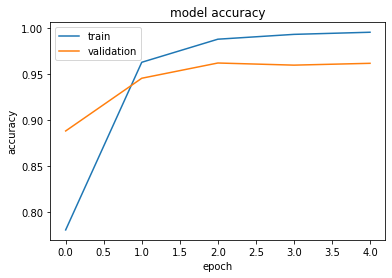

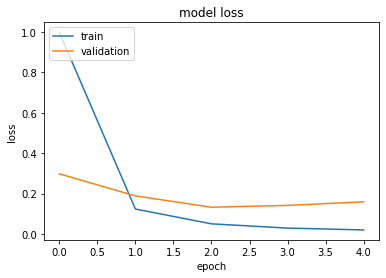

In [29]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [30]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


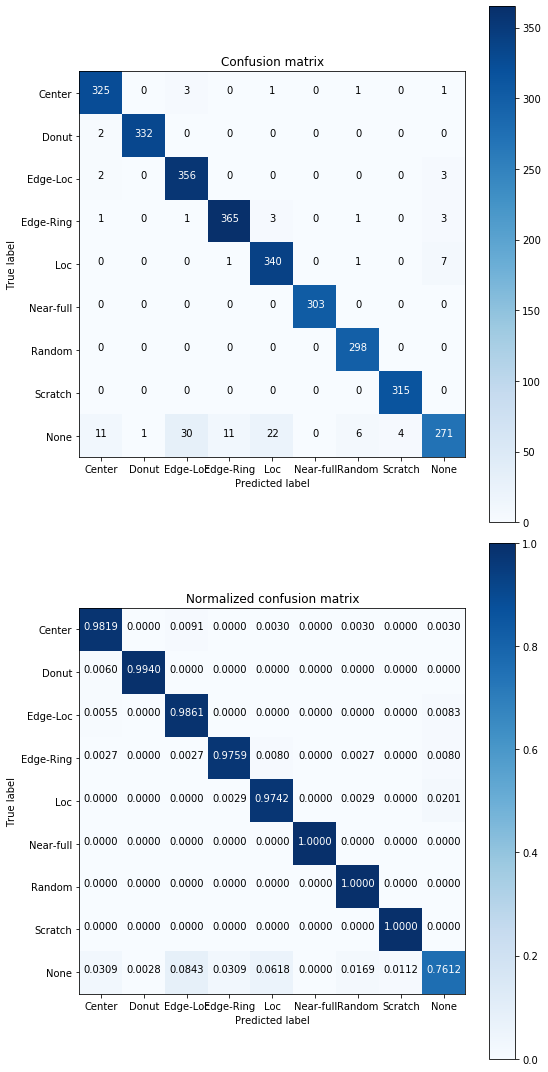

In [31]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


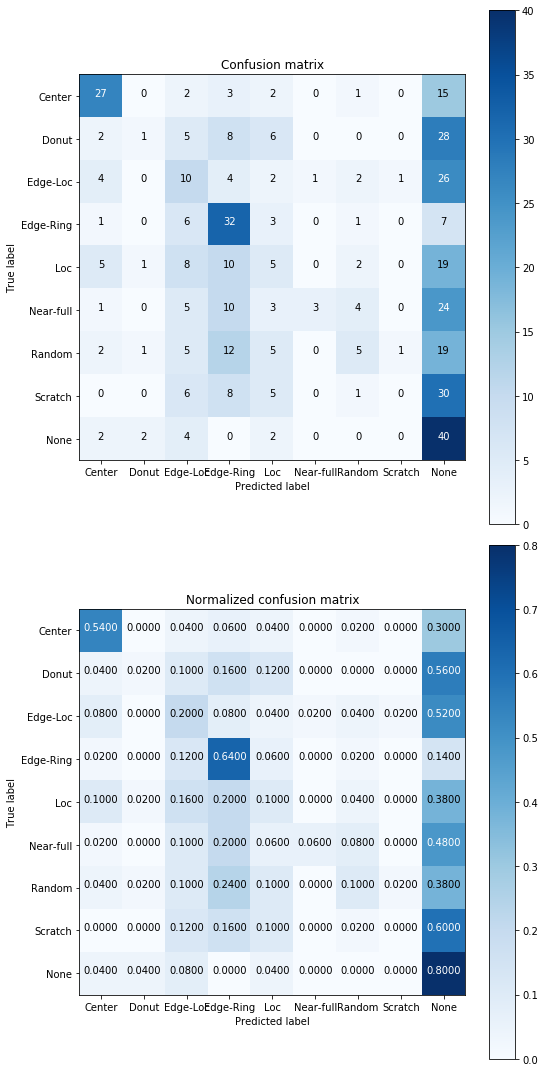

In [32]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [33]:
%%javascript
var notebook_name = document.body.attributes['data-notebook-name'].value
IPython.notebook.kernel.execute(`NOTEBOOK_NAME = '${notebook_name}'`);

<IPython.core.display.Javascript object>

In [36]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, headers=headers)#, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers)#, proxies=proxies)
    
line_notify("学習が終了しました ")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))

KeyboardInterrupt: 